In [1]:
from sklearn.preprocessing import OrdinalEncoder, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from pycaret.regression import setup, compare_models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
from category_encoders import MEstimateEncoder, TargetEncoder

In [3]:
from catboost import CatBoostRegressor

# Read train and test sets

In [4]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

# Store both dfs lengths

In [5]:
m_train = df_train.shape[0]
m_test = df_test.shape[0]
m_train, m_test

(1460, 1459)

# Concat the dfs

In [6]:
df = pd.concat([df_train, df_test])
assert df.shape[0] == m_train + m_test

In [7]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


# Save target

In [8]:
target_col, target = "SalePrice", df["SalePrice"]

#  Drop Id and target columns

In [9]:
cols_to_drop = ["Id", target_col]
df.drop(cols_to_drop, axis=1, inplace=True)

# View and fix columns data-types

In [10]:
df.select_dtypes(object).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [11]:
df.select_dtypes(np.number).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [12]:
num_to_obj_cols = ['MSSubClass', 'MoSold']
df[num_to_obj_cols] = df[num_to_obj_cols].astype(object)

In [13]:
cols_cat = df.select_dtypes(object).columns.to_list()
cols_num = df.select_dtypes(np.number).columns.to_list()

# Feature selection

In [14]:
def get_del_cols(df):
    """return the columns where no more than one value in the categorical features
    exists in the test data - those features can be ignored"""
    cols_to_drop = []
    for col in df.select_dtypes(object).columns:
        col_vals = df[col].unique()
        n_vals = len(col_vals)
        n_irrelevant = 0
        for val in col_vals:
            if val not in df[col][m_train:].values:
                n_irrelevant += 1
        if n_irrelevant >= n_vals - 1:
            cols_to_drop.append(col)
    return cols_to_drop

In [15]:
cols_to_drop = get_del_cols(df)
df.drop(cols_to_drop, axis=1, inplace=True)
for col_to_drop in cols_to_drop:
    cols_cat.remove(col_to_drop)
    print("Dropped ", col_to_drop)

Dropped  Utilities


# Impute categorical columns

In [16]:
cols_cat_na = df[cols_cat].isnull().sum()[df[cols_cat].isnull().sum() > 0]
cols_cat_na

MSZoning           4
Alley           2721
Exterior1st        1
Exterior2nd        1
MasVnrType        24
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

In [17]:
mode_filled_cols = ["MSZoning", "Exterior1st", "Exterior2nd", "MasVnrType", "Electrical", "KitchenQual", "Functional", "SaleType"]
for col in mode_filled_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

none_filled_cols = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]
for col in none_filled_cols:
    df[col].fillna("None", inplace=True)
    
df[cols_cat].isnull().sum().sum()

0

# Change ordinal columns to numeric, and encode accordingly

In [18]:
oe = OrdinalEncoder(categories=[['blank', 'Reg', 'IR1', 'IR2', 'IR3']])
df.loc[:, "LotShape"] = oe.fit_transform(df[["LotShape"]])

In [19]:
oe = OrdinalEncoder(categories=[['blank', 'Gtl', 'Mod', 'Sev']])
df.loc[:, "LandSlope"] = oe.fit_transform(df[["LandSlope"]])

In [20]:
qual_oe = OrdinalEncoder(categories=[['blank', 'None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
for col in ["ExterQual", "ExterCond", 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']:
    df.loc[:, col] = qual_oe.fit_transform(df[[col]])

In [21]:
oe = OrdinalEncoder(categories=[['blank', 'None', 'No', 'Mn', 'Av', 'Gd']])
df.loc[:, "BsmtExposure"] = oe.fit_transform(df[["BsmtExposure"]])

In [22]:
oe = OrdinalEncoder(categories=[['blank', 'None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']])
for col in ["BsmtFinType1", "BsmtFinType2"]:
    df.loc[:, col] = oe.fit_transform(df[[col]])

In [23]:
oe = OrdinalEncoder(categories=[['blank', 'None', 'Unf', 'RFn', 'Fin']])
df.loc[:, "GarageFinish"] = oe.fit_transform(df[["GarageFinish"]])

In [24]:
oe = OrdinalEncoder(categories=[['blank', 'N', 'P', 'Y']])
df.loc[:, "PavedDrive"] = oe.fit_transform(df[["PavedDrive"]])

In [25]:
oe = OrdinalEncoder(categories=[['blank', 'None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']])
df.loc[:, "Fence"] = oe.fit_transform(df[["Fence"]])

In [26]:
cols_cat = df.select_dtypes(object).columns.to_list()
cols_num = df.select_dtypes(np.number).columns.to_list()

# Impute numerical columns

In [27]:
cols_num_na = df[cols_num].isnull().sum()[df[cols_num].isnull().sum() > 0]
cols_num_na

LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64

In [28]:
zero_filled_cols = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath", "GarageCars", "GarageArea"]
for col in zero_filled_cols:
    df[col].fillna(0, inplace=True)

In [29]:
# Thanks to: https://www.kaggle.com/code/t3kuwabara/houseprices-test2
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [30]:
df["MasVnrArea"] = df.groupby("Neighborhood")["MasVnrArea"].transform(lambda x: x.fillna(x.median()))

In [31]:
df.loc[df["GarageYrBlt"].isnull(), "GarageYrBlt"] = df.loc[df["GarageYrBlt"].isnull(), "YearBuilt"]

In [32]:
cols_num_na = df[cols_num].isnull().sum()[df[cols_num].isnull().sum() > 0]
cols_num_na

Series([], dtype: int64)

In [33]:
# def catboost_imputer(df, cols_num_na):
    
#     # save columns to impute and drop them from df
#     cols_to_impute = df[cols_num_na]
#     df.drop(cols_num_na, axis=1, inplace=True)
    
#     for col in cols_num_na:
#         # define X and y
#         X, y = df.copy(), cols_to_impute[col]

#         # get train and test sets
#         train_indexes, test_indexes = ~y.isnull(), y.isnull()
#         X_train, X_test = X.loc[train_indexes, :], X.loc[test_indexes, :]
#         y_train, y_test = y.loc[train_indexes], y.loc[test_indexes]
        
#         model = CatBoostRegressor(max_depth=8, random_seed=10,
#                                   subsample=0.65, n_estimators=1000,
#                                   cat_features=cols_cat)
#         model.fit(X_train, y_train)
#         cols_to_impute.loc[test_indexes, col] = model.predict(X_test)
#         df[col] = cols_to_impute[col]
#     return df

In [34]:
# df = catboost_imputer(df, cols_num_na.index)
# df.isnull().sum().sum()

# Target Encoding

Thanks to https://www.kaggle.com/code/alexturkmen/preprocessing-modeling-with-stacking-top-5

In [35]:
target_encoder = MEstimateEncoder(cols = df[cols_cat], m=5.0)
df = target_encoder.fit_transform(df, target)
df[cols_cat].head()

,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,...,Foundation,Heating,CentralAir,Electrical,Functional,GarageType,MiscFeature,MoSold,SaleType,SaleCondition
0,238977.657827,190961.37974,181129.821096,183442.921382,180186.548617,176956.889290,197415.948255,184481.364411,181168.549641,185744.041616,...,224890.647208,182017.357278,186167.492686,186788.661925,183419.960425,202767.105119,182042.42309,178148.596131,173431.393852,175225.989177
1,185185.036931,190961.37974,181129.821096,183442.921382,180186.548617,178221.749605,220694.123716,144710.697435,181168.549641,185744.041616,...,150049.184631,182017.357278,186167.492686,186788.661925,183419.960425,202767.105119,182042.42309,172513.344399,173431.393852,175225.989177
2,238977.657827,190961.37974,181129.821096,183442.921382,180186.548617,176956.889290,197415.948255,184481.364411,181168.549641,185744.041616,...,224890.647208,182017.357278,186167.492686,186788.661925,183419.960425,202767.105119,182042.42309,194597.764404,173431.393852,175225.989177
3,167860.784299,190961.37974,181129.821096,183442.921382,180186.548617,181610.324550,207972.624633,184481.364411,181168.549641,185744.041616,...,133901.344235,182017.357278,186167.492686,186788.661925,183419.960425,134688.484641,182042.42309,178148.596131,173431.393852,148149.009240
4,238977.657827,190961.37974,181129.821096,183442.921382,180186.548617,178221.749605,318515.521292,184481.364411,181168.549641,185744.041616,...,224890.647208,182017.357278,186167.492686,186788.661925,183419.960425,202767.105119,182042.42309,186081.640304,173431.393852,175225.989177


# Feature Engineering

## Features from the Internet - prefex FE0_

In [36]:
df["FE0_HighQualSF"] = df["GrLivArea"]+df["1stFlrSF"] + df["2ndFlrSF"]+0.5*df["GarageArea"]+0.5*df["TotalBsmtSF"]+1*df["MasVnrArea"]

df["FE0_SqFtPerRoom"] = df["GrLivArea"] / (df["TotRmsAbvGrd"] +
                                           df["FullBath"] +
                                           df["HalfBath"] +
                                           df["KitchenAbvGr"])

## My features - prefex FE1_

In [37]:
n_stories_dict = {
    "1Story": 1.0,
    "1.5Fin": 1.5,
    "1.5Unf": 1.5,
    "2Story": 2.0,
    "2.5Fin": 2.5,
    "2.5Unf": 2.5,
    "SFoyer": 2.0,
    "SLvl": 2.0,
}

df["FE1_n_stories"] = df["HouseStyle"].replace(n_stories_dict)
df["FE1_n_stories"].value_counts()

176019.238002    1471
209728.091065     872
144305.559619     314
167718.942564     128
140532.428082      83
164719.123716      24
128773.998919      19
204969.690727       8
Name: FE1_n_stories, dtype: int64

In [38]:
df["FE1_age_sold"] = df["YrSold"] - df["YearBuilt"]
df["FE1_age_sold_Remod"] = df["YrSold"] - df["YearRemodAdd"]
df["FE1_GarageYrSold"] = df["YrSold"] - df["GarageYrBlt"]

In [39]:
df['FE1_total_area_hq'] = df["FE0_HighQualSF"] - df['LowQualFinSF']

# Apply polynomial features

In [40]:
cols_to_poly = ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'ExterQual', 'ExterCond','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 'BsmtFinSF2', 'TotalBsmtSF', 'FE1_total_area_hq', 'GrLivArea', 'FullBath', 'HalfBath', 'FE0_SqFtPerRoom', 'KitchenQual', 'KitchenAbvGr', 'Fireplaces', 'FireplaceQu', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolArea', 'YrSold', 'LotFrontage', 'FE0_HighQualSF',]

In [41]:
poly = PolynomialFeatures(degree=2, include_bias=False)
cols_df = df[cols_to_poly]
df.drop(cols_to_poly, axis=1, inplace=True)
cols_array = poly.fit_transform(cols_df)
cols_df = pd.DataFrame(cols_array, columns=poly.get_feature_names_out())
df = pd.concat((df.reset_index(drop=True), cols_df.reset_index(drop=True)), axis=1)

df.shape

(2919, 613)

# Split test and train

In [42]:
X_train, X_test = df[:m_train], df[m_train:]
y_train, _ = target[:m_train], target[m_train:]
n = X_train.shape[1]
X_train.shape, y_train.shape

((1460, 613), (1460,))

In [43]:
# df_ohe = pd.get_dummies(df)
# df_ohe[target_col] = target
# _ = setup(data=df_ohe[:m_train], target='SalePrice')
# best = compare_models()

# Training - CatBoost Grid Search 

In [44]:
# cat_features = df.select_dtypes(object).columns.to_list()
# model = CatBoostRegressor(random_state=10, cat_features=cat_features)
# kwargs = {
#     "n_estimators": [20_000, 25_000],
#     "max_depth": [8],
#     "subsample": [0.65],
#     "reg_lambda": [0.1], 
# }
# clf = GridSearchCV(model, kwargs, verbose=1, n_jobs=2)
# clf.fit(X_train, y_train)
# print(clf.best_score_)
# print(clf.best_params_)

# CatBoost Params:
    {'max_depth': 8, 'n_estimators': 20_000 (the more the better?), 'reg_lambda': 0.1, 'subsample': 0.65}

In [45]:
# clf.best_score_

# Training - CatBoost with Best Parameters

In [46]:
model = CatBoostRegressor(max_depth=8, random_seed=10,
                          subsample=0.65, n_estimators=20_000)
history = model.fit(X_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.003805
0:	learn: 79215.9499368	total: 112ms	remaining: 37m 28s
1:	learn: 79014.4514494	total: 172ms	remaining: 28m 41s
2:	learn: 78808.7585050	total: 235ms	remaining: 26m 4s
3:	learn: 78606.2401051	total: 294ms	remaining: 24m 29s
4:	learn: 78415.1455604	total: 365ms	remaining: 24m 17s
5:	learn: 78212.4533525	total: 426ms	remaining: 23m 39s
6:	learn: 78001.9707665	total: 491ms	remaining: 23m 22s
7:	learn: 77813.6915125	total: 558ms	remaining: 23m 13s
8:	learn: 77615.6935982	total: 637ms	remaining: 23m 34s
9:	learn: 77410.8136318	total: 710ms	remaining: 23m 39s
10:	learn: 77203.8964427	total: 778ms	remaining: 23m 33s
11:	learn: 77001.6907467	total: 842ms	remaining: 23m 21s
12:	learn: 76811.0783236	total: 904ms	remaining: 23m 9s
13:	learn: 76605.1085409	total: 971ms	remaining: 23m 6s
14:	learn: 76408.2203083	total: 1.03s	remaining: 22m 59s
15:	learn: 76211.6320718	total: 1.12s	remaining: 23m 15s
16:	learn: 76007.0384879	total: 1.21s	remaining: 23m 47s
17:	learn: 758

146:	learn: 55608.5438314	total: 9.12s	remaining: 20m 31s
147:	learn: 55493.8035734	total: 9.18s	remaining: 20m 31s
148:	learn: 55380.0095271	total: 9.24s	remaining: 20m 31s
149:	learn: 55260.9386694	total: 9.31s	remaining: 20m 31s
150:	learn: 55134.7374151	total: 9.38s	remaining: 20m 32s
151:	learn: 55005.0079193	total: 9.45s	remaining: 20m 34s
152:	learn: 54875.5983928	total: 9.52s	remaining: 20m 34s
153:	learn: 54750.2950757	total: 9.59s	remaining: 20m 35s
154:	learn: 54636.6982257	total: 9.65s	remaining: 20m 35s
155:	learn: 54515.5893563	total: 9.71s	remaining: 20m 34s
156:	learn: 54395.0601306	total: 9.77s	remaining: 20m 34s
157:	learn: 54275.8863785	total: 9.82s	remaining: 20m 33s
158:	learn: 54156.3252566	total: 9.88s	remaining: 20m 33s
159:	learn: 54039.5667306	total: 9.95s	remaining: 20m 33s
160:	learn: 53919.1256270	total: 10s	remaining: 20m 33s
161:	learn: 53797.0808754	total: 10.1s	remaining: 20m 32s
162:	learn: 53678.0683217	total: 10.1s	remaining: 20m 32s
163:	learn: 5355

288:	learn: 41531.5021590	total: 17.8s	remaining: 20m 13s
289:	learn: 41451.3431783	total: 17.9s	remaining: 20m 13s
290:	learn: 41375.3988229	total: 17.9s	remaining: 20m 13s
291:	learn: 41302.1865609	total: 18s	remaining: 20m 13s
292:	learn: 41227.4890897	total: 18s	remaining: 20m 13s
293:	learn: 41150.1278060	total: 18.1s	remaining: 20m 12s
294:	learn: 41083.1920350	total: 18.2s	remaining: 20m 12s
295:	learn: 41016.4157340	total: 18.2s	remaining: 20m 12s
296:	learn: 40944.5747484	total: 18.3s	remaining: 20m 12s
297:	learn: 40870.2445102	total: 18.3s	remaining: 20m 11s
298:	learn: 40801.2784874	total: 18.4s	remaining: 20m 11s
299:	learn: 40719.1676753	total: 18.5s	remaining: 20m 12s
300:	learn: 40649.1745230	total: 18.5s	remaining: 20m 13s
301:	learn: 40577.6882170	total: 18.6s	remaining: 20m 13s
302:	learn: 40505.9104246	total: 18.7s	remaining: 20m 13s
303:	learn: 40433.2168960	total: 18.7s	remaining: 20m 14s
304:	learn: 40360.5148856	total: 18.8s	remaining: 20m 14s
305:	learn: 40292.

433:	learn: 32632.0076417	total: 26.3s	remaining: 19m 46s
434:	learn: 32585.2967371	total: 26.4s	remaining: 19m 46s
435:	learn: 32536.4564928	total: 26.4s	remaining: 19m 46s
436:	learn: 32491.5153786	total: 26.5s	remaining: 19m 46s
437:	learn: 32442.3966088	total: 26.6s	remaining: 19m 46s
438:	learn: 32398.3502914	total: 26.6s	remaining: 19m 46s
439:	learn: 32351.7190133	total: 26.7s	remaining: 19m 46s
440:	learn: 32302.5166794	total: 26.8s	remaining: 19m 46s
441:	learn: 32253.1714604	total: 26.8s	remaining: 19m 46s
442:	learn: 32207.5742963	total: 26.9s	remaining: 19m 46s
443:	learn: 32163.9367129	total: 26.9s	remaining: 19m 45s
444:	learn: 32119.8029462	total: 27s	remaining: 19m 45s
445:	learn: 32076.9550046	total: 27s	remaining: 19m 45s
446:	learn: 32030.5506640	total: 27.1s	remaining: 19m 45s
447:	learn: 31980.5743086	total: 27.1s	remaining: 19m 44s
448:	learn: 31934.4859855	total: 27.2s	remaining: 19m 44s
449:	learn: 31888.5780001	total: 27.3s	remaining: 19m 44s
450:	learn: 31844.

577:	learn: 26995.5634442	total: 34.7s	remaining: 19m 25s
578:	learn: 26968.9559097	total: 34.7s	remaining: 19m 24s
579:	learn: 26939.0853238	total: 34.8s	remaining: 19m 24s
580:	learn: 26907.6055877	total: 34.8s	remaining: 19m 24s
581:	learn: 26879.2183524	total: 34.9s	remaining: 19m 24s
582:	learn: 26852.5903678	total: 35s	remaining: 19m 24s
583:	learn: 26823.1017107	total: 35s	remaining: 19m 24s
584:	learn: 26795.6069368	total: 35.1s	remaining: 19m 23s
585:	learn: 26763.6123480	total: 35.1s	remaining: 19m 23s
586:	learn: 26730.4908426	total: 35.2s	remaining: 19m 23s
587:	learn: 26699.2803830	total: 35.2s	remaining: 19m 23s
588:	learn: 26674.1553456	total: 35.3s	remaining: 19m 23s
589:	learn: 26644.6263568	total: 35.4s	remaining: 19m 23s
590:	learn: 26615.6069561	total: 35.4s	remaining: 19m 23s
591:	learn: 26584.9961928	total: 35.5s	remaining: 19m 22s
592:	learn: 26554.4130019	total: 35.5s	remaining: 19m 22s
593:	learn: 26524.5606937	total: 35.6s	remaining: 19m 22s
594:	learn: 26495.

721:	learn: 23384.7432435	total: 43s	remaining: 19m 7s
722:	learn: 23363.3886234	total: 43s	remaining: 19m 7s
723:	learn: 23340.6048350	total: 43.1s	remaining: 19m 6s
724:	learn: 23319.7099854	total: 43.1s	remaining: 19m 6s
725:	learn: 23299.7868203	total: 43.2s	remaining: 19m 6s
726:	learn: 23277.2437393	total: 43.3s	remaining: 19m 6s
727:	learn: 23255.7530246	total: 43.3s	remaining: 19m 6s
728:	learn: 23237.1641710	total: 43.4s	remaining: 19m 6s
729:	learn: 23214.3724846	total: 43.4s	remaining: 19m 6s
730:	learn: 23192.6469982	total: 43.5s	remaining: 19m 6s
731:	learn: 23172.3475387	total: 43.5s	remaining: 19m 5s
732:	learn: 23151.7100837	total: 43.6s	remaining: 19m 5s
733:	learn: 23130.5100298	total: 43.7s	remaining: 19m 5s
734:	learn: 23112.9873934	total: 43.7s	remaining: 19m 5s
735:	learn: 23095.3303826	total: 43.8s	remaining: 19m 5s
736:	learn: 23072.2896893	total: 43.8s	remaining: 19m 5s
737:	learn: 23051.0798006	total: 43.9s	remaining: 19m 5s
738:	learn: 23030.9321027	total: 43

865:	learn: 20924.4356899	total: 51.3s	remaining: 18m 54s
866:	learn: 20911.6703461	total: 51.4s	remaining: 18m 54s
867:	learn: 20899.6018435	total: 51.5s	remaining: 18m 54s
868:	learn: 20886.0756204	total: 51.5s	remaining: 18m 53s
869:	learn: 20874.2430948	total: 51.6s	remaining: 18m 53s
870:	learn: 20860.8991163	total: 51.6s	remaining: 18m 53s
871:	learn: 20847.8751300	total: 51.7s	remaining: 18m 53s
872:	learn: 20835.1581051	total: 51.7s	remaining: 18m 53s
873:	learn: 20822.3735037	total: 51.8s	remaining: 18m 53s
874:	learn: 20810.5105144	total: 51.9s	remaining: 18m 53s
875:	learn: 20796.8604863	total: 51.9s	remaining: 18m 53s
876:	learn: 20783.8374882	total: 52s	remaining: 18m 53s
877:	learn: 20771.2087901	total: 52s	remaining: 18m 53s
878:	learn: 20752.8969619	total: 52.1s	remaining: 18m 52s
879:	learn: 20738.7791964	total: 52.1s	remaining: 18m 52s
880:	learn: 20724.9696337	total: 52.2s	remaining: 18m 52s
881:	learn: 20709.4875495	total: 52.3s	remaining: 18m 52s
882:	learn: 20694.

1009:	learn: 19230.5399589	total: 59.6s	remaining: 18m 41s
1010:	learn: 19220.0422210	total: 59.7s	remaining: 18m 41s
1011:	learn: 19211.2795002	total: 59.8s	remaining: 18m 41s
1012:	learn: 19200.2965267	total: 59.8s	remaining: 18m 41s
1013:	learn: 19190.0748398	total: 59.9s	remaining: 18m 41s
1014:	learn: 19181.0995923	total: 59.9s	remaining: 18m 41s
1015:	learn: 19172.7942756	total: 60s	remaining: 18m 40s
1016:	learn: 19163.0682615	total: 1m	remaining: 18m 40s
1017:	learn: 19154.6668639	total: 1m	remaining: 18m 40s
1018:	learn: 19145.2231400	total: 1m	remaining: 18m 40s
1019:	learn: 19137.0728457	total: 1m	remaining: 18m 40s
1020:	learn: 19126.8408749	total: 1m	remaining: 18m 40s
1021:	learn: 19117.3802510	total: 1m	remaining: 18m 40s
1022:	learn: 19107.4174620	total: 1m	remaining: 18m 40s
1023:	learn: 19096.4658585	total: 1m	remaining: 18m 40s
1024:	learn: 19085.5253043	total: 1m	remaining: 18m 40s
1025:	learn: 19075.5896082	total: 1m	remaining: 18m 40s
1026:	learn: 19064.8944380	to

1152:	learn: 18015.1475080	total: 1m 7s	remaining: 18m 31s
1153:	learn: 18006.8712385	total: 1m 8s	remaining: 18m 30s
1154:	learn: 17999.7219952	total: 1m 8s	remaining: 18m 30s
1155:	learn: 17992.7205777	total: 1m 8s	remaining: 18m 30s
1156:	learn: 17982.9902388	total: 1m 8s	remaining: 18m 30s
1157:	learn: 17977.3256843	total: 1m 8s	remaining: 18m 30s
1158:	learn: 17970.8807750	total: 1m 8s	remaining: 18m 30s
1159:	learn: 17964.8122777	total: 1m 8s	remaining: 18m 30s
1160:	learn: 17958.5612870	total: 1m 8s	remaining: 18m 30s
1161:	learn: 17951.3723406	total: 1m 8s	remaining: 18m 30s
1162:	learn: 17943.9597809	total: 1m 8s	remaining: 18m 30s
1163:	learn: 17937.5041352	total: 1m 8s	remaining: 18m 30s
1164:	learn: 17932.0326067	total: 1m 8s	remaining: 18m 30s
1165:	learn: 17924.7328539	total: 1m 8s	remaining: 18m 29s
1166:	learn: 17918.6397184	total: 1m 8s	remaining: 18m 29s
1167:	learn: 17911.2574336	total: 1m 8s	remaining: 18m 29s
1168:	learn: 17902.9952686	total: 1m 8s	remaining: 18m 2

1291:	learn: 17099.4680141	total: 1m 16s	remaining: 18m 21s
1292:	learn: 17093.6166422	total: 1m 16s	remaining: 18m 21s
1293:	learn: 17087.6719890	total: 1m 16s	remaining: 18m 21s
1294:	learn: 17082.3133429	total: 1m 16s	remaining: 18m 21s
1295:	learn: 17075.6948602	total: 1m 16s	remaining: 18m 21s
1296:	learn: 17069.6557884	total: 1m 16s	remaining: 18m 21s
1297:	learn: 17064.4586788	total: 1m 16s	remaining: 18m 20s
1298:	learn: 17057.6743597	total: 1m 16s	remaining: 18m 20s
1299:	learn: 17052.4184112	total: 1m 16s	remaining: 18m 20s
1300:	learn: 17045.9970752	total: 1m 16s	remaining: 18m 20s
1301:	learn: 17039.0723894	total: 1m 16s	remaining: 18m 20s
1302:	learn: 17035.1803408	total: 1m 16s	remaining: 18m 20s
1303:	learn: 17030.8517195	total: 1m 16s	remaining: 18m 20s
1304:	learn: 17025.3550552	total: 1m 16s	remaining: 18m 20s
1305:	learn: 17019.6566521	total: 1m 16s	remaining: 18m 20s
1306:	learn: 17012.5781491	total: 1m 16s	remaining: 18m 20s
1307:	learn: 17007.3286668	total: 1m 16s

1431:	learn: 16372.7156427	total: 1m 24s	remaining: 18m 11s
1432:	learn: 16367.5070312	total: 1m 24s	remaining: 18m 11s
1433:	learn: 16361.5895552	total: 1m 24s	remaining: 18m 11s
1434:	learn: 16357.7712096	total: 1m 24s	remaining: 18m 11s
1435:	learn: 16352.4437439	total: 1m 24s	remaining: 18m 11s
1436:	learn: 16348.5729726	total: 1m 24s	remaining: 18m 11s
1437:	learn: 16343.7693959	total: 1m 24s	remaining: 18m 11s
1438:	learn: 16339.2496506	total: 1m 24s	remaining: 18m 10s
1439:	learn: 16335.8539384	total: 1m 24s	remaining: 18m 10s
1440:	learn: 16333.2706941	total: 1m 24s	remaining: 18m 10s
1441:	learn: 16327.7121355	total: 1m 24s	remaining: 18m 10s
1442:	learn: 16323.5573188	total: 1m 24s	remaining: 18m 10s
1443:	learn: 16319.6170031	total: 1m 24s	remaining: 18m 10s
1444:	learn: 16315.2616365	total: 1m 24s	remaining: 18m 10s
1445:	learn: 16310.3810840	total: 1m 24s	remaining: 18m 10s
1446:	learn: 16306.4534013	total: 1m 25s	remaining: 18m 10s
1447:	learn: 16301.8382887	total: 1m 25s

1571:	learn: 15773.6942978	total: 1m 32s	remaining: 18m 1s
1572:	learn: 15768.1738375	total: 1m 32s	remaining: 18m 1s
1573:	learn: 15762.5312332	total: 1m 32s	remaining: 18m 1s
1574:	learn: 15759.4726289	total: 1m 32s	remaining: 18m 1s
1575:	learn: 15753.9591293	total: 1m 32s	remaining: 18m 1s
1576:	learn: 15750.0951512	total: 1m 32s	remaining: 18m 1s
1577:	learn: 15745.6050105	total: 1m 32s	remaining: 18m 1s
1578:	learn: 15742.0355860	total: 1m 32s	remaining: 18m 1s
1579:	learn: 15737.8199270	total: 1m 32s	remaining: 18m 1s
1580:	learn: 15732.5674661	total: 1m 32s	remaining: 18m
1581:	learn: 15728.3714308	total: 1m 32s	remaining: 18m
1582:	learn: 15723.6939933	total: 1m 32s	remaining: 18m
1583:	learn: 15719.0226481	total: 1m 32s	remaining: 18m
1584:	learn: 15714.9491985	total: 1m 33s	remaining: 18m
1585:	learn: 15711.6591972	total: 1m 33s	remaining: 18m
1586:	learn: 15704.8758575	total: 1m 33s	remaining: 18m
1587:	learn: 15701.4742196	total: 1m 33s	remaining: 18m
1588:	learn: 15697.18

1710:	learn: 15187.2735023	total: 1m 40s	remaining: 17m 53s
1711:	learn: 15183.8904212	total: 1m 40s	remaining: 17m 52s
1712:	learn: 15178.5867959	total: 1m 40s	remaining: 17m 52s
1713:	learn: 15174.8760350	total: 1m 40s	remaining: 17m 52s
1714:	learn: 15169.4997750	total: 1m 40s	remaining: 17m 52s
1715:	learn: 15166.8125373	total: 1m 40s	remaining: 17m 52s
1716:	learn: 15163.0492407	total: 1m 40s	remaining: 17m 52s
1717:	learn: 15159.1190772	total: 1m 40s	remaining: 17m 52s
1718:	learn: 15154.9879527	total: 1m 40s	remaining: 17m 52s
1719:	learn: 15150.7102615	total: 1m 40s	remaining: 17m 52s
1720:	learn: 15146.8653308	total: 1m 40s	remaining: 17m 52s
1721:	learn: 15142.4168739	total: 1m 41s	remaining: 17m 52s
1722:	learn: 15137.5366864	total: 1m 41s	remaining: 17m 52s
1723:	learn: 15133.5692429	total: 1m 41s	remaining: 17m 52s
1724:	learn: 15127.7273282	total: 1m 41s	remaining: 17m 51s
1725:	learn: 15122.8412655	total: 1m 41s	remaining: 17m 51s
1726:	learn: 15117.7554807	total: 1m 41s

1850:	learn: 14656.5728327	total: 1m 48s	remaining: 17m 43s
1851:	learn: 14655.0157190	total: 1m 48s	remaining: 17m 43s
1852:	learn: 14651.5143119	total: 1m 48s	remaining: 17m 43s
1853:	learn: 14647.2475155	total: 1m 48s	remaining: 17m 43s
1854:	learn: 14645.0767643	total: 1m 48s	remaining: 17m 43s
1855:	learn: 14641.2545668	total: 1m 48s	remaining: 17m 43s
1856:	learn: 14636.9322723	total: 1m 48s	remaining: 17m 43s
1857:	learn: 14632.7409661	total: 1m 48s	remaining: 17m 43s
1858:	learn: 14628.9759818	total: 1m 48s	remaining: 17m 43s
1859:	learn: 14626.6103477	total: 1m 49s	remaining: 17m 43s
1860:	learn: 14623.3466008	total: 1m 49s	remaining: 17m 43s
1861:	learn: 14621.1060714	total: 1m 49s	remaining: 17m 43s
1862:	learn: 14618.5261641	total: 1m 49s	remaining: 17m 43s
1863:	learn: 14614.2091120	total: 1m 49s	remaining: 17m 43s
1864:	learn: 14610.0353711	total: 1m 49s	remaining: 17m 42s
1865:	learn: 14606.7829225	total: 1m 49s	remaining: 17m 42s
1866:	learn: 14601.9553690	total: 1m 49s

1990:	learn: 14155.0879649	total: 1m 57s	remaining: 17m 38s
1991:	learn: 14150.5312125	total: 1m 57s	remaining: 17m 38s
1992:	learn: 14147.1533127	total: 1m 57s	remaining: 17m 38s
1993:	learn: 14142.6651841	total: 1m 57s	remaining: 17m 38s
1994:	learn: 14139.6360380	total: 1m 57s	remaining: 17m 38s
1995:	learn: 14135.7208800	total: 1m 57s	remaining: 17m 38s
1996:	learn: 14131.6134995	total: 1m 57s	remaining: 17m 38s
1997:	learn: 14127.5602088	total: 1m 57s	remaining: 17m 38s
1998:	learn: 14122.6900359	total: 1m 57s	remaining: 17m 38s
1999:	learn: 14119.7336178	total: 1m 57s	remaining: 17m 37s
2000:	learn: 14116.7731280	total: 1m 57s	remaining: 17m 37s
2001:	learn: 14112.0958093	total: 1m 57s	remaining: 17m 37s
2002:	learn: 14107.9456058	total: 1m 57s	remaining: 17m 37s
2003:	learn: 14104.4784283	total: 1m 57s	remaining: 17m 37s
2004:	learn: 14098.8029994	total: 1m 57s	remaining: 17m 37s
2005:	learn: 14096.3065930	total: 1m 57s	remaining: 17m 37s
2006:	learn: 14092.3311201	total: 1m 57s

2130:	learn: 13670.3567281	total: 2m 5s	remaining: 17m 30s
2131:	learn: 13666.9922280	total: 2m 5s	remaining: 17m 30s
2132:	learn: 13662.7811720	total: 2m 5s	remaining: 17m 30s
2133:	learn: 13659.5900025	total: 2m 5s	remaining: 17m 30s
2134:	learn: 13657.8608861	total: 2m 5s	remaining: 17m 30s
2135:	learn: 13654.1817195	total: 2m 5s	remaining: 17m 30s
2136:	learn: 13652.6218967	total: 2m 5s	remaining: 17m 30s
2137:	learn: 13649.7714476	total: 2m 5s	remaining: 17m 30s
2138:	learn: 13647.1241485	total: 2m 5s	remaining: 17m 30s
2139:	learn: 13644.0694816	total: 2m 5s	remaining: 17m 30s
2140:	learn: 13641.2372313	total: 2m 5s	remaining: 17m 30s
2141:	learn: 13635.2841506	total: 2m 5s	remaining: 17m 30s
2142:	learn: 13630.7780545	total: 2m 6s	remaining: 17m 30s
2143:	learn: 13626.6601325	total: 2m 6s	remaining: 17m 29s
2144:	learn: 13623.1125751	total: 2m 6s	remaining: 17m 29s
2145:	learn: 13619.0531406	total: 2m 6s	remaining: 17m 29s
2146:	learn: 13615.5700161	total: 2m 6s	remaining: 17m 2

2269:	learn: 13209.3528964	total: 2m 13s	remaining: 17m 22s
2270:	learn: 13207.2502112	total: 2m 13s	remaining: 17m 22s
2271:	learn: 13205.2306076	total: 2m 13s	remaining: 17m 22s
2272:	learn: 13201.7313170	total: 2m 13s	remaining: 17m 22s
2273:	learn: 13199.2776329	total: 2m 13s	remaining: 17m 22s
2274:	learn: 13197.3269123	total: 2m 13s	remaining: 17m 22s
2275:	learn: 13192.6716123	total: 2m 13s	remaining: 17m 22s
2276:	learn: 13189.5184104	total: 2m 13s	remaining: 17m 22s
2277:	learn: 13186.1092434	total: 2m 13s	remaining: 17m 22s
2278:	learn: 13183.0680842	total: 2m 14s	remaining: 17m 22s
2279:	learn: 13180.3097533	total: 2m 14s	remaining: 17m 22s
2280:	learn: 13177.0947471	total: 2m 14s	remaining: 17m 22s
2281:	learn: 13172.6586927	total: 2m 14s	remaining: 17m 22s
2282:	learn: 13169.2062582	total: 2m 14s	remaining: 17m 22s
2283:	learn: 13165.5567014	total: 2m 14s	remaining: 17m 21s
2284:	learn: 13163.9457111	total: 2m 14s	remaining: 17m 21s
2285:	learn: 13159.7742674	total: 2m 14s

2408:	learn: 12752.0157308	total: 2m 21s	remaining: 17m 14s
2409:	learn: 12747.5001125	total: 2m 21s	remaining: 17m 14s
2410:	learn: 12744.6737478	total: 2m 21s	remaining: 17m 13s
2411:	learn: 12740.3856463	total: 2m 21s	remaining: 17m 13s
2412:	learn: 12737.7635649	total: 2m 21s	remaining: 17m 13s
2413:	learn: 12734.7101877	total: 2m 21s	remaining: 17m 13s
2414:	learn: 12731.7119634	total: 2m 21s	remaining: 17m 13s
2415:	learn: 12730.0265109	total: 2m 22s	remaining: 17m 13s
2416:	learn: 12726.5426570	total: 2m 22s	remaining: 17m 13s
2417:	learn: 12722.7229856	total: 2m 22s	remaining: 17m 13s
2418:	learn: 12720.7695040	total: 2m 22s	remaining: 17m 13s
2419:	learn: 12717.5212996	total: 2m 22s	remaining: 17m 13s
2420:	learn: 12715.1516334	total: 2m 22s	remaining: 17m 13s
2421:	learn: 12712.5546840	total: 2m 22s	remaining: 17m 13s
2422:	learn: 12710.2550806	total: 2m 22s	remaining: 17m 13s
2423:	learn: 12706.4257539	total: 2m 22s	remaining: 17m 13s
2424:	learn: 12703.4577044	total: 2m 22s

2546:	learn: 12303.2304481	total: 2m 29s	remaining: 17m 6s
2547:	learn: 12298.8637418	total: 2m 29s	remaining: 17m 6s
2548:	learn: 12294.5658744	total: 2m 29s	remaining: 17m 6s
2549:	learn: 12291.9135640	total: 2m 29s	remaining: 17m 6s
2550:	learn: 12288.7820342	total: 2m 30s	remaining: 17m 6s
2551:	learn: 12283.5533663	total: 2m 30s	remaining: 17m 6s
2552:	learn: 12279.9519080	total: 2m 30s	remaining: 17m 6s
2553:	learn: 12277.1307364	total: 2m 30s	remaining: 17m 6s
2554:	learn: 12275.8454608	total: 2m 30s	remaining: 17m 5s
2555:	learn: 12271.3704319	total: 2m 30s	remaining: 17m 5s
2556:	learn: 12269.2442577	total: 2m 30s	remaining: 17m 5s
2557:	learn: 12265.0536049	total: 2m 30s	remaining: 17m 5s
2558:	learn: 12261.2655588	total: 2m 30s	remaining: 17m 5s
2559:	learn: 12257.0633868	total: 2m 30s	remaining: 17m 5s
2560:	learn: 12252.9134985	total: 2m 30s	remaining: 17m 5s
2561:	learn: 12249.8940278	total: 2m 30s	remaining: 17m 5s
2562:	learn: 12246.3591429	total: 2m 30s	remaining: 17m 

2686:	learn: 11880.9400048	total: 2m 38s	remaining: 16m 58s
2687:	learn: 11877.8882182	total: 2m 38s	remaining: 16m 58s
2688:	learn: 11874.1674516	total: 2m 38s	remaining: 16m 58s
2689:	learn: 11872.8956614	total: 2m 38s	remaining: 16m 57s
2690:	learn: 11869.1569383	total: 2m 38s	remaining: 16m 57s
2691:	learn: 11865.9004616	total: 2m 38s	remaining: 16m 57s
2692:	learn: 11862.2178870	total: 2m 38s	remaining: 16m 57s
2693:	learn: 11859.2633199	total: 2m 38s	remaining: 16m 57s
2694:	learn: 11857.0687431	total: 2m 38s	remaining: 16m 57s
2695:	learn: 11854.0321473	total: 2m 38s	remaining: 16m 57s
2696:	learn: 11851.5133701	total: 2m 38s	remaining: 16m 57s
2697:	learn: 11848.3080280	total: 2m 38s	remaining: 16m 57s
2698:	learn: 11845.3437756	total: 2m 38s	remaining: 16m 57s
2699:	learn: 11843.5132731	total: 2m 38s	remaining: 16m 57s
2700:	learn: 11840.0095628	total: 2m 38s	remaining: 16m 57s
2701:	learn: 11836.4267449	total: 2m 38s	remaining: 16m 57s
2702:	learn: 11835.1244656	total: 2m 38s

2826:	learn: 11471.0579895	total: 2m 46s	remaining: 16m 49s
2827:	learn: 11467.4876987	total: 2m 46s	remaining: 16m 49s
2828:	learn: 11463.7085815	total: 2m 46s	remaining: 16m 49s
2829:	learn: 11462.6166001	total: 2m 46s	remaining: 16m 49s
2830:	learn: 11458.5161164	total: 2m 46s	remaining: 16m 49s
2831:	learn: 11456.3648722	total: 2m 46s	remaining: 16m 49s
2832:	learn: 11453.5796917	total: 2m 46s	remaining: 16m 49s
2833:	learn: 11450.8748808	total: 2m 46s	remaining: 16m 49s
2834:	learn: 11448.4074185	total: 2m 46s	remaining: 16m 48s
2835:	learn: 11445.1368014	total: 2m 46s	remaining: 16m 48s
2836:	learn: 11442.6640445	total: 2m 46s	remaining: 16m 48s
2837:	learn: 11438.9356683	total: 2m 46s	remaining: 16m 48s
2838:	learn: 11435.5101470	total: 2m 46s	remaining: 16m 48s
2839:	learn: 11432.6568360	total: 2m 46s	remaining: 16m 48s
2840:	learn: 11429.1703600	total: 2m 46s	remaining: 16m 48s
2841:	learn: 11427.2631987	total: 2m 47s	remaining: 16m 48s
2842:	learn: 11424.1506575	total: 2m 47s

2964:	learn: 11108.0713633	total: 2m 54s	remaining: 16m 41s
2965:	learn: 11107.1609297	total: 2m 54s	remaining: 16m 41s
2966:	learn: 11104.0368111	total: 2m 54s	remaining: 16m 41s
2967:	learn: 11102.7940562	total: 2m 54s	remaining: 16m 41s
2968:	learn: 11099.6509412	total: 2m 54s	remaining: 16m 41s
2969:	learn: 11096.5951858	total: 2m 54s	remaining: 16m 41s
2970:	learn: 11093.3441162	total: 2m 54s	remaining: 16m 41s
2971:	learn: 11090.3057044	total: 2m 54s	remaining: 16m 41s
2972:	learn: 11087.6588658	total: 2m 54s	remaining: 16m 41s
2973:	learn: 11086.0040732	total: 2m 54s	remaining: 16m 41s
2974:	learn: 11082.8667958	total: 2m 54s	remaining: 16m 41s
2975:	learn: 11082.1323419	total: 2m 55s	remaining: 16m 41s
2976:	learn: 11078.1701789	total: 2m 55s	remaining: 16m 41s
2977:	learn: 11077.0150226	total: 2m 55s	remaining: 16m 40s
2978:	learn: 11073.2476038	total: 2m 55s	remaining: 16m 40s
2979:	learn: 11070.6353816	total: 2m 55s	remaining: 16m 40s
2980:	learn: 11068.2263999	total: 2m 55s

3103:	learn: 10758.7892370	total: 3m 2s	remaining: 16m 33s
3104:	learn: 10756.0825462	total: 3m 2s	remaining: 16m 33s
3105:	learn: 10753.7448835	total: 3m 2s	remaining: 16m 33s
3106:	learn: 10750.5858603	total: 3m 2s	remaining: 16m 33s
3107:	learn: 10747.2056127	total: 3m 2s	remaining: 16m 33s
3108:	learn: 10743.8951489	total: 3m 2s	remaining: 16m 33s
3109:	learn: 10741.5642139	total: 3m 2s	remaining: 16m 33s
3110:	learn: 10739.3950367	total: 3m 2s	remaining: 16m 33s
3111:	learn: 10737.0692970	total: 3m 3s	remaining: 16m 33s
3112:	learn: 10735.2351623	total: 3m 3s	remaining: 16m 33s
3113:	learn: 10733.1060531	total: 3m 3s	remaining: 16m 33s
3114:	learn: 10731.2876602	total: 3m 3s	remaining: 16m 33s
3115:	learn: 10730.0384896	total: 3m 3s	remaining: 16m 33s
3116:	learn: 10727.4705153	total: 3m 3s	remaining: 16m 33s
3117:	learn: 10723.8039229	total: 3m 3s	remaining: 16m 33s
3118:	learn: 10722.9847558	total: 3m 3s	remaining: 16m 33s
3119:	learn: 10720.2667054	total: 3m 3s	remaining: 16m 3

3243:	learn: 10412.1328391	total: 3m 10s	remaining: 16m 25s
3244:	learn: 10410.3137263	total: 3m 10s	remaining: 16m 25s
3245:	learn: 10407.6959038	total: 3m 10s	remaining: 16m 25s
3246:	learn: 10404.8162036	total: 3m 11s	remaining: 16m 25s
3247:	learn: 10402.5779246	total: 3m 11s	remaining: 16m 25s
3248:	learn: 10399.6434777	total: 3m 11s	remaining: 16m 25s
3249:	learn: 10398.7466756	total: 3m 11s	remaining: 16m 25s
3250:	learn: 10396.4631700	total: 3m 11s	remaining: 16m 25s
3251:	learn: 10394.1312366	total: 3m 11s	remaining: 16m 25s
3252:	learn: 10391.4548797	total: 3m 11s	remaining: 16m 25s
3253:	learn: 10389.1146957	total: 3m 11s	remaining: 16m 25s
3254:	learn: 10386.8331128	total: 3m 11s	remaining: 16m 25s
3255:	learn: 10386.4361297	total: 3m 11s	remaining: 16m 24s
3256:	learn: 10382.8518152	total: 3m 11s	remaining: 16m 24s
3257:	learn: 10379.0257604	total: 3m 11s	remaining: 16m 24s
3258:	learn: 10376.0131669	total: 3m 11s	remaining: 16m 24s
3259:	learn: 10372.9693600	total: 3m 11s

3383:	learn: 10088.1031539	total: 3m 19s	remaining: 16m 17s
3384:	learn: 10087.2748350	total: 3m 19s	remaining: 16m 17s
3385:	learn: 10084.8399666	total: 3m 19s	remaining: 16m 17s
3386:	learn: 10083.1214312	total: 3m 19s	remaining: 16m 17s
3387:	learn: 10081.6528890	total: 3m 19s	remaining: 16m 17s
3388:	learn: 10080.1597941	total: 3m 19s	remaining: 16m 17s
3389:	learn: 10079.1695329	total: 3m 19s	remaining: 16m 17s
3390:	learn: 10076.1008577	total: 3m 19s	remaining: 16m 17s
3391:	learn: 10073.8423214	total: 3m 19s	remaining: 16m 17s
3392:	learn: 10071.3352106	total: 3m 19s	remaining: 16m 17s
3393:	learn: 10069.0065891	total: 3m 19s	remaining: 16m 17s
3394:	learn: 10067.2161941	total: 3m 19s	remaining: 16m 17s
3395:	learn: 10064.7321784	total: 3m 19s	remaining: 16m 16s
3396:	learn: 10062.0103112	total: 3m 19s	remaining: 16m 16s
3397:	learn: 10060.0853813	total: 3m 19s	remaining: 16m 16s
3398:	learn: 10058.2633637	total: 3m 20s	remaining: 16m 16s
3399:	learn: 10055.5879648	total: 3m 20s

3525:	learn: 9776.9184568	total: 3m 27s	remaining: 16m 9s
3526:	learn: 9774.2757973	total: 3m 27s	remaining: 16m 9s
3527:	learn: 9772.6046710	total: 3m 27s	remaining: 16m 9s
3528:	learn: 9771.0212340	total: 3m 27s	remaining: 16m 9s
3529:	learn: 9768.5384117	total: 3m 27s	remaining: 16m 9s
3530:	learn: 9766.7446534	total: 3m 27s	remaining: 16m 9s
3531:	learn: 9764.4353960	total: 3m 27s	remaining: 16m 9s
3532:	learn: 9761.2241311	total: 3m 27s	remaining: 16m 9s
3533:	learn: 9758.5819844	total: 3m 27s	remaining: 16m 9s
3534:	learn: 9756.6532007	total: 3m 28s	remaining: 16m 9s
3535:	learn: 9754.3432222	total: 3m 28s	remaining: 16m 9s
3536:	learn: 9751.9194512	total: 3m 28s	remaining: 16m 8s
3537:	learn: 9748.6750052	total: 3m 28s	remaining: 16m 8s
3538:	learn: 9747.7874452	total: 3m 28s	remaining: 16m 8s
3539:	learn: 9744.4889357	total: 3m 28s	remaining: 16m 8s
3540:	learn: 9742.1952567	total: 3m 28s	remaining: 16m 8s
3541:	learn: 9740.2177254	total: 3m 28s	remaining: 16m 8s
3542:	learn: 9

3670:	learn: 9472.1941822	total: 3m 36s	remaining: 16m 2s
3671:	learn: 9469.5189135	total: 3m 36s	remaining: 16m 2s
3672:	learn: 9467.2529970	total: 3m 36s	remaining: 16m 2s
3673:	learn: 9465.2029361	total: 3m 36s	remaining: 16m 1s
3674:	learn: 9464.6660753	total: 3m 36s	remaining: 16m 1s
3675:	learn: 9462.7171286	total: 3m 36s	remaining: 16m 1s
3676:	learn: 9460.9480147	total: 3m 36s	remaining: 16m 1s
3677:	learn: 9460.4929982	total: 3m 36s	remaining: 16m 1s
3678:	learn: 9458.4733062	total: 3m 36s	remaining: 16m 1s
3679:	learn: 9456.0584175	total: 3m 36s	remaining: 16m 1s
3680:	learn: 9455.3706305	total: 3m 36s	remaining: 16m 1s
3681:	learn: 9454.2985362	total: 3m 36s	remaining: 16m 1s
3682:	learn: 9452.3093553	total: 3m 37s	remaining: 16m 1s
3683:	learn: 9449.8776459	total: 3m 37s	remaining: 16m 1s
3684:	learn: 9448.9735550	total: 3m 37s	remaining: 16m 1s
3685:	learn: 9446.2173246	total: 3m 37s	remaining: 16m 1s
3686:	learn: 9444.2588338	total: 3m 37s	remaining: 16m 1s
3687:	learn: 9

3811:	learn: 9192.6822102	total: 3m 44s	remaining: 15m 54s
3812:	learn: 9189.7796105	total: 3m 44s	remaining: 15m 54s
3813:	learn: 9187.4718177	total: 3m 44s	remaining: 15m 54s
3814:	learn: 9186.4945082	total: 3m 45s	remaining: 15m 54s
3815:	learn: 9184.1860745	total: 3m 45s	remaining: 15m 54s
3816:	learn: 9181.7390828	total: 3m 45s	remaining: 15m 54s
3817:	learn: 9179.8625235	total: 3m 45s	remaining: 15m 54s
3818:	learn: 9176.9998376	total: 3m 45s	remaining: 15m 54s
3819:	learn: 9174.4239530	total: 3m 45s	remaining: 15m 54s
3820:	learn: 9171.8219438	total: 3m 45s	remaining: 15m 54s
3821:	learn: 9170.3837901	total: 3m 45s	remaining: 15m 54s
3822:	learn: 9167.0373624	total: 3m 45s	remaining: 15m 54s
3823:	learn: 9166.2210960	total: 3m 45s	remaining: 15m 54s
3824:	learn: 9163.3387880	total: 3m 45s	remaining: 15m 54s
3825:	learn: 9162.4563023	total: 3m 45s	remaining: 15m 54s
3826:	learn: 9160.3507095	total: 3m 45s	remaining: 15m 54s
3827:	learn: 9157.8700020	total: 3m 45s	remaining: 15m 5

3950:	learn: 8920.9441335	total: 3m 53s	remaining: 15m 47s
3951:	learn: 8918.2697695	total: 3m 53s	remaining: 15m 47s
3952:	learn: 8915.6205730	total: 3m 53s	remaining: 15m 47s
3953:	learn: 8913.1028795	total: 3m 53s	remaining: 15m 47s
3954:	learn: 8911.6655224	total: 3m 53s	remaining: 15m 47s
3955:	learn: 8910.9330295	total: 3m 53s	remaining: 15m 47s
3956:	learn: 8909.3740295	total: 3m 53s	remaining: 15m 47s
3957:	learn: 8907.2337514	total: 3m 53s	remaining: 15m 47s
3958:	learn: 8905.2525176	total: 3m 53s	remaining: 15m 47s
3959:	learn: 8903.1418039	total: 3m 53s	remaining: 15m 46s
3960:	learn: 8900.4348995	total: 3m 53s	remaining: 15m 46s
3961:	learn: 8898.0779457	total: 3m 53s	remaining: 15m 46s
3962:	learn: 8895.4125765	total: 3m 53s	remaining: 15m 46s
3963:	learn: 8892.9714898	total: 3m 54s	remaining: 15m 46s
3964:	learn: 8891.0326752	total: 3m 54s	remaining: 15m 46s
3965:	learn: 8889.9054438	total: 3m 54s	remaining: 15m 46s
3966:	learn: 8888.2745258	total: 3m 54s	remaining: 15m 4

4092:	learn: 8662.6428465	total: 4m 1s	remaining: 15m 39s
4093:	learn: 8661.2908658	total: 4m 1s	remaining: 15m 39s
4094:	learn: 8659.1898258	total: 4m 1s	remaining: 15m 39s
4095:	learn: 8657.2674599	total: 4m 1s	remaining: 15m 39s
4096:	learn: 8654.8091568	total: 4m 1s	remaining: 15m 39s
4097:	learn: 8652.9497145	total: 4m 2s	remaining: 15m 39s
4098:	learn: 8651.3036456	total: 4m 2s	remaining: 15m 39s
4099:	learn: 8650.9401349	total: 4m 2s	remaining: 15m 38s
4100:	learn: 8649.1536982	total: 4m 2s	remaining: 15m 38s
4101:	learn: 8646.5992430	total: 4m 2s	remaining: 15m 38s
4102:	learn: 8644.0033109	total: 4m 2s	remaining: 15m 38s
4103:	learn: 8642.9567823	total: 4m 2s	remaining: 15m 38s
4104:	learn: 8640.3893810	total: 4m 2s	remaining: 15m 38s
4105:	learn: 8638.8860118	total: 4m 2s	remaining: 15m 38s
4106:	learn: 8636.6267832	total: 4m 2s	remaining: 15m 38s
4107:	learn: 8635.3102911	total: 4m 2s	remaining: 15m 38s
4108:	learn: 8633.3627326	total: 4m 2s	remaining: 15m 38s
4109:	learn: 8

4235:	learn: 8392.9670532	total: 4m 10s	remaining: 15m 31s
4236:	learn: 8391.5531212	total: 4m 10s	remaining: 15m 31s
4237:	learn: 8388.9399660	total: 4m 10s	remaining: 15m 31s
4238:	learn: 8387.3921493	total: 4m 10s	remaining: 15m 31s
4239:	learn: 8385.6560939	total: 4m 10s	remaining: 15m 31s
4240:	learn: 8383.3841355	total: 4m 10s	remaining: 15m 31s
4241:	learn: 8381.7172545	total: 4m 10s	remaining: 15m 31s
4242:	learn: 8380.9134959	total: 4m 10s	remaining: 15m 30s
4243:	learn: 8379.6862844	total: 4m 10s	remaining: 15m 30s
4244:	learn: 8377.9714326	total: 4m 10s	remaining: 15m 30s
4245:	learn: 8376.1805243	total: 4m 10s	remaining: 15m 30s
4246:	learn: 8373.8847652	total: 4m 10s	remaining: 15m 30s
4247:	learn: 8373.2080461	total: 4m 11s	remaining: 15m 30s
4248:	learn: 8372.9261779	total: 4m 11s	remaining: 15m 30s
4249:	learn: 8371.0923223	total: 4m 11s	remaining: 15m 30s
4250:	learn: 8369.1163239	total: 4m 11s	remaining: 15m 30s
4251:	learn: 8367.4970244	total: 4m 11s	remaining: 15m 3

4376:	learn: 8158.3829194	total: 4m 18s	remaining: 15m 23s
4377:	learn: 8156.6175786	total: 4m 18s	remaining: 15m 23s
4378:	learn: 8155.1112252	total: 4m 18s	remaining: 15m 23s
4379:	learn: 8152.9213960	total: 4m 18s	remaining: 15m 23s
4380:	learn: 8150.4921944	total: 4m 18s	remaining: 15m 22s
4381:	learn: 8148.9174706	total: 4m 18s	remaining: 15m 22s
4382:	learn: 8146.3914380	total: 4m 19s	remaining: 15m 22s
4383:	learn: 8144.8772066	total: 4m 19s	remaining: 15m 22s
4384:	learn: 8143.5764216	total: 4m 19s	remaining: 15m 22s
4385:	learn: 8141.1586336	total: 4m 19s	remaining: 15m 22s
4386:	learn: 8140.5161573	total: 4m 19s	remaining: 15m 22s
4387:	learn: 8140.2467801	total: 4m 19s	remaining: 15m 22s
4388:	learn: 8138.1511973	total: 4m 19s	remaining: 15m 22s
4389:	learn: 8136.2180984	total: 4m 19s	remaining: 15m 22s
4390:	learn: 8133.8451001	total: 4m 19s	remaining: 15m 22s
4391:	learn: 8132.8743136	total: 4m 19s	remaining: 15m 22s
4392:	learn: 8130.5841399	total: 4m 19s	remaining: 15m 2

4515:	learn: 7911.4717859	total: 4m 26s	remaining: 15m 15s
4516:	learn: 7911.0178061	total: 4m 26s	remaining: 15m 14s
4517:	learn: 7908.9365190	total: 4m 26s	remaining: 15m 14s
4518:	learn: 7907.7312525	total: 4m 27s	remaining: 15m 14s
4519:	learn: 7905.6420935	total: 4m 27s	remaining: 15m 14s
4520:	learn: 7904.3490986	total: 4m 27s	remaining: 15m 14s
4521:	learn: 7902.7456406	total: 4m 27s	remaining: 15m 14s
4522:	learn: 7900.6089030	total: 4m 27s	remaining: 15m 14s
4523:	learn: 7898.5695834	total: 4m 27s	remaining: 15m 14s
4524:	learn: 7896.7601224	total: 4m 27s	remaining: 15m 14s
4525:	learn: 7894.5356785	total: 4m 27s	remaining: 15m 14s
4526:	learn: 7893.1429467	total: 4m 27s	remaining: 15m 14s
4527:	learn: 7891.9085233	total: 4m 27s	remaining: 15m 14s
4528:	learn: 7890.5027780	total: 4m 27s	remaining: 15m 14s
4529:	learn: 7888.4950308	total: 4m 27s	remaining: 15m 14s
4530:	learn: 7887.0330108	total: 4m 27s	remaining: 15m 14s
4531:	learn: 7885.0266343	total: 4m 27s	remaining: 15m 1

4655:	learn: 7687.3541422	total: 4m 35s	remaining: 15m 7s
4656:	learn: 7685.3863938	total: 4m 35s	remaining: 15m 7s
4657:	learn: 7683.7369738	total: 4m 35s	remaining: 15m 7s
4658:	learn: 7681.8365227	total: 4m 35s	remaining: 15m 7s
4659:	learn: 7679.9933768	total: 4m 35s	remaining: 15m 7s
4660:	learn: 7678.8838693	total: 4m 35s	remaining: 15m 6s
4661:	learn: 7677.6016933	total: 4m 35s	remaining: 15m 6s
4662:	learn: 7675.3033097	total: 4m 35s	remaining: 15m 6s
4663:	learn: 7673.4501585	total: 4m 35s	remaining: 15m 6s
4664:	learn: 7672.1005704	total: 4m 35s	remaining: 15m 6s
4665:	learn: 7669.3121275	total: 4m 35s	remaining: 15m 6s
4666:	learn: 7668.1022171	total: 4m 36s	remaining: 15m 6s
4667:	learn: 7666.3349904	total: 4m 36s	remaining: 15m 6s
4668:	learn: 7664.4891363	total: 4m 36s	remaining: 15m 6s
4669:	learn: 7662.9495656	total: 4m 36s	remaining: 15m 6s
4670:	learn: 7661.5677338	total: 4m 36s	remaining: 15m 6s
4671:	learn: 7659.7564139	total: 4m 36s	remaining: 15m 6s
4672:	learn: 7

4801:	learn: 7455.9062148	total: 4m 44s	remaining: 14m 59s
4802:	learn: 7454.3758462	total: 4m 44s	remaining: 14m 59s
4803:	learn: 7452.7865789	total: 4m 44s	remaining: 14m 58s
4804:	learn: 7451.4636497	total: 4m 44s	remaining: 14m 58s
4805:	learn: 7449.3215951	total: 4m 44s	remaining: 14m 58s
4806:	learn: 7448.5034583	total: 4m 44s	remaining: 14m 58s
4807:	learn: 7447.0414986	total: 4m 44s	remaining: 14m 58s
4808:	learn: 7445.4037651	total: 4m 44s	remaining: 14m 58s
4809:	learn: 7443.2657084	total: 4m 44s	remaining: 14m 58s
4810:	learn: 7441.7741730	total: 4m 44s	remaining: 14m 58s
4811:	learn: 7439.9289250	total: 4m 44s	remaining: 14m 58s
4812:	learn: 7438.2129594	total: 4m 44s	remaining: 14m 58s
4813:	learn: 7435.9284810	total: 4m 44s	remaining: 14m 58s
4814:	learn: 7434.3829435	total: 4m 44s	remaining: 14m 58s
4815:	learn: 7433.6049317	total: 4m 44s	remaining: 14m 58s
4816:	learn: 7432.9986573	total: 4m 44s	remaining: 14m 58s
4817:	learn: 7431.4827537	total: 4m 45s	remaining: 14m 5

4942:	learn: 7242.9451405	total: 4m 52s	remaining: 14m 51s
4943:	learn: 7241.3213271	total: 4m 52s	remaining: 14m 50s
4944:	learn: 7239.8939004	total: 4m 52s	remaining: 14m 50s
4945:	learn: 7238.9655491	total: 4m 52s	remaining: 14m 50s
4946:	learn: 7238.2212934	total: 4m 52s	remaining: 14m 50s
4947:	learn: 7236.3448378	total: 4m 52s	remaining: 14m 50s
4948:	learn: 7235.1957435	total: 4m 52s	remaining: 14m 50s
4949:	learn: 7234.2836864	total: 4m 52s	remaining: 14m 50s
4950:	learn: 7231.9687294	total: 4m 52s	remaining: 14m 50s
4951:	learn: 7230.0458827	total: 4m 53s	remaining: 14m 50s
4952:	learn: 7228.6185968	total: 4m 53s	remaining: 14m 50s
4953:	learn: 7226.8353803	total: 4m 53s	remaining: 14m 50s
4954:	learn: 7226.5126577	total: 4m 53s	remaining: 14m 50s
4955:	learn: 7225.5543356	total: 4m 53s	remaining: 14m 50s
4956:	learn: 7223.8234815	total: 4m 53s	remaining: 14m 50s
4957:	learn: 7222.6033810	total: 4m 53s	remaining: 14m 50s
4958:	learn: 7221.7801372	total: 4m 53s	remaining: 14m 5

5085:	learn: 7036.0065465	total: 5m 1s	remaining: 14m 42s
5086:	learn: 7034.4180616	total: 5m 1s	remaining: 14m 42s
5087:	learn: 7032.0390327	total: 5m 1s	remaining: 14m 42s
5088:	learn: 7030.7706384	total: 5m 1s	remaining: 14m 42s
5089:	learn: 7030.2473150	total: 5m 1s	remaining: 14m 42s
5090:	learn: 7029.0994958	total: 5m 1s	remaining: 14m 42s
5091:	learn: 7027.2769156	total: 5m 1s	remaining: 14m 42s
5092:	learn: 7026.9544591	total: 5m 1s	remaining: 14m 42s
5093:	learn: 7024.7793758	total: 5m 1s	remaining: 14m 42s
5094:	learn: 7023.4480418	total: 5m 1s	remaining: 14m 42s
5095:	learn: 7022.0624079	total: 5m 1s	remaining: 14m 42s
5096:	learn: 7021.3187554	total: 5m 1s	remaining: 14m 42s
5097:	learn: 7020.0682535	total: 5m 1s	remaining: 14m 42s
5098:	learn: 7018.8612623	total: 5m 1s	remaining: 14m 42s
5099:	learn: 7017.2162211	total: 5m 1s	remaining: 14m 42s
5100:	learn: 7015.8137390	total: 5m 1s	remaining: 14m 42s
5101:	learn: 7014.0288187	total: 5m 2s	remaining: 14m 41s
5102:	learn: 7

5227:	learn: 6836.9183270	total: 5m 9s	remaining: 14m 34s
5228:	learn: 6836.1339387	total: 5m 9s	remaining: 14m 34s
5229:	learn: 6835.3056501	total: 5m 9s	remaining: 14m 34s
5230:	learn: 6833.6582889	total: 5m 9s	remaining: 14m 34s
5231:	learn: 6832.4454740	total: 5m 9s	remaining: 14m 34s
5232:	learn: 6831.6200942	total: 5m 9s	remaining: 14m 34s
5233:	learn: 6830.3291591	total: 5m 10s	remaining: 14m 34s
5234:	learn: 6829.2988603	total: 5m 10s	remaining: 14m 34s
5235:	learn: 6827.6516530	total: 5m 10s	remaining: 14m 34s
5236:	learn: 6826.5310448	total: 5m 10s	remaining: 14m 34s
5237:	learn: 6825.3347641	total: 5m 10s	remaining: 14m 34s
5238:	learn: 6824.0043993	total: 5m 10s	remaining: 14m 34s
5239:	learn: 6822.0911880	total: 5m 10s	remaining: 14m 34s
5240:	learn: 6821.1691590	total: 5m 10s	remaining: 14m 34s
5241:	learn: 6819.7157036	total: 5m 10s	remaining: 14m 34s
5242:	learn: 6818.0155557	total: 5m 10s	remaining: 14m 34s
5243:	learn: 6816.5971279	total: 5m 10s	remaining: 14m 34s
524

5367:	learn: 6644.8226195	total: 5m 18s	remaining: 14m 27s
5368:	learn: 6644.0827494	total: 5m 18s	remaining: 14m 27s
5369:	learn: 6642.4760555	total: 5m 18s	remaining: 14m 26s
5370:	learn: 6641.9073713	total: 5m 18s	remaining: 14m 27s
5371:	learn: 6639.7180643	total: 5m 18s	remaining: 14m 26s
5372:	learn: 6639.2645446	total: 5m 18s	remaining: 14m 26s
5373:	learn: 6637.8353908	total: 5m 18s	remaining: 14m 26s
5374:	learn: 6636.5385429	total: 5m 18s	remaining: 14m 26s
5375:	learn: 6635.9392472	total: 5m 18s	remaining: 14m 26s
5376:	learn: 6634.8706410	total: 5m 18s	remaining: 14m 26s
5377:	learn: 6633.7358072	total: 5m 18s	remaining: 14m 26s
5378:	learn: 6632.5280586	total: 5m 18s	remaining: 14m 26s
5379:	learn: 6630.9940883	total: 5m 18s	remaining: 14m 26s
5380:	learn: 6630.1917558	total: 5m 18s	remaining: 14m 26s
5381:	learn: 6628.7949306	total: 5m 18s	remaining: 14m 26s
5382:	learn: 6627.3517474	total: 5m 19s	remaining: 14m 26s
5383:	learn: 6625.8836750	total: 5m 19s	remaining: 14m 2

5507:	learn: 6468.8048152	total: 5m 26s	remaining: 14m 19s
5508:	learn: 6466.7721100	total: 5m 26s	remaining: 14m 19s
5509:	learn: 6465.5411701	total: 5m 26s	remaining: 14m 19s
5510:	learn: 6464.3624082	total: 5m 26s	remaining: 14m 18s
5511:	learn: 6463.1863895	total: 5m 26s	remaining: 14m 18s
5512:	learn: 6462.2903278	total: 5m 26s	remaining: 14m 18s
5513:	learn: 6460.6044532	total: 5m 26s	remaining: 14m 18s
5514:	learn: 6458.8320663	total: 5m 26s	remaining: 14m 18s
5515:	learn: 6457.9702257	total: 5m 27s	remaining: 14m 18s
5516:	learn: 6456.5635088	total: 5m 27s	remaining: 14m 18s
5517:	learn: 6456.0464222	total: 5m 27s	remaining: 14m 18s
5518:	learn: 6455.6759314	total: 5m 27s	remaining: 14m 18s
5519:	learn: 6454.0496373	total: 5m 27s	remaining: 14m 18s
5520:	learn: 6453.1030711	total: 5m 27s	remaining: 14m 18s
5521:	learn: 6451.4007714	total: 5m 27s	remaining: 14m 18s
5522:	learn: 6448.9272653	total: 5m 27s	remaining: 14m 18s
5523:	learn: 6447.2047883	total: 5m 27s	remaining: 14m 1

5649:	learn: 6292.1785703	total: 5m 35s	remaining: 14m 11s
5650:	learn: 6290.6032822	total: 5m 35s	remaining: 14m 11s
5651:	learn: 6288.9552986	total: 5m 35s	remaining: 14m 11s
5652:	learn: 6287.3534602	total: 5m 35s	remaining: 14m 11s
5653:	learn: 6286.7815161	total: 5m 35s	remaining: 14m 11s
5654:	learn: 6286.5894546	total: 5m 35s	remaining: 14m 10s
5655:	learn: 6285.6753849	total: 5m 35s	remaining: 14m 10s
5656:	learn: 6284.4675564	total: 5m 35s	remaining: 14m 10s
5657:	learn: 6283.0106845	total: 5m 35s	remaining: 14m 10s
5658:	learn: 6281.8954377	total: 5m 35s	remaining: 14m 10s
5659:	learn: 6281.0697344	total: 5m 35s	remaining: 14m 10s
5660:	learn: 6279.6131229	total: 5m 35s	remaining: 14m 10s
5661:	learn: 6278.4151622	total: 5m 35s	remaining: 14m 10s
5662:	learn: 6277.6258865	total: 5m 35s	remaining: 14m 10s
5663:	learn: 6276.1069343	total: 5m 35s	remaining: 14m 10s
5664:	learn: 6274.1808273	total: 5m 36s	remaining: 14m 10s
5665:	learn: 6272.8382039	total: 5m 36s	remaining: 14m 1

5791:	learn: 6125.9671886	total: 5m 43s	remaining: 14m 3s
5792:	learn: 6125.0832897	total: 5m 43s	remaining: 14m 3s
5793:	learn: 6123.4199327	total: 5m 43s	remaining: 14m 3s
5794:	learn: 6121.6904406	total: 5m 43s	remaining: 14m 3s
5795:	learn: 6119.9128456	total: 5m 44s	remaining: 14m 3s
5796:	learn: 6118.2821405	total: 5m 44s	remaining: 14m 3s
5797:	learn: 6117.3924977	total: 5m 44s	remaining: 14m 2s
5798:	learn: 6115.9149193	total: 5m 44s	remaining: 14m 2s
5799:	learn: 6114.9073667	total: 5m 44s	remaining: 14m 2s
5800:	learn: 6113.8912716	total: 5m 44s	remaining: 14m 2s
5801:	learn: 6112.7251168	total: 5m 44s	remaining: 14m 2s
5802:	learn: 6111.3620469	total: 5m 44s	remaining: 14m 2s
5803:	learn: 6110.2874035	total: 5m 44s	remaining: 14m 2s
5804:	learn: 6108.2713989	total: 5m 44s	remaining: 14m 2s
5805:	learn: 6107.5989897	total: 5m 44s	remaining: 14m 2s
5806:	learn: 6106.5057296	total: 5m 44s	remaining: 14m 2s
5807:	learn: 6104.9314498	total: 5m 44s	remaining: 14m 2s
5808:	learn: 6

5932:	learn: 5959.5347615	total: 5m 52s	remaining: 13m 55s
5933:	learn: 5958.5430620	total: 5m 52s	remaining: 13m 55s
5934:	learn: 5957.6426357	total: 5m 52s	remaining: 13m 55s
5935:	learn: 5956.8172122	total: 5m 52s	remaining: 13m 55s
5936:	learn: 5955.4388429	total: 5m 52s	remaining: 13m 55s
5937:	learn: 5953.8499265	total: 5m 52s	remaining: 13m 54s
5938:	learn: 5952.6232384	total: 5m 52s	remaining: 13m 54s
5939:	learn: 5950.9507363	total: 5m 52s	remaining: 13m 54s
5940:	learn: 5950.2451793	total: 5m 52s	remaining: 13m 54s
5941:	learn: 5949.3524849	total: 5m 52s	remaining: 13m 54s
5942:	learn: 5948.2158906	total: 5m 52s	remaining: 13m 54s
5943:	learn: 5946.6792997	total: 5m 52s	remaining: 13m 54s
5944:	learn: 5946.0570591	total: 5m 52s	remaining: 13m 54s
5945:	learn: 5944.7930338	total: 5m 53s	remaining: 13m 54s
5946:	learn: 5943.3993477	total: 5m 53s	remaining: 13m 54s
5947:	learn: 5942.7405755	total: 5m 53s	remaining: 13m 54s
5948:	learn: 5941.5961882	total: 5m 53s	remaining: 13m 5

6074:	learn: 5802.9704387	total: 6m	remaining: 13m 47s
6075:	learn: 5802.0648492	total: 6m	remaining: 13m 47s
6076:	learn: 5801.0201919	total: 6m 1s	remaining: 13m 47s
6077:	learn: 5799.9015314	total: 6m 1s	remaining: 13m 47s
6078:	learn: 5799.4748096	total: 6m 1s	remaining: 13m 47s
6079:	learn: 5798.3954653	total: 6m 1s	remaining: 13m 46s
6080:	learn: 5797.7356193	total: 6m 1s	remaining: 13m 46s
6081:	learn: 5796.5385836	total: 6m 1s	remaining: 13m 46s
6082:	learn: 5795.6483978	total: 6m 1s	remaining: 13m 46s
6083:	learn: 5794.6071288	total: 6m 1s	remaining: 13m 46s
6084:	learn: 5793.8376312	total: 6m 1s	remaining: 13m 46s
6085:	learn: 5793.3391928	total: 6m 1s	remaining: 13m 46s
6086:	learn: 5791.6494185	total: 6m 1s	remaining: 13m 46s
6087:	learn: 5790.2953254	total: 6m 1s	remaining: 13m 46s
6088:	learn: 5789.2776581	total: 6m 1s	remaining: 13m 46s
6089:	learn: 5788.4094271	total: 6m 1s	remaining: 13m 46s
6090:	learn: 5787.2441738	total: 6m 1s	remaining: 13m 46s
6091:	learn: 5785.77

6218:	learn: 5647.6803463	total: 6m 9s	remaining: 13m 39s
6219:	learn: 5646.4566254	total: 6m 9s	remaining: 13m 39s
6220:	learn: 5645.3461643	total: 6m 9s	remaining: 13m 38s
6221:	learn: 5643.7092441	total: 6m 9s	remaining: 13m 38s
6222:	learn: 5642.6865404	total: 6m 9s	remaining: 13m 38s
6223:	learn: 5641.5094108	total: 6m 9s	remaining: 13m 38s
6224:	learn: 5640.6971527	total: 6m 10s	remaining: 13m 38s
6225:	learn: 5640.1051169	total: 6m 10s	remaining: 13m 38s
6226:	learn: 5638.8630379	total: 6m 10s	remaining: 13m 38s
6227:	learn: 5638.1717583	total: 6m 10s	remaining: 13m 38s
6228:	learn: 5637.3205286	total: 6m 10s	remaining: 13m 38s
6229:	learn: 5636.0949994	total: 6m 10s	remaining: 13m 38s
6230:	learn: 5635.4372065	total: 6m 10s	remaining: 13m 38s
6231:	learn: 5634.2312740	total: 6m 10s	remaining: 13m 38s
6232:	learn: 5633.6235018	total: 6m 10s	remaining: 13m 38s
6233:	learn: 5633.0101010	total: 6m 10s	remaining: 13m 38s
6234:	learn: 5632.3502988	total: 6m 10s	remaining: 13m 38s
623

6359:	learn: 5502.7852359	total: 6m 18s	remaining: 13m 32s
6360:	learn: 5502.6130187	total: 6m 18s	remaining: 13m 31s
6361:	learn: 5501.4299447	total: 6m 18s	remaining: 13m 31s
6362:	learn: 5500.7030736	total: 6m 18s	remaining: 13m 31s
6363:	learn: 5499.9395636	total: 6m 18s	remaining: 13m 31s
6364:	learn: 5498.8340686	total: 6m 18s	remaining: 13m 31s
6365:	learn: 5498.1195081	total: 6m 19s	remaining: 13m 31s
6366:	learn: 5497.3141405	total: 6m 19s	remaining: 13m 31s
6367:	learn: 5496.0631479	total: 6m 19s	remaining: 13m 31s
6368:	learn: 5495.5039448	total: 6m 19s	remaining: 13m 31s
6369:	learn: 5494.7068060	total: 6m 19s	remaining: 13m 31s
6370:	learn: 5493.7278759	total: 6m 19s	remaining: 13m 31s
6371:	learn: 5492.8447678	total: 6m 19s	remaining: 13m 31s
6372:	learn: 5492.2381189	total: 6m 19s	remaining: 13m 31s
6373:	learn: 5491.2364703	total: 6m 19s	remaining: 13m 31s
6374:	learn: 5491.1118628	total: 6m 19s	remaining: 13m 31s
6375:	learn: 5490.1748587	total: 6m 19s	remaining: 13m 3

6500:	learn: 5359.9774993	total: 6m 27s	remaining: 13m 24s
6501:	learn: 5358.7864216	total: 6m 27s	remaining: 13m 24s
6502:	learn: 5358.1959412	total: 6m 27s	remaining: 13m 24s
6503:	learn: 5356.7105000	total: 6m 27s	remaining: 13m 24s
6504:	learn: 5356.1088332	total: 6m 27s	remaining: 13m 24s
6505:	learn: 5354.6481313	total: 6m 27s	remaining: 13m 24s
6506:	learn: 5353.7844375	total: 6m 27s	remaining: 13m 24s
6507:	learn: 5353.0848957	total: 6m 27s	remaining: 13m 24s
6508:	learn: 5351.9431280	total: 6m 28s	remaining: 13m 24s
6509:	learn: 5351.2870423	total: 6m 28s	remaining: 13m 24s
6510:	learn: 5350.1192884	total: 6m 28s	remaining: 13m 24s
6511:	learn: 5349.7683151	total: 6m 28s	remaining: 13m 24s
6512:	learn: 5347.8827207	total: 6m 28s	remaining: 13m 23s
6513:	learn: 5347.4201647	total: 6m 28s	remaining: 13m 23s
6514:	learn: 5346.0077294	total: 6m 28s	remaining: 13m 23s
6515:	learn: 5345.2783752	total: 6m 28s	remaining: 13m 23s
6516:	learn: 5344.7382813	total: 6m 28s	remaining: 13m 2

6641:	learn: 5227.9993941	total: 6m 36s	remaining: 13m 16s
6642:	learn: 5227.5379299	total: 6m 36s	remaining: 13m 16s
6643:	learn: 5226.2844488	total: 6m 36s	remaining: 13m 16s
6644:	learn: 5225.2889100	total: 6m 36s	remaining: 13m 16s
6645:	learn: 5224.3172713	total: 6m 36s	remaining: 13m 16s
6646:	learn: 5224.1893385	total: 6m 36s	remaining: 13m 16s
6647:	learn: 5223.4319205	total: 6m 36s	remaining: 13m 16s
6648:	learn: 5222.1545939	total: 6m 36s	remaining: 13m 16s
6649:	learn: 5221.7259247	total: 6m 36s	remaining: 13m 16s
6650:	learn: 5220.4093060	total: 6m 36s	remaining: 13m 16s
6651:	learn: 5219.2924141	total: 6m 36s	remaining: 13m 16s
6652:	learn: 5218.8592608	total: 6m 36s	remaining: 13m 15s
6653:	learn: 5218.0171678	total: 6m 36s	remaining: 13m 15s
6654:	learn: 5216.6940181	total: 6m 36s	remaining: 13m 15s
6655:	learn: 5215.5772421	total: 6m 36s	remaining: 13m 15s
6656:	learn: 5214.6517461	total: 6m 36s	remaining: 13m 15s
6657:	learn: 5213.0914310	total: 6m 37s	remaining: 13m 1

6783:	learn: 5089.2353324	total: 6m 44s	remaining: 13m 8s
6784:	learn: 5088.4506099	total: 6m 44s	remaining: 13m 8s
6785:	learn: 5087.6456406	total: 6m 44s	remaining: 13m 8s
6786:	learn: 5087.1012539	total: 6m 44s	remaining: 13m 8s
6787:	learn: 5085.9705944	total: 6m 45s	remaining: 13m 8s
6788:	learn: 5084.4233370	total: 6m 45s	remaining: 13m 8s
6789:	learn: 5083.7643447	total: 6m 45s	remaining: 13m 8s
6790:	learn: 5083.3520555	total: 6m 45s	remaining: 13m 8s
6791:	learn: 5083.2384959	total: 6m 45s	remaining: 13m 8s
6792:	learn: 5082.3750847	total: 6m 45s	remaining: 13m 8s
6793:	learn: 5081.5113139	total: 6m 45s	remaining: 13m 7s
6794:	learn: 5080.9182165	total: 6m 45s	remaining: 13m 7s
6795:	learn: 5080.4332570	total: 6m 45s	remaining: 13m 7s
6796:	learn: 5079.7276187	total: 6m 45s	remaining: 13m 7s
6797:	learn: 5079.5711202	total: 6m 45s	remaining: 13m 7s
6798:	learn: 5079.4375158	total: 6m 45s	remaining: 13m 7s
6799:	learn: 5078.6164457	total: 6m 45s	remaining: 13m 7s
6800:	learn: 5

6926:	learn: 4966.0670864	total: 6m 53s	remaining: 13m
6927:	learn: 4965.3812559	total: 6m 53s	remaining: 13m
6928:	learn: 4964.8954380	total: 6m 53s	remaining: 13m
6929:	learn: 4963.7328451	total: 6m 53s	remaining: 13m
6930:	learn: 4962.7230116	total: 6m 53s	remaining: 13m
6931:	learn: 4961.6339350	total: 6m 53s	remaining: 13m
6932:	learn: 4960.6539235	total: 6m 53s	remaining: 13m
6933:	learn: 4959.6170009	total: 6m 53s	remaining: 13m
6934:	learn: 4958.6063957	total: 6m 54s	remaining: 12m 59s
6935:	learn: 4957.4160323	total: 6m 54s	remaining: 12m 59s
6936:	learn: 4956.2212965	total: 6m 54s	remaining: 12m 59s
6937:	learn: 4955.3156995	total: 6m 54s	remaining: 12m 59s
6938:	learn: 4953.9494628	total: 6m 54s	remaining: 12m 59s
6939:	learn: 4953.0281373	total: 6m 54s	remaining: 12m 59s
6940:	learn: 4951.7687872	total: 6m 54s	remaining: 12m 59s
6941:	learn: 4950.8393822	total: 6m 54s	remaining: 12m 59s
6942:	learn: 4949.9891607	total: 6m 54s	remaining: 12m 59s
6943:	learn: 4948.7994026	tot

7068:	learn: 4838.2865705	total: 7m 2s	remaining: 12m 52s
7069:	learn: 4836.9322302	total: 7m 2s	remaining: 12m 52s
7070:	learn: 4836.3455335	total: 7m 2s	remaining: 12m 52s
7071:	learn: 4835.1938894	total: 7m 2s	remaining: 12m 52s
7072:	learn: 4835.0671899	total: 7m 2s	remaining: 12m 52s
7073:	learn: 4834.6455051	total: 7m 2s	remaining: 12m 52s
7074:	learn: 4834.2285521	total: 7m 2s	remaining: 12m 52s
7075:	learn: 4833.2720747	total: 7m 2s	remaining: 12m 52s
7076:	learn: 4832.5103109	total: 7m 2s	remaining: 12m 51s
7077:	learn: 4831.3907498	total: 7m 2s	remaining: 12m 51s
7078:	learn: 4830.7303753	total: 7m 2s	remaining: 12m 51s
7079:	learn: 4829.7366049	total: 7m 2s	remaining: 12m 51s
7080:	learn: 4828.3605806	total: 7m 2s	remaining: 12m 51s
7081:	learn: 4828.0781870	total: 7m 3s	remaining: 12m 51s
7082:	learn: 4827.9831785	total: 7m 3s	remaining: 12m 51s
7083:	learn: 4827.2283019	total: 7m 3s	remaining: 12m 51s
7084:	learn: 4825.7324334	total: 7m 3s	remaining: 12m 51s
7085:	learn: 4

7212:	learn: 4712.3188836	total: 7m 11s	remaining: 12m 44s
7213:	learn: 4711.3047864	total: 7m 11s	remaining: 12m 44s
7214:	learn: 4710.6508414	total: 7m 11s	remaining: 12m 44s
7215:	learn: 4710.5107342	total: 7m 11s	remaining: 12m 44s
7216:	learn: 4709.1880292	total: 7m 11s	remaining: 12m 44s
7217:	learn: 4708.3024166	total: 7m 11s	remaining: 12m 44s
7218:	learn: 4707.4156699	total: 7m 11s	remaining: 12m 44s
7219:	learn: 4707.2977398	total: 7m 11s	remaining: 12m 43s
7220:	learn: 4706.4482526	total: 7m 11s	remaining: 12m 43s
7221:	learn: 4705.8327807	total: 7m 11s	remaining: 12m 43s
7222:	learn: 4704.7784075	total: 7m 11s	remaining: 12m 43s
7223:	learn: 4703.8219571	total: 7m 11s	remaining: 12m 43s
7224:	learn: 4702.5940011	total: 7m 11s	remaining: 12m 43s
7225:	learn: 4701.2378537	total: 7m 11s	remaining: 12m 43s
7226:	learn: 4700.0908277	total: 7m 11s	remaining: 12m 43s
7227:	learn: 4699.0251339	total: 7m 12s	remaining: 12m 43s
7228:	learn: 4698.0958114	total: 7m 12s	remaining: 12m 4

7354:	learn: 4599.6103569	total: 7m 19s	remaining: 12m 36s
7355:	learn: 4598.8254327	total: 7m 19s	remaining: 12m 36s
7356:	learn: 4598.1845743	total: 7m 20s	remaining: 12m 36s
7357:	learn: 4597.6665923	total: 7m 20s	remaining: 12m 36s
7358:	learn: 4596.8405978	total: 7m 20s	remaining: 12m 36s
7359:	learn: 4596.1024682	total: 7m 20s	remaining: 12m 36s
7360:	learn: 4595.6473041	total: 7m 20s	remaining: 12m 36s
7361:	learn: 4595.4848882	total: 7m 20s	remaining: 12m 36s
7362:	learn: 4594.7565605	total: 7m 20s	remaining: 12m 35s
7363:	learn: 4593.4693762	total: 7m 20s	remaining: 12m 35s
7364:	learn: 4592.7556406	total: 7m 20s	remaining: 12m 35s
7365:	learn: 4592.6799766	total: 7m 20s	remaining: 12m 35s
7366:	learn: 4591.9165992	total: 7m 20s	remaining: 12m 35s
7367:	learn: 4591.1208833	total: 7m 20s	remaining: 12m 35s
7368:	learn: 4590.2122976	total: 7m 20s	remaining: 12m 35s
7369:	learn: 4589.5477422	total: 7m 20s	remaining: 12m 35s
7370:	learn: 4589.1238792	total: 7m 20s	remaining: 12m 3

7495:	learn: 4495.6334486	total: 7m 28s	remaining: 12m 28s
7496:	learn: 4494.2760623	total: 7m 28s	remaining: 12m 28s
7497:	learn: 4492.9262855	total: 7m 28s	remaining: 12m 28s
7498:	learn: 4491.9410717	total: 7m 28s	remaining: 12m 28s
7499:	learn: 4491.2174089	total: 7m 28s	remaining: 12m 28s
7500:	learn: 4491.1190488	total: 7m 29s	remaining: 12m 28s
7501:	learn: 4490.3386803	total: 7m 29s	remaining: 12m 28s
7502:	learn: 4489.4611221	total: 7m 29s	remaining: 12m 28s
7503:	learn: 4488.7226907	total: 7m 29s	remaining: 12m 28s
7504:	learn: 4487.9089030	total: 7m 29s	remaining: 12m 27s
7505:	learn: 4487.4402318	total: 7m 29s	remaining: 12m 27s
7506:	learn: 4486.5375465	total: 7m 29s	remaining: 12m 27s
7507:	learn: 4486.2506088	total: 7m 29s	remaining: 12m 27s
7508:	learn: 4485.2803409	total: 7m 29s	remaining: 12m 27s
7509:	learn: 4484.8102359	total: 7m 29s	remaining: 12m 27s
7510:	learn: 4484.2065968	total: 7m 29s	remaining: 12m 27s
7511:	learn: 4483.4669936	total: 7m 29s	remaining: 12m 2

7637:	learn: 4385.0465291	total: 7m 37s	remaining: 12m 20s
7638:	learn: 4384.9442934	total: 7m 37s	remaining: 12m 20s
7639:	learn: 4384.3873362	total: 7m 37s	remaining: 12m 20s
7640:	learn: 4383.7731442	total: 7m 37s	remaining: 12m 20s
7641:	learn: 4382.5838743	total: 7m 37s	remaining: 12m 20s
7642:	learn: 4382.4956016	total: 7m 37s	remaining: 12m 20s
7643:	learn: 4381.3167744	total: 7m 37s	remaining: 12m 20s
7644:	learn: 4380.1879852	total: 7m 37s	remaining: 12m 20s
7645:	learn: 4379.1874393	total: 7m 37s	remaining: 12m 19s
7646:	learn: 4378.9195183	total: 7m 38s	remaining: 12m 19s
7647:	learn: 4378.1094151	total: 7m 38s	remaining: 12m 19s
7648:	learn: 4377.1268012	total: 7m 38s	remaining: 12m 19s
7649:	learn: 4376.3584868	total: 7m 38s	remaining: 12m 19s
7650:	learn: 4375.7475198	total: 7m 38s	remaining: 12m 19s
7651:	learn: 4375.0759209	total: 7m 38s	remaining: 12m 19s
7652:	learn: 4374.3036540	total: 7m 38s	remaining: 12m 19s
7653:	learn: 4373.7990277	total: 7m 38s	remaining: 12m 1

7779:	learn: 4274.5907014	total: 7m 46s	remaining: 12m 12s
7780:	learn: 4273.7949777	total: 7m 46s	remaining: 12m 12s
7781:	learn: 4272.8075444	total: 7m 46s	remaining: 12m 12s
7782:	learn: 4272.0131439	total: 7m 46s	remaining: 12m 12s
7783:	learn: 4271.4612385	total: 7m 46s	remaining: 12m 12s
7784:	learn: 4271.2862891	total: 7m 46s	remaining: 12m 12s
7785:	learn: 4270.5288817	total: 7m 46s	remaining: 12m 12s
7786:	learn: 4270.3084329	total: 7m 46s	remaining: 12m 11s
7787:	learn: 4269.7220285	total: 7m 46s	remaining: 12m 11s
7788:	learn: 4269.4116179	total: 7m 46s	remaining: 12m 11s
7789:	learn: 4268.7476775	total: 7m 46s	remaining: 12m 11s
7790:	learn: 4267.9982788	total: 7m 46s	remaining: 12m 11s
7791:	learn: 4267.1413788	total: 7m 47s	remaining: 12m 11s
7792:	learn: 4266.4502023	total: 7m 47s	remaining: 12m 11s
7793:	learn: 4266.0143087	total: 7m 47s	remaining: 12m 11s
7794:	learn: 4265.3235903	total: 7m 47s	remaining: 12m 11s
7795:	learn: 4264.6422248	total: 7m 47s	remaining: 12m 1

7923:	learn: 4167.0785435	total: 7m 55s	remaining: 12m 4s
7924:	learn: 4165.9618835	total: 7m 55s	remaining: 12m 4s
7925:	learn: 4165.1043755	total: 7m 55s	remaining: 12m 4s
7926:	learn: 4164.6804455	total: 7m 55s	remaining: 12m 4s
7927:	learn: 4164.6220259	total: 7m 55s	remaining: 12m 3s
7928:	learn: 4164.5440403	total: 7m 55s	remaining: 12m 3s
7929:	learn: 4163.5276105	total: 7m 55s	remaining: 12m 3s
7930:	learn: 4162.6079832	total: 7m 55s	remaining: 12m 3s
7931:	learn: 4161.4082116	total: 7m 55s	remaining: 12m 3s
7932:	learn: 4160.4979058	total: 7m 55s	remaining: 12m 3s
7933:	learn: 4160.4328848	total: 7m 55s	remaining: 12m 3s
7934:	learn: 4159.8961544	total: 7m 55s	remaining: 12m 3s
7935:	learn: 4159.0813344	total: 7m 55s	remaining: 12m 3s
7936:	learn: 4158.7661800	total: 7m 56s	remaining: 12m 3s
7937:	learn: 4157.9124759	total: 7m 56s	remaining: 12m 3s
7938:	learn: 4156.9941625	total: 7m 56s	remaining: 12m 3s
7939:	learn: 4156.2849761	total: 7m 56s	remaining: 12m 3s
7940:	learn: 4

8067:	learn: 4064.7306688	total: 8m 4s	remaining: 11m 55s
8068:	learn: 4064.2299329	total: 8m 4s	remaining: 11m 55s
8069:	learn: 4063.3003136	total: 8m 4s	remaining: 11m 55s
8070:	learn: 4063.2325023	total: 8m 4s	remaining: 11m 55s
8071:	learn: 4062.4550092	total: 8m 4s	remaining: 11m 55s
8072:	learn: 4061.9204912	total: 8m 4s	remaining: 11m 55s
8073:	learn: 4061.1538254	total: 8m 4s	remaining: 11m 55s
8074:	learn: 4060.3902210	total: 8m 4s	remaining: 11m 55s
8075:	learn: 4059.2436734	total: 8m 4s	remaining: 11m 55s
8076:	learn: 4058.4739301	total: 8m 4s	remaining: 11m 55s
8077:	learn: 4057.6193601	total: 8m 4s	remaining: 11m 55s
8078:	learn: 4057.4225977	total: 8m 4s	remaining: 11m 55s
8079:	learn: 4057.3228391	total: 8m 4s	remaining: 11m 55s
8080:	learn: 4056.4861445	total: 8m 4s	remaining: 11m 55s
8081:	learn: 4055.5662183	total: 8m 5s	remaining: 11m 55s
8082:	learn: 4055.4685371	total: 8m 5s	remaining: 11m 55s
8083:	learn: 4055.1879447	total: 8m 5s	remaining: 11m 55s
8084:	learn: 4

8211:	learn: 3966.8993463	total: 8m 13s	remaining: 11m 47s
8212:	learn: 3966.5296576	total: 8m 13s	remaining: 11m 47s
8213:	learn: 3965.2367532	total: 8m 13s	remaining: 11m 47s
8214:	learn: 3964.6088940	total: 8m 13s	remaining: 11m 47s
8215:	learn: 3964.5319564	total: 8m 13s	remaining: 11m 47s
8216:	learn: 3963.5901784	total: 8m 13s	remaining: 11m 47s
8217:	learn: 3963.4613868	total: 8m 13s	remaining: 11m 47s
8218:	learn: 3962.5619030	total: 8m 13s	remaining: 11m 47s
8219:	learn: 3961.8467788	total: 8m 13s	remaining: 11m 47s
8220:	learn: 3961.1252628	total: 8m 13s	remaining: 11m 47s
8221:	learn: 3959.9909252	total: 8m 13s	remaining: 11m 47s
8222:	learn: 3959.1939728	total: 8m 13s	remaining: 11m 47s
8223:	learn: 3958.4856319	total: 8m 13s	remaining: 11m 47s
8224:	learn: 3957.6361477	total: 8m 13s	remaining: 11m 47s
8225:	learn: 3956.9502567	total: 8m 13s	remaining: 11m 46s
8226:	learn: 3956.2103232	total: 8m 13s	remaining: 11m 46s
8227:	learn: 3955.7171461	total: 8m 14s	remaining: 11m 4

8351:	learn: 3870.6116862	total: 8m 21s	remaining: 11m 39s
8352:	learn: 3869.6424060	total: 8m 21s	remaining: 11m 39s
8353:	learn: 3869.1137987	total: 8m 21s	remaining: 11m 39s
8354:	learn: 3868.1675572	total: 8m 21s	remaining: 11m 39s
8355:	learn: 3867.2684450	total: 8m 21s	remaining: 11m 39s
8356:	learn: 3866.5499268	total: 8m 21s	remaining: 11m 39s
8357:	learn: 3865.6616356	total: 8m 22s	remaining: 11m 39s
8358:	learn: 3865.5872531	total: 8m 22s	remaining: 11m 39s
8359:	learn: 3864.6922311	total: 8m 22s	remaining: 11m 39s
8360:	learn: 3864.2298561	total: 8m 22s	remaining: 11m 39s
8361:	learn: 3864.1543463	total: 8m 22s	remaining: 11m 39s
8362:	learn: 3863.2288133	total: 8m 22s	remaining: 11m 38s
8363:	learn: 3862.8783105	total: 8m 22s	remaining: 11m 38s
8364:	learn: 3861.9204676	total: 8m 22s	remaining: 11m 38s
8365:	learn: 3861.2245692	total: 8m 22s	remaining: 11m 38s
8366:	learn: 3860.7516415	total: 8m 22s	remaining: 11m 38s
8367:	learn: 3860.0403970	total: 8m 22s	remaining: 11m 3

8492:	learn: 3783.6034462	total: 8m 30s	remaining: 11m 31s
8493:	learn: 3783.0401248	total: 8m 30s	remaining: 11m 31s
8494:	learn: 3781.7578959	total: 8m 30s	remaining: 11m 31s
8495:	learn: 3780.9447130	total: 8m 30s	remaining: 11m 31s
8496:	learn: 3780.2839933	total: 8m 30s	remaining: 11m 31s
8497:	learn: 3779.7929471	total: 8m 30s	remaining: 11m 31s
8498:	learn: 3779.0320311	total: 8m 30s	remaining: 11m 31s
8499:	learn: 3778.6382655	total: 8m 30s	remaining: 11m 31s
8500:	learn: 3778.3213331	total: 8m 30s	remaining: 11m 31s
8501:	learn: 3777.6914719	total: 8m 30s	remaining: 11m 31s
8502:	learn: 3776.8132720	total: 8m 31s	remaining: 11m 30s
8503:	learn: 3776.3915892	total: 8m 31s	remaining: 11m 30s
8504:	learn: 3775.6787629	total: 8m 31s	remaining: 11m 30s
8505:	learn: 3775.3357852	total: 8m 31s	remaining: 11m 30s
8506:	learn: 3774.4787702	total: 8m 31s	remaining: 11m 30s
8507:	learn: 3773.6627406	total: 8m 31s	remaining: 11m 30s
8508:	learn: 3772.6959481	total: 8m 31s	remaining: 11m 3

8631:	learn: 3696.7561396	total: 8m 38s	remaining: 11m 23s
8632:	learn: 3696.0654226	total: 8m 39s	remaining: 11m 23s
8633:	learn: 3696.0071460	total: 8m 39s	remaining: 11m 23s
8634:	learn: 3695.5383176	total: 8m 39s	remaining: 11m 23s
8635:	learn: 3694.6289821	total: 8m 39s	remaining: 11m 23s
8636:	learn: 3694.3332986	total: 8m 39s	remaining: 11m 23s
8637:	learn: 3693.5401170	total: 8m 39s	remaining: 11m 23s
8638:	learn: 3692.9847165	total: 8m 39s	remaining: 11m 23s
8639:	learn: 3692.3291868	total: 8m 39s	remaining: 11m 23s
8640:	learn: 3691.3851119	total: 8m 39s	remaining: 11m 22s
8641:	learn: 3690.6755278	total: 8m 39s	remaining: 11m 22s
8642:	learn: 3689.6094443	total: 8m 39s	remaining: 11m 22s
8643:	learn: 3689.4450521	total: 8m 39s	remaining: 11m 22s
8644:	learn: 3688.6567747	total: 8m 39s	remaining: 11m 22s
8645:	learn: 3687.8804252	total: 8m 39s	remaining: 11m 22s
8646:	learn: 3686.9101697	total: 8m 39s	remaining: 11m 22s
8647:	learn: 3686.3057996	total: 8m 39s	remaining: 11m 2

8772:	learn: 3609.4599220	total: 8m 47s	remaining: 11m 15s
8773:	learn: 3608.2954806	total: 8m 47s	remaining: 11m 15s
8774:	learn: 3607.3945119	total: 8m 47s	remaining: 11m 15s
8775:	learn: 3606.8159985	total: 8m 47s	remaining: 11m 15s
8776:	learn: 3606.0169972	total: 8m 48s	remaining: 11m 15s
8777:	learn: 3605.6286573	total: 8m 48s	remaining: 11m 15s
8778:	learn: 3604.8458849	total: 8m 48s	remaining: 11m 15s
8779:	learn: 3604.3220984	total: 8m 48s	remaining: 11m 14s
8780:	learn: 3603.5014997	total: 8m 48s	remaining: 11m 14s
8781:	learn: 3602.5226276	total: 8m 48s	remaining: 11m 14s
8782:	learn: 3602.0397655	total: 8m 48s	remaining: 11m 14s
8783:	learn: 3601.1190338	total: 8m 48s	remaining: 11m 14s
8784:	learn: 3600.3624651	total: 8m 48s	remaining: 11m 14s
8785:	learn: 3599.5837705	total: 8m 48s	remaining: 11m 14s
8786:	learn: 3599.5387090	total: 8m 48s	remaining: 11m 14s
8787:	learn: 3598.7522351	total: 8m 48s	remaining: 11m 14s
8788:	learn: 3598.2892762	total: 8m 48s	remaining: 11m 1

8912:	learn: 3532.6266863	total: 8m 56s	remaining: 11m 7s
8913:	learn: 3531.9797102	total: 8m 56s	remaining: 11m 7s
8914:	learn: 3531.0368093	total: 8m 56s	remaining: 11m 7s
8915:	learn: 3530.0835471	total: 8m 56s	remaining: 11m 7s
8916:	learn: 3529.7913540	total: 8m 56s	remaining: 11m 7s
8917:	learn: 3528.6030416	total: 8m 56s	remaining: 11m 7s
8918:	learn: 3528.5391416	total: 8m 56s	remaining: 11m 7s
8919:	learn: 3527.8905292	total: 8m 56s	remaining: 11m 6s
8920:	learn: 3527.4995865	total: 8m 57s	remaining: 11m 6s
8921:	learn: 3526.9773110	total: 8m 57s	remaining: 11m 6s
8922:	learn: 3526.2751162	total: 8m 57s	remaining: 11m 6s
8923:	learn: 3525.3807196	total: 8m 57s	remaining: 11m 6s
8924:	learn: 3524.5873752	total: 8m 57s	remaining: 11m 6s
8925:	learn: 3523.7030855	total: 8m 57s	remaining: 11m 6s
8926:	learn: 3523.0473042	total: 8m 57s	remaining: 11m 6s
8927:	learn: 3522.9666318	total: 8m 57s	remaining: 11m 6s
8928:	learn: 3522.4887924	total: 8m 57s	remaining: 11m 6s
8929:	learn: 3

9057:	learn: 3446.5113341	total: 9m 5s	remaining: 10m 59s
9058:	learn: 3445.4691558	total: 9m 5s	remaining: 10m 59s
9059:	learn: 3444.8424979	total: 9m 5s	remaining: 10m 58s
9060:	learn: 3444.3893800	total: 9m 5s	remaining: 10m 58s
9061:	learn: 3443.7656790	total: 9m 5s	remaining: 10m 58s
9062:	learn: 3442.7516264	total: 9m 5s	remaining: 10m 58s
9063:	learn: 3441.8944096	total: 9m 5s	remaining: 10m 58s
9064:	learn: 3441.4792583	total: 9m 6s	remaining: 10m 58s
9065:	learn: 3440.6539610	total: 9m 6s	remaining: 10m 58s
9066:	learn: 3440.0424773	total: 9m 6s	remaining: 10m 58s
9067:	learn: 3439.5313883	total: 9m 6s	remaining: 10m 58s
9068:	learn: 3439.0854329	total: 9m 6s	remaining: 10m 58s
9069:	learn: 3438.5965407	total: 9m 6s	remaining: 10m 58s
9070:	learn: 3438.4203652	total: 9m 6s	remaining: 10m 58s
9071:	learn: 3438.0614802	total: 9m 6s	remaining: 10m 58s
9072:	learn: 3437.8445129	total: 9m 6s	remaining: 10m 58s
9073:	learn: 3437.5863695	total: 9m 6s	remaining: 10m 58s
9074:	learn: 3

9198:	learn: 3362.2070151	total: 9m 14s	remaining: 10m 50s
9199:	learn: 3361.6795946	total: 9m 14s	remaining: 10m 50s
9200:	learn: 3361.0118675	total: 9m 14s	remaining: 10m 50s
9201:	learn: 3360.2590693	total: 9m 14s	remaining: 10m 50s
9202:	learn: 3360.0521527	total: 9m 14s	remaining: 10m 50s
9203:	learn: 3359.3906494	total: 9m 14s	remaining: 10m 50s
9204:	learn: 3358.5727811	total: 9m 14s	remaining: 10m 50s
9205:	learn: 3358.1145035	total: 9m 14s	remaining: 10m 50s
9206:	learn: 3357.3019361	total: 9m 14s	remaining: 10m 50s
9207:	learn: 3356.8477851	total: 9m 14s	remaining: 10m 50s
9208:	learn: 3356.7508557	total: 9m 14s	remaining: 10m 50s
9209:	learn: 3356.1048110	total: 9m 15s	remaining: 10m 50s
9210:	learn: 3356.0424601	total: 9m 15s	remaining: 10m 50s
9211:	learn: 3355.0932972	total: 9m 15s	remaining: 10m 50s
9212:	learn: 3354.4996095	total: 9m 15s	remaining: 10m 50s
9213:	learn: 3354.0744957	total: 9m 15s	remaining: 10m 50s
9214:	learn: 3353.6391192	total: 9m 15s	remaining: 10m 5

9338:	learn: 3285.8198849	total: 9m 23s	remaining: 10m 42s
9339:	learn: 3285.3464972	total: 9m 23s	remaining: 10m 42s
9340:	learn: 3284.5039946	total: 9m 23s	remaining: 10m 42s
9341:	learn: 3283.7631609	total: 9m 23s	remaining: 10m 42s
9342:	learn: 3283.1052220	total: 9m 23s	remaining: 10m 42s
9343:	learn: 3282.6677675	total: 9m 23s	remaining: 10m 42s
9344:	learn: 3281.9495535	total: 9m 23s	remaining: 10m 42s
9345:	learn: 3281.4825704	total: 9m 23s	remaining: 10m 42s
9346:	learn: 3280.8453099	total: 9m 23s	remaining: 10m 42s
9347:	learn: 3280.2540778	total: 9m 23s	remaining: 10m 42s
9348:	learn: 3279.9389970	total: 9m 23s	remaining: 10m 42s
9349:	learn: 3279.8559757	total: 9m 23s	remaining: 10m 42s
9350:	learn: 3279.2282186	total: 9m 24s	remaining: 10m 42s
9351:	learn: 3278.3646594	total: 9m 24s	remaining: 10m 42s
9352:	learn: 3278.3235345	total: 9m 24s	remaining: 10m 42s
9353:	learn: 3277.7256435	total: 9m 24s	remaining: 10m 42s
9354:	learn: 3277.4342562	total: 9m 24s	remaining: 10m 4

9479:	learn: 3214.9704313	total: 9m 31s	remaining: 10m 34s
9480:	learn: 3214.6856529	total: 9m 32s	remaining: 10m 34s
9481:	learn: 3214.1116773	total: 9m 32s	remaining: 10m 34s
9482:	learn: 3213.5810246	total: 9m 32s	remaining: 10m 34s
9483:	learn: 3212.8992114	total: 9m 32s	remaining: 10m 34s
9484:	learn: 3212.0729912	total: 9m 32s	remaining: 10m 34s
9485:	learn: 3211.3594721	total: 9m 32s	remaining: 10m 34s
9486:	learn: 3211.0452052	total: 9m 32s	remaining: 10m 34s
9487:	learn: 3210.2557416	total: 9m 32s	remaining: 10m 34s
9488:	learn: 3209.7149269	total: 9m 32s	remaining: 10m 34s
9489:	learn: 3208.8555391	total: 9m 32s	remaining: 10m 34s
9490:	learn: 3208.1693604	total: 9m 32s	remaining: 10m 34s
9491:	learn: 3207.5781329	total: 9m 32s	remaining: 10m 34s
9492:	learn: 3206.9749988	total: 9m 32s	remaining: 10m 34s
9493:	learn: 3206.6986966	total: 9m 32s	remaining: 10m 33s
9494:	learn: 3206.4166178	total: 9m 32s	remaining: 10m 33s
9495:	learn: 3206.3165905	total: 9m 32s	remaining: 10m 3

9618:	learn: 3138.7237212	total: 9m 40s	remaining: 10m 26s
9619:	learn: 3138.6430858	total: 9m 40s	remaining: 10m 26s
9620:	learn: 3137.9204343	total: 9m 40s	remaining: 10m 26s
9621:	learn: 3137.6194610	total: 9m 40s	remaining: 10m 26s
9622:	learn: 3136.9833262	total: 9m 40s	remaining: 10m 26s
9623:	learn: 3136.5248193	total: 9m 41s	remaining: 10m 26s
9624:	learn: 3136.0506519	total: 9m 41s	remaining: 10m 26s
9625:	learn: 3135.1955053	total: 9m 41s	remaining: 10m 26s
9626:	learn: 3134.8497544	total: 9m 41s	remaining: 10m 26s
9627:	learn: 3134.3590669	total: 9m 41s	remaining: 10m 26s
9628:	learn: 3134.3286127	total: 9m 41s	remaining: 10m 26s
9629:	learn: 3133.6871532	total: 9m 41s	remaining: 10m 26s
9630:	learn: 3132.9337608	total: 9m 41s	remaining: 10m 26s
9631:	learn: 3132.3488404	total: 9m 41s	remaining: 10m 25s
9632:	learn: 3131.7359655	total: 9m 41s	remaining: 10m 25s
9633:	learn: 3131.1057283	total: 9m 41s	remaining: 10m 25s
9634:	learn: 3130.5427906	total: 9m 41s	remaining: 10m 2

9759:	learn: 3063.8057330	total: 9m 49s	remaining: 10m 18s
9760:	learn: 3063.4069176	total: 9m 49s	remaining: 10m 18s
9761:	learn: 3062.9109394	total: 9m 49s	remaining: 10m 18s
9762:	learn: 3062.3574724	total: 9m 49s	remaining: 10m 18s
9763:	learn: 3062.2689936	total: 9m 49s	remaining: 10m 18s
9764:	learn: 3062.2191066	total: 9m 50s	remaining: 10m 18s
9765:	learn: 3061.4863296	total: 9m 50s	remaining: 10m 18s
9766:	learn: 3061.4312987	total: 9m 50s	remaining: 10m 18s
9767:	learn: 3061.1413475	total: 9m 50s	remaining: 10m 18s
9768:	learn: 3061.0528654	total: 9m 50s	remaining: 10m 18s
9769:	learn: 3060.7195412	total: 9m 50s	remaining: 10m 18s
9770:	learn: 3059.9034668	total: 9m 50s	remaining: 10m 18s
9771:	learn: 3059.3521573	total: 9m 50s	remaining: 10m 18s
9772:	learn: 3058.6420330	total: 9m 50s	remaining: 10m 18s
9773:	learn: 3057.8491580	total: 9m 50s	remaining: 10m 17s
9774:	learn: 3056.7494672	total: 9m 50s	remaining: 10m 17s
9775:	learn: 3056.0767328	total: 9m 50s	remaining: 10m 1

9901:	learn: 2993.3430821	total: 9m 58s	remaining: 10m 10s
9902:	learn: 2992.8871775	total: 9m 58s	remaining: 10m 10s
9903:	learn: 2992.4257102	total: 9m 58s	remaining: 10m 10s
9904:	learn: 2992.0593216	total: 9m 58s	remaining: 10m 10s
9905:	learn: 2991.2295363	total: 9m 58s	remaining: 10m 10s
9906:	learn: 2990.9186607	total: 9m 58s	remaining: 10m 10s
9907:	learn: 2990.4587548	total: 9m 59s	remaining: 10m 10s
9908:	learn: 2989.9207845	total: 9m 59s	remaining: 10m 10s
9909:	learn: 2989.8662330	total: 9m 59s	remaining: 10m 10s
9910:	learn: 2989.1642375	total: 9m 59s	remaining: 10m 10s
9911:	learn: 2988.6826683	total: 9m 59s	remaining: 10m 9s
9912:	learn: 2988.2069836	total: 9m 59s	remaining: 10m 9s
9913:	learn: 2987.9931566	total: 9m 59s	remaining: 10m 9s
9914:	learn: 2987.1769814	total: 9m 59s	remaining: 10m 9s
9915:	learn: 2986.4592188	total: 9m 59s	remaining: 10m 9s
9916:	learn: 2985.7947691	total: 9m 59s	remaining: 10m 9s
9917:	learn: 2985.0393355	total: 9m 59s	remaining: 10m 9s
9918

10045:	learn: 2922.8692341	total: 10m 7s	remaining: 10m 2s
10046:	learn: 2922.5922160	total: 10m 7s	remaining: 10m 2s
10047:	learn: 2921.8166970	total: 10m 7s	remaining: 10m 2s
10048:	learn: 2921.3647433	total: 10m 7s	remaining: 10m 1s
10049:	learn: 2920.7774456	total: 10m 7s	remaining: 10m 1s
10050:	learn: 2920.2307498	total: 10m 8s	remaining: 10m 1s
10051:	learn: 2919.9041220	total: 10m 8s	remaining: 10m 1s
10052:	learn: 2919.3601364	total: 10m 8s	remaining: 10m 1s
10053:	learn: 2918.8378219	total: 10m 8s	remaining: 10m 1s
10054:	learn: 2918.5321165	total: 10m 8s	remaining: 10m 1s
10055:	learn: 2917.9259908	total: 10m 8s	remaining: 10m 1s
10056:	learn: 2917.5313417	total: 10m 8s	remaining: 10m 1s
10057:	learn: 2916.8695706	total: 10m 8s	remaining: 10m 1s
10058:	learn: 2916.1517094	total: 10m 8s	remaining: 10m 1s
10059:	learn: 2915.9979212	total: 10m 8s	remaining: 10m 1s
10060:	learn: 2915.6371353	total: 10m 8s	remaining: 10m 1s
10061:	learn: 2914.9074932	total: 10m 8s	remaining: 10m 

10184:	learn: 2852.1352855	total: 10m 16s	remaining: 9m 54s
10185:	learn: 2851.4939579	total: 10m 16s	remaining: 9m 54s
10186:	learn: 2851.2362683	total: 10m 16s	remaining: 9m 54s
10187:	learn: 2850.5930364	total: 10m 16s	remaining: 9m 54s
10188:	learn: 2850.2921466	total: 10m 16s	remaining: 9m 53s
10189:	learn: 2850.2297342	total: 10m 16s	remaining: 9m 53s
10190:	learn: 2849.8816517	total: 10m 16s	remaining: 9m 53s
10191:	learn: 2849.4923670	total: 10m 17s	remaining: 9m 53s
10192:	learn: 2848.8792507	total: 10m 17s	remaining: 9m 53s
10193:	learn: 2848.3771342	total: 10m 17s	remaining: 9m 53s
10194:	learn: 2847.9240991	total: 10m 17s	remaining: 9m 53s
10195:	learn: 2847.8420817	total: 10m 17s	remaining: 9m 53s
10196:	learn: 2847.7858728	total: 10m 17s	remaining: 9m 53s
10197:	learn: 2847.1375953	total: 10m 17s	remaining: 9m 53s
10198:	learn: 2846.9175513	total: 10m 17s	remaining: 9m 53s
10199:	learn: 2846.6399920	total: 10m 17s	remaining: 9m 53s
10200:	learn: 2846.5570600	total: 10m 17

10322:	learn: 2787.8364320	total: 10m 25s	remaining: 9m 46s
10323:	learn: 2787.2130312	total: 10m 25s	remaining: 9m 46s
10324:	learn: 2786.5915641	total: 10m 25s	remaining: 9m 46s
10325:	learn: 2785.8638345	total: 10m 25s	remaining: 9m 46s
10326:	learn: 2785.6780775	total: 10m 25s	remaining: 9m 45s
10327:	learn: 2785.4279072	total: 10m 25s	remaining: 9m 45s
10328:	learn: 2785.1195251	total: 10m 25s	remaining: 9m 45s
10329:	learn: 2784.6662297	total: 10m 25s	remaining: 9m 45s
10330:	learn: 2784.2071504	total: 10m 25s	remaining: 9m 45s
10331:	learn: 2783.8233750	total: 10m 25s	remaining: 9m 45s
10332:	learn: 2783.5622615	total: 10m 25s	remaining: 9m 45s
10333:	learn: 2783.3123939	total: 10m 25s	remaining: 9m 45s
10334:	learn: 2782.9209644	total: 10m 26s	remaining: 9m 45s
10335:	learn: 2782.5979622	total: 10m 26s	remaining: 9m 45s
10336:	learn: 2782.3956025	total: 10m 26s	remaining: 9m 45s
10337:	learn: 2781.7710735	total: 10m 26s	remaining: 9m 45s
10338:	learn: 2781.1564053	total: 10m 26

10461:	learn: 2728.3471121	total: 10m 34s	remaining: 9m 38s
10462:	learn: 2727.7680797	total: 10m 34s	remaining: 9m 38s
10463:	learn: 2726.9029761	total: 10m 34s	remaining: 9m 38s
10464:	learn: 2726.2863630	total: 10m 34s	remaining: 9m 37s
10465:	learn: 2725.6527220	total: 10m 34s	remaining: 9m 37s
10466:	learn: 2724.9698143	total: 10m 34s	remaining: 9m 37s
10467:	learn: 2724.7825177	total: 10m 34s	remaining: 9m 37s
10468:	learn: 2724.3322745	total: 10m 34s	remaining: 9m 37s
10469:	learn: 2723.7554936	total: 10m 34s	remaining: 9m 37s
10470:	learn: 2723.5854563	total: 10m 34s	remaining: 9m 37s
10471:	learn: 2722.9562325	total: 10m 34s	remaining: 9m 37s
10472:	learn: 2722.6702857	total: 10m 34s	remaining: 9m 37s
10473:	learn: 2722.3674824	total: 10m 34s	remaining: 9m 37s
10474:	learn: 2721.6301365	total: 10m 34s	remaining: 9m 37s
10475:	learn: 2721.0686776	total: 10m 35s	remaining: 9m 37s
10476:	learn: 2720.4100908	total: 10m 35s	remaining: 9m 37s
10477:	learn: 2720.0172591	total: 10m 35

10600:	learn: 2668.5185702	total: 10m 42s	remaining: 9m 30s
10601:	learn: 2668.2637008	total: 10m 43s	remaining: 9m 30s
10602:	learn: 2667.4998156	total: 10m 43s	remaining: 9m 29s
10603:	learn: 2667.0501385	total: 10m 43s	remaining: 9m 29s
10604:	learn: 2666.5511361	total: 10m 43s	remaining: 9m 29s
10605:	learn: 2665.8714060	total: 10m 43s	remaining: 9m 29s
10606:	learn: 2665.6129414	total: 10m 43s	remaining: 9m 29s
10607:	learn: 2664.9917582	total: 10m 43s	remaining: 9m 29s
10608:	learn: 2664.5490263	total: 10m 43s	remaining: 9m 29s
10609:	learn: 2664.3879094	total: 10m 43s	remaining: 9m 29s
10610:	learn: 2663.9609055	total: 10m 43s	remaining: 9m 29s
10611:	learn: 2663.2819734	total: 10m 43s	remaining: 9m 29s
10612:	learn: 2662.9906523	total: 10m 43s	remaining: 9m 29s
10613:	learn: 2662.7476256	total: 10m 43s	remaining: 9m 29s
10614:	learn: 2662.6211432	total: 10m 43s	remaining: 9m 29s
10615:	learn: 2662.2123871	total: 10m 43s	remaining: 9m 29s
10616:	learn: 2661.5031963	total: 10m 43

10738:	learn: 2611.2188155	total: 10m 51s	remaining: 9m 22s
10739:	learn: 2610.7683071	total: 10m 51s	remaining: 9m 21s
10740:	learn: 2610.7368038	total: 10m 51s	remaining: 9m 21s
10741:	learn: 2610.3969470	total: 10m 52s	remaining: 9m 21s
10742:	learn: 2609.8905533	total: 10m 52s	remaining: 9m 21s
10743:	learn: 2609.4656081	total: 10m 52s	remaining: 9m 21s
10744:	learn: 2609.0198827	total: 10m 52s	remaining: 9m 21s
10745:	learn: 2608.4675111	total: 10m 52s	remaining: 9m 21s
10746:	learn: 2607.9275793	total: 10m 52s	remaining: 9m 21s
10747:	learn: 2607.6079256	total: 10m 52s	remaining: 9m 21s
10748:	learn: 2607.1978315	total: 10m 52s	remaining: 9m 21s
10749:	learn: 2607.0064526	total: 10m 52s	remaining: 9m 21s
10750:	learn: 2606.1903358	total: 10m 52s	remaining: 9m 21s
10751:	learn: 2605.9257072	total: 10m 52s	remaining: 9m 21s
10752:	learn: 2605.3010946	total: 10m 52s	remaining: 9m 21s
10753:	learn: 2604.6355377	total: 10m 52s	remaining: 9m 21s
10754:	learn: 2604.3263801	total: 10m 52

10879:	learn: 2553.8729811	total: 11m	remaining: 9m 13s
10880:	learn: 2553.3700018	total: 11m	remaining: 9m 13s
10881:	learn: 2553.1623988	total: 11m	remaining: 9m 13s
10882:	learn: 2552.7981682	total: 11m	remaining: 9m 13s
10883:	learn: 2552.5209313	total: 11m 1s	remaining: 9m 13s
10884:	learn: 2552.1241402	total: 11m 1s	remaining: 9m 13s
10885:	learn: 2551.6880699	total: 11m 1s	remaining: 9m 13s
10886:	learn: 2551.2154837	total: 11m 1s	remaining: 9m 13s
10887:	learn: 2550.6207802	total: 11m 1s	remaining: 9m 13s
10888:	learn: 2550.0904756	total: 11m 1s	remaining: 9m 13s
10889:	learn: 2549.5477180	total: 11m 1s	remaining: 9m 13s
10890:	learn: 2549.2228478	total: 11m 1s	remaining: 9m 13s
10891:	learn: 2548.5498955	total: 11m 1s	remaining: 9m 13s
10892:	learn: 2548.0058786	total: 11m 1s	remaining: 9m 13s
10893:	learn: 2547.5039612	total: 11m 1s	remaining: 9m 13s
10894:	learn: 2547.1560348	total: 11m 1s	remaining: 9m 12s
10895:	learn: 2546.4738554	total: 11m 1s	remaining: 9m 12s
10896:	le

11022:	learn: 2499.7061804	total: 11m 9s	remaining: 9m 5s
11023:	learn: 2499.2046796	total: 11m 10s	remaining: 9m 5s
11024:	learn: 2499.1605099	total: 11m 10s	remaining: 9m 5s
11025:	learn: 2498.3988525	total: 11m 10s	remaining: 9m 5s
11026:	learn: 2497.9586514	total: 11m 10s	remaining: 9m 5s
11027:	learn: 2497.5314311	total: 11m 10s	remaining: 9m 5s
11028:	learn: 2497.1661751	total: 11m 10s	remaining: 9m 5s
11029:	learn: 2496.8067483	total: 11m 10s	remaining: 9m 5s
11030:	learn: 2496.4516186	total: 11m 10s	remaining: 9m 5s
11031:	learn: 2496.1170040	total: 11m 10s	remaining: 9m 5s
11032:	learn: 2496.0525959	total: 11m 10s	remaining: 9m 4s
11033:	learn: 2495.7592235	total: 11m 10s	remaining: 9m 4s
11034:	learn: 2495.5876185	total: 11m 10s	remaining: 9m 4s
11035:	learn: 2495.3483805	total: 11m 10s	remaining: 9m 4s
11036:	learn: 2494.7486783	total: 11m 10s	remaining: 9m 4s
11037:	learn: 2494.3114120	total: 11m 10s	remaining: 9m 4s
11038:	learn: 2494.0457150	total: 11m 10s	remaining: 9m 4

11163:	learn: 2445.1449993	total: 11m 18s	remaining: 8m 57s
11164:	learn: 2444.7736623	total: 11m 18s	remaining: 8m 57s
11165:	learn: 2444.7357222	total: 11m 19s	remaining: 8m 57s
11166:	learn: 2444.3112484	total: 11m 19s	remaining: 8m 57s
11167:	learn: 2443.8783421	total: 11m 19s	remaining: 8m 57s
11168:	learn: 2443.4403704	total: 11m 19s	remaining: 8m 57s
11169:	learn: 2443.1925952	total: 11m 19s	remaining: 8m 56s
11170:	learn: 2443.1420327	total: 11m 19s	remaining: 8m 56s
11171:	learn: 2442.6585252	total: 11m 19s	remaining: 8m 56s
11172:	learn: 2442.1644908	total: 11m 19s	remaining: 8m 56s
11173:	learn: 2441.8062578	total: 11m 19s	remaining: 8m 56s
11174:	learn: 2441.2331604	total: 11m 19s	remaining: 8m 56s
11175:	learn: 2440.9637222	total: 11m 19s	remaining: 8m 56s
11176:	learn: 2440.2689147	total: 11m 19s	remaining: 8m 56s
11177:	learn: 2439.7518603	total: 11m 19s	remaining: 8m 56s
11178:	learn: 2439.4759206	total: 11m 19s	remaining: 8m 56s
11179:	learn: 2438.8040417	total: 11m 19

11303:	learn: 2391.7768909	total: 11m 27s	remaining: 8m 49s
11304:	learn: 2391.4349247	total: 11m 27s	remaining: 8m 49s
11305:	learn: 2391.2733202	total: 11m 27s	remaining: 8m 49s
11306:	learn: 2391.0765222	total: 11m 27s	remaining: 8m 48s
11307:	learn: 2390.7050238	total: 11m 28s	remaining: 8m 48s
11308:	learn: 2390.6698789	total: 11m 28s	remaining: 8m 48s
11309:	learn: 2390.1569357	total: 11m 28s	remaining: 8m 48s
11310:	learn: 2389.6635241	total: 11m 28s	remaining: 8m 48s
11311:	learn: 2389.5449985	total: 11m 28s	remaining: 8m 48s
11312:	learn: 2389.5181374	total: 11m 28s	remaining: 8m 48s
11313:	learn: 2389.1324587	total: 11m 28s	remaining: 8m 48s
11314:	learn: 2388.8416817	total: 11m 28s	remaining: 8m 48s
11315:	learn: 2388.3735161	total: 11m 28s	remaining: 8m 48s
11316:	learn: 2387.8026791	total: 11m 28s	remaining: 8m 48s
11317:	learn: 2387.3627737	total: 11m 28s	remaining: 8m 48s
11318:	learn: 2387.3336599	total: 11m 28s	remaining: 8m 48s
11319:	learn: 2386.9537128	total: 11m 28

11440:	learn: 2341.0438403	total: 11m 36s	remaining: 8m 41s
11441:	learn: 2340.5737475	total: 11m 36s	remaining: 8m 41s
11442:	learn: 2340.1800478	total: 11m 36s	remaining: 8m 41s
11443:	learn: 2340.0144649	total: 11m 36s	remaining: 8m 40s
11444:	learn: 2339.6300203	total: 11m 36s	remaining: 8m 40s
11445:	learn: 2339.2431376	total: 11m 36s	remaining: 8m 40s
11446:	learn: 2339.1961473	total: 11m 36s	remaining: 8m 40s
11447:	learn: 2338.9821327	total: 11m 37s	remaining: 8m 40s
11448:	learn: 2338.1736144	total: 11m 37s	remaining: 8m 40s
11449:	learn: 2337.8477455	total: 11m 37s	remaining: 8m 40s
11450:	learn: 2337.4078336	total: 11m 37s	remaining: 8m 40s
11451:	learn: 2337.3737555	total: 11m 37s	remaining: 8m 40s
11452:	learn: 2337.2163024	total: 11m 37s	remaining: 8m 40s
11453:	learn: 2337.0748344	total: 11m 37s	remaining: 8m 40s
11454:	learn: 2336.5443481	total: 11m 37s	remaining: 8m 40s
11455:	learn: 2336.1240868	total: 11m 37s	remaining: 8m 40s
11456:	learn: 2335.6292962	total: 11m 37

11577:	learn: 2294.8401480	total: 11m 45s	remaining: 8m 33s
11578:	learn: 2294.8029081	total: 11m 45s	remaining: 8m 33s
11579:	learn: 2294.4474716	total: 11m 45s	remaining: 8m 33s
11580:	learn: 2294.2194129	total: 11m 45s	remaining: 8m 32s
11581:	learn: 2294.0488294	total: 11m 45s	remaining: 8m 32s
11582:	learn: 2293.3948792	total: 11m 45s	remaining: 8m 32s
11583:	learn: 2293.3692483	total: 11m 45s	remaining: 8m 32s
11584:	learn: 2292.9208729	total: 11m 45s	remaining: 8m 32s
11585:	learn: 2292.4494879	total: 11m 45s	remaining: 8m 32s
11586:	learn: 2292.0054846	total: 11m 46s	remaining: 8m 32s
11587:	learn: 2291.4253041	total: 11m 46s	remaining: 8m 32s
11588:	learn: 2291.4008241	total: 11m 46s	remaining: 8m 32s
11589:	learn: 2291.2676885	total: 11m 46s	remaining: 8m 32s
11590:	learn: 2291.2401764	total: 11m 46s	remaining: 8m 32s
11591:	learn: 2290.8971338	total: 11m 46s	remaining: 8m 32s
11592:	learn: 2290.2619644	total: 11m 46s	remaining: 8m 32s
11593:	learn: 2290.0462017	total: 11m 46

11715:	learn: 2250.6125047	total: 11m 54s	remaining: 8m 25s
11716:	learn: 2250.3207830	total: 11m 54s	remaining: 8m 25s
11717:	learn: 2249.8593090	total: 11m 54s	remaining: 8m 25s
11718:	learn: 2249.8313416	total: 11m 54s	remaining: 8m 25s
11719:	learn: 2249.6408485	total: 11m 54s	remaining: 8m 25s
11720:	learn: 2249.0738347	total: 11m 55s	remaining: 8m 25s
11721:	learn: 2248.5946654	total: 11m 55s	remaining: 8m 24s
11722:	learn: 2248.1817313	total: 11m 55s	remaining: 8m 24s
11723:	learn: 2247.8822785	total: 11m 55s	remaining: 8m 24s
11724:	learn: 2247.7541150	total: 11m 55s	remaining: 8m 24s
11725:	learn: 2247.6090005	total: 11m 55s	remaining: 8m 24s
11726:	learn: 2247.0788579	total: 11m 55s	remaining: 8m 24s
11727:	learn: 2246.7751075	total: 11m 55s	remaining: 8m 24s
11728:	learn: 2246.7408768	total: 11m 55s	remaining: 8m 24s
11729:	learn: 2246.0239657	total: 11m 55s	remaining: 8m 24s
11730:	learn: 2245.6749091	total: 11m 55s	remaining: 8m 24s
11731:	learn: 2245.3072010	total: 11m 55

11855:	learn: 2202.0106793	total: 12m 3s	remaining: 8m 17s
11856:	learn: 2201.9420919	total: 12m 3s	remaining: 8m 17s
11857:	learn: 2201.6133784	total: 12m 3s	remaining: 8m 17s
11858:	learn: 2201.4517344	total: 12m 3s	remaining: 8m 16s
11859:	learn: 2201.1060430	total: 12m 3s	remaining: 8m 16s
11860:	learn: 2201.0657961	total: 12m 4s	remaining: 8m 16s
11861:	learn: 2200.7011156	total: 12m 4s	remaining: 8m 16s
11862:	learn: 2200.3426295	total: 12m 4s	remaining: 8m 16s
11863:	learn: 2200.0461805	total: 12m 4s	remaining: 8m 16s
11864:	learn: 2199.7818844	total: 12m 4s	remaining: 8m 16s
11865:	learn: 2199.3689088	total: 12m 4s	remaining: 8m 16s
11866:	learn: 2199.0398731	total: 12m 4s	remaining: 8m 16s
11867:	learn: 2198.5538170	total: 12m 4s	remaining: 8m 16s
11868:	learn: 2198.2801066	total: 12m 4s	remaining: 8m 16s
11869:	learn: 2197.8046008	total: 12m 4s	remaining: 8m 16s
11870:	learn: 2197.4678357	total: 12m 4s	remaining: 8m 16s
11871:	learn: 2197.1178304	total: 12m 4s	remaining: 8m 1

11997:	learn: 2154.9855037	total: 12m 12s	remaining: 8m 8s
11998:	learn: 2154.4569587	total: 12m 12s	remaining: 8m 8s
11999:	learn: 2153.9490232	total: 12m 13s	remaining: 8m 8s
12000:	learn: 2153.3010927	total: 12m 13s	remaining: 8m 8s
12001:	learn: 2152.9563429	total: 12m 13s	remaining: 8m 8s
12002:	learn: 2152.5108099	total: 12m 13s	remaining: 8m 8s
12003:	learn: 2152.1024280	total: 12m 13s	remaining: 8m 8s
12004:	learn: 2151.8127232	total: 12m 13s	remaining: 8m 8s
12005:	learn: 2151.7743171	total: 12m 13s	remaining: 8m 8s
12006:	learn: 2151.3379150	total: 12m 13s	remaining: 8m 8s
12007:	learn: 2150.9884480	total: 12m 13s	remaining: 8m 8s
12008:	learn: 2150.6265888	total: 12m 13s	remaining: 8m 8s
12009:	learn: 2150.1121384	total: 12m 13s	remaining: 8m 8s
12010:	learn: 2149.8493527	total: 12m 13s	remaining: 8m 8s
12011:	learn: 2149.3659186	total: 12m 13s	remaining: 8m 8s
12012:	learn: 2148.9021220	total: 12m 13s	remaining: 8m 7s
12013:	learn: 2148.3244323	total: 12m 14s	remaining: 8m 

12138:	learn: 2108.4045361	total: 12m 22s	remaining: 8m
12139:	learn: 2108.0991112	total: 12m 22s	remaining: 8m
12140:	learn: 2107.4902307	total: 12m 22s	remaining: 8m
12141:	learn: 2107.2014497	total: 12m 22s	remaining: 8m
12142:	learn: 2106.5794639	total: 12m 22s	remaining: 8m
12143:	learn: 2106.5486318	total: 12m 22s	remaining: 8m
12144:	learn: 2106.4603957	total: 12m 22s	remaining: 8m
12145:	learn: 2106.3051630	total: 12m 22s	remaining: 8m
12146:	learn: 2106.2229254	total: 12m 22s	remaining: 8m
12147:	learn: 2106.0179528	total: 12m 22s	remaining: 8m
12148:	learn: 2105.6538643	total: 12m 22s	remaining: 8m
12149:	learn: 2105.0056416	total: 12m 22s	remaining: 7m 59s
12150:	learn: 2104.6149680	total: 12m 22s	remaining: 7m 59s
12151:	learn: 2104.5682105	total: 12m 22s	remaining: 7m 59s
12152:	learn: 2104.4514708	total: 12m 23s	remaining: 7m 59s
12153:	learn: 2104.4103962	total: 12m 23s	remaining: 7m 59s
12154:	learn: 2103.9753490	total: 12m 23s	remaining: 7m 59s
12155:	learn: 2103.43488

12277:	learn: 2065.7571695	total: 12m 31s	remaining: 7m 52s
12278:	learn: 2065.3384890	total: 12m 31s	remaining: 7m 52s
12279:	learn: 2064.9247527	total: 12m 31s	remaining: 7m 52s
12280:	learn: 2064.6171949	total: 12m 31s	remaining: 7m 52s
12281:	learn: 2064.4958795	total: 12m 31s	remaining: 7m 52s
12282:	learn: 2064.3121352	total: 12m 31s	remaining: 7m 52s
12283:	learn: 2063.5858265	total: 12m 31s	remaining: 7m 52s
12284:	learn: 2063.0032771	total: 12m 31s	remaining: 7m 52s
12285:	learn: 2062.7847426	total: 12m 31s	remaining: 7m 51s
12286:	learn: 2062.2255650	total: 12m 31s	remaining: 7m 51s
12287:	learn: 2061.9638831	total: 12m 31s	remaining: 7m 51s
12288:	learn: 2061.9405141	total: 12m 31s	remaining: 7m 51s
12289:	learn: 2061.4800766	total: 12m 31s	remaining: 7m 51s
12290:	learn: 2061.2788008	total: 12m 31s	remaining: 7m 51s
12291:	learn: 2061.0586268	total: 12m 32s	remaining: 7m 51s
12292:	learn: 2060.6709218	total: 12m 32s	remaining: 7m 51s
12293:	learn: 2060.5269592	total: 12m 32

12415:	learn: 2022.5374485	total: 12m 40s	remaining: 7m 44s
12416:	learn: 2022.0048892	total: 12m 40s	remaining: 7m 44s
12417:	learn: 2021.5005974	total: 12m 40s	remaining: 7m 44s
12418:	learn: 2020.8816036	total: 12m 40s	remaining: 7m 44s
12419:	learn: 2020.5929597	total: 12m 40s	remaining: 7m 44s
12420:	learn: 2020.5617955	total: 12m 40s	remaining: 7m 44s
12421:	learn: 2020.3288697	total: 12m 40s	remaining: 7m 44s
12422:	learn: 2020.0944003	total: 12m 40s	remaining: 7m 43s
12423:	learn: 2019.7254774	total: 12m 40s	remaining: 7m 43s
12424:	learn: 2019.4743954	total: 12m 40s	remaining: 7m 43s
12425:	learn: 2019.0502067	total: 12m 40s	remaining: 7m 43s
12426:	learn: 2019.0305627	total: 12m 40s	remaining: 7m 43s
12427:	learn: 2018.5978679	total: 12m 41s	remaining: 7m 43s
12428:	learn: 2018.1196048	total: 12m 41s	remaining: 7m 43s
12429:	learn: 2017.6666762	total: 12m 41s	remaining: 7m 43s
12430:	learn: 2017.3342417	total: 12m 41s	remaining: 7m 43s
12431:	learn: 2016.9991051	total: 12m 41

12552:	learn: 1981.8157800	total: 12m 49s	remaining: 7m 36s
12553:	learn: 1981.4777423	total: 12m 49s	remaining: 7m 36s
12554:	learn: 1981.2694902	total: 12m 49s	remaining: 7m 36s
12555:	learn: 1981.2363459	total: 12m 49s	remaining: 7m 36s
12556:	learn: 1980.6416253	total: 12m 49s	remaining: 7m 36s
12557:	learn: 1980.2205535	total: 12m 49s	remaining: 7m 35s
12558:	learn: 1979.8949117	total: 12m 49s	remaining: 7m 35s
12559:	learn: 1979.3874050	total: 12m 49s	remaining: 7m 35s
12560:	learn: 1979.1091654	total: 12m 49s	remaining: 7m 35s
12561:	learn: 1978.8953973	total: 12m 49s	remaining: 7m 35s
12562:	learn: 1978.6848734	total: 12m 49s	remaining: 7m 35s
12563:	learn: 1978.3664923	total: 12m 49s	remaining: 7m 35s
12564:	learn: 1977.9597381	total: 12m 49s	remaining: 7m 35s
12565:	learn: 1977.6814250	total: 12m 49s	remaining: 7m 35s
12566:	learn: 1977.6616436	total: 12m 50s	remaining: 7m 35s
12567:	learn: 1977.2582832	total: 12m 50s	remaining: 7m 35s
12568:	learn: 1976.7995903	total: 12m 50

12689:	learn: 1941.3204456	total: 12m 58s	remaining: 7m 28s
12690:	learn: 1941.1345054	total: 12m 58s	remaining: 7m 28s
12691:	learn: 1940.6521708	total: 12m 58s	remaining: 7m 28s
12692:	learn: 1940.6194717	total: 12m 58s	remaining: 7m 28s
12693:	learn: 1940.1208553	total: 12m 58s	remaining: 7m 27s
12694:	learn: 1939.6761328	total: 12m 58s	remaining: 7m 27s
12695:	learn: 1939.4848669	total: 12m 58s	remaining: 7m 27s
12696:	learn: 1939.2228171	total: 12m 58s	remaining: 7m 27s
12697:	learn: 1938.9548476	total: 12m 58s	remaining: 7m 27s
12698:	learn: 1938.8258460	total: 12m 58s	remaining: 7m 27s
12699:	learn: 1938.3716408	total: 12m 58s	remaining: 7m 27s
12700:	learn: 1937.8953720	total: 12m 58s	remaining: 7m 27s
12701:	learn: 1937.5761050	total: 12m 58s	remaining: 7m 27s
12702:	learn: 1937.2127554	total: 12m 58s	remaining: 7m 27s
12703:	learn: 1936.7217160	total: 12m 58s	remaining: 7m 27s
12704:	learn: 1936.5730944	total: 12m 58s	remaining: 7m 27s
12705:	learn: 1936.2120260	total: 12m 59

12832:	learn: 1901.9514213	total: 13m 7s	remaining: 7m 19s
12833:	learn: 1901.8230218	total: 13m 7s	remaining: 7m 19s
12834:	learn: 1901.4986503	total: 13m 7s	remaining: 7m 19s
12835:	learn: 1901.2218915	total: 13m 7s	remaining: 7m 19s
12836:	learn: 1900.6863066	total: 13m 7s	remaining: 7m 19s
12837:	learn: 1900.4402808	total: 13m 7s	remaining: 7m 19s
12838:	learn: 1900.0291696	total: 13m 7s	remaining: 7m 19s
12839:	learn: 1899.9988186	total: 13m 7s	remaining: 7m 19s
12840:	learn: 1899.6522537	total: 13m 7s	remaining: 7m 19s
12841:	learn: 1899.4418397	total: 13m 7s	remaining: 7m 19s
12842:	learn: 1899.1763474	total: 13m 7s	remaining: 7m 19s
12843:	learn: 1898.9423443	total: 13m 8s	remaining: 7m 19s
12844:	learn: 1898.5091048	total: 13m 8s	remaining: 7m 18s
12845:	learn: 1898.2034719	total: 13m 8s	remaining: 7m 18s
12846:	learn: 1898.0305301	total: 13m 8s	remaining: 7m 18s
12847:	learn: 1897.7106627	total: 13m 8s	remaining: 7m 18s
12848:	learn: 1897.3348176	total: 13m 8s	remaining: 7m 1

12973:	learn: 1862.0200346	total: 13m 16s	remaining: 7m 11s
12974:	learn: 1861.8257385	total: 13m 16s	remaining: 7m 11s
12975:	learn: 1861.5579272	total: 13m 16s	remaining: 7m 11s
12976:	learn: 1861.2204156	total: 13m 16s	remaining: 7m 11s
12977:	learn: 1860.8257335	total: 13m 16s	remaining: 7m 11s
12978:	learn: 1860.5155385	total: 13m 16s	remaining: 7m 11s
12979:	learn: 1860.3218894	total: 13m 16s	remaining: 7m 11s
12980:	learn: 1860.2828998	total: 13m 17s	remaining: 7m 10s
12981:	learn: 1860.1174896	total: 13m 17s	remaining: 7m 10s
12982:	learn: 1859.9595016	total: 13m 17s	remaining: 7m 10s
12983:	learn: 1859.6424291	total: 13m 17s	remaining: 7m 10s
12984:	learn: 1859.2914980	total: 13m 17s	remaining: 7m 10s
12985:	learn: 1858.8039595	total: 13m 17s	remaining: 7m 10s
12986:	learn: 1858.3976450	total: 13m 17s	remaining: 7m 10s
12987:	learn: 1858.0761005	total: 13m 17s	remaining: 7m 10s
12988:	learn: 1857.6806656	total: 13m 17s	remaining: 7m 10s
12989:	learn: 1857.3466690	total: 13m 17

13115:	learn: 1822.9159312	total: 13m 25s	remaining: 7m 3s
13116:	learn: 1822.6025074	total: 13m 26s	remaining: 7m 2s
13117:	learn: 1822.5909840	total: 13m 26s	remaining: 7m 2s
13118:	learn: 1822.2988010	total: 13m 26s	remaining: 7m 2s
13119:	learn: 1822.1453997	total: 13m 26s	remaining: 7m 2s
13120:	learn: 1821.8576636	total: 13m 26s	remaining: 7m 2s
13121:	learn: 1821.5289413	total: 13m 26s	remaining: 7m 2s
13122:	learn: 1821.4111726	total: 13m 26s	remaining: 7m 2s
13123:	learn: 1821.1058943	total: 13m 26s	remaining: 7m 2s
13124:	learn: 1820.7070787	total: 13m 26s	remaining: 7m 2s
13125:	learn: 1820.3944035	total: 13m 26s	remaining: 7m 2s
13126:	learn: 1820.1636266	total: 13m 26s	remaining: 7m 2s
13127:	learn: 1819.6444219	total: 13m 26s	remaining: 7m 2s
13128:	learn: 1819.3991453	total: 13m 26s	remaining: 7m 2s
13129:	learn: 1819.1378849	total: 13m 26s	remaining: 7m 2s
13130:	learn: 1818.9361995	total: 13m 26s	remaining: 7m 2s
13131:	learn: 1818.6493226	total: 13m 26s	remaining: 7m 

13254:	learn: 1785.1967863	total: 13m 34s	remaining: 6m 54s
13255:	learn: 1784.7253031	total: 13m 34s	remaining: 6m 54s
13256:	learn: 1784.1873157	total: 13m 35s	remaining: 6m 54s
13257:	learn: 1784.1650949	total: 13m 35s	remaining: 6m 54s
13258:	learn: 1783.6276085	total: 13m 35s	remaining: 6m 54s
13259:	learn: 1783.5382249	total: 13m 35s	remaining: 6m 54s
13260:	learn: 1783.5191337	total: 13m 35s	remaining: 6m 54s
13261:	learn: 1783.5024953	total: 13m 35s	remaining: 6m 54s
13262:	learn: 1783.1694946	total: 13m 35s	remaining: 6m 54s
13263:	learn: 1783.0046050	total: 13m 35s	remaining: 6m 54s
13264:	learn: 1782.7127946	total: 13m 35s	remaining: 6m 54s
13265:	learn: 1782.2960750	total: 13m 35s	remaining: 6m 54s
13266:	learn: 1781.7984371	total: 13m 35s	remaining: 6m 53s
13267:	learn: 1781.4947949	total: 13m 35s	remaining: 6m 53s
13268:	learn: 1781.2253864	total: 13m 35s	remaining: 6m 53s
13269:	learn: 1781.1004805	total: 13m 35s	remaining: 6m 53s
13270:	learn: 1780.7230685	total: 13m 35

13393:	learn: 1748.3136662	total: 13m 43s	remaining: 6m 46s
13394:	learn: 1748.1669925	total: 13m 44s	remaining: 6m 46s
13395:	learn: 1747.9538336	total: 13m 44s	remaining: 6m 46s
13396:	learn: 1747.8865479	total: 13m 44s	remaining: 6m 46s
13397:	learn: 1747.8627357	total: 13m 44s	remaining: 6m 46s
13398:	learn: 1747.6201866	total: 13m 44s	remaining: 6m 46s
13399:	learn: 1747.5933707	total: 13m 44s	remaining: 6m 46s
13400:	learn: 1747.1945530	total: 13m 44s	remaining: 6m 46s
13401:	learn: 1747.0869630	total: 13m 44s	remaining: 6m 45s
13402:	learn: 1746.9946228	total: 13m 44s	remaining: 6m 45s
13403:	learn: 1746.6556600	total: 13m 44s	remaining: 6m 45s
13404:	learn: 1746.2636223	total: 13m 44s	remaining: 6m 45s
13405:	learn: 1745.9401843	total: 13m 44s	remaining: 6m 45s
13406:	learn: 1745.7519944	total: 13m 44s	remaining: 6m 45s
13407:	learn: 1745.3938990	total: 13m 44s	remaining: 6m 45s
13408:	learn: 1745.0686135	total: 13m 44s	remaining: 6m 45s
13409:	learn: 1744.6609776	total: 13m 45

13533:	learn: 1710.6018967	total: 13m 53s	remaining: 6m 38s
13534:	learn: 1710.2359273	total: 13m 53s	remaining: 6m 38s
13535:	learn: 1710.1743892	total: 13m 53s	remaining: 6m 37s
13536:	learn: 1709.8191613	total: 13m 53s	remaining: 6m 37s
13537:	learn: 1709.4057589	total: 13m 53s	remaining: 6m 37s
13538:	learn: 1709.2266064	total: 13m 53s	remaining: 6m 37s
13539:	learn: 1708.8926193	total: 13m 53s	remaining: 6m 37s
13540:	learn: 1708.5672687	total: 13m 53s	remaining: 6m 37s
13541:	learn: 1708.2890550	total: 13m 53s	remaining: 6m 37s
13542:	learn: 1708.2651938	total: 13m 53s	remaining: 6m 37s
13543:	learn: 1708.2373358	total: 13m 53s	remaining: 6m 37s
13544:	learn: 1707.8085786	total: 13m 53s	remaining: 6m 37s
13545:	learn: 1707.4075214	total: 13m 53s	remaining: 6m 37s
13546:	learn: 1707.3937125	total: 13m 53s	remaining: 6m 37s
13547:	learn: 1707.0149675	total: 13m 54s	remaining: 6m 37s
13548:	learn: 1706.7057711	total: 13m 54s	remaining: 6m 37s
13549:	learn: 1706.3885055	total: 13m 54

13673:	learn: 1672.9694567	total: 14m 2s	remaining: 6m 29s
13674:	learn: 1672.8744220	total: 14m 2s	remaining: 6m 29s
13675:	learn: 1672.6560171	total: 14m 2s	remaining: 6m 29s
13676:	learn: 1672.2545875	total: 14m 2s	remaining: 6m 29s
13677:	learn: 1672.0509185	total: 14m 2s	remaining: 6m 29s
13678:	learn: 1671.9166414	total: 14m 2s	remaining: 6m 29s
13679:	learn: 1671.7932319	total: 14m 2s	remaining: 6m 29s
13680:	learn: 1671.5543870	total: 14m 2s	remaining: 6m 29s
13681:	learn: 1671.2298015	total: 14m 2s	remaining: 6m 29s
13682:	learn: 1670.9739139	total: 14m 2s	remaining: 6m 29s
13683:	learn: 1670.7641005	total: 14m 3s	remaining: 6m 29s
13684:	learn: 1670.6629762	total: 14m 3s	remaining: 6m 29s
13685:	learn: 1670.4169895	total: 14m 3s	remaining: 6m 28s
13686:	learn: 1670.0121834	total: 14m 3s	remaining: 6m 28s
13687:	learn: 1669.8999132	total: 14m 3s	remaining: 6m 28s
13688:	learn: 1669.6558318	total: 14m 3s	remaining: 6m 28s
13689:	learn: 1669.3771895	total: 14m 3s	remaining: 6m 2

13814:	learn: 1636.4399668	total: 14m 11s	remaining: 6m 21s
13815:	learn: 1636.1172202	total: 14m 11s	remaining: 6m 21s
13816:	learn: 1635.7390234	total: 14m 11s	remaining: 6m 21s
13817:	learn: 1635.4225592	total: 14m 11s	remaining: 6m 21s
13818:	learn: 1635.1791701	total: 14m 11s	remaining: 6m 21s
13819:	learn: 1635.1210445	total: 14m 11s	remaining: 6m 20s
13820:	learn: 1634.8813327	total: 14m 12s	remaining: 6m 20s
13821:	learn: 1634.5742123	total: 14m 12s	remaining: 6m 20s
13822:	learn: 1634.2149610	total: 14m 12s	remaining: 6m 20s
13823:	learn: 1633.9932941	total: 14m 12s	remaining: 6m 20s
13824:	learn: 1633.5415691	total: 14m 12s	remaining: 6m 20s
13825:	learn: 1633.5266217	total: 14m 12s	remaining: 6m 20s
13826:	learn: 1633.3157270	total: 14m 12s	remaining: 6m 20s
13827:	learn: 1633.0976109	total: 14m 12s	remaining: 6m 20s
13828:	learn: 1633.0759401	total: 14m 12s	remaining: 6m 20s
13829:	learn: 1632.8029408	total: 14m 12s	remaining: 6m 20s
13830:	learn: 1632.5410197	total: 14m 12

13951:	learn: 1605.4799540	total: 14m 20s	remaining: 6m 13s
13952:	learn: 1605.1607396	total: 14m 20s	remaining: 6m 13s
13953:	learn: 1604.9986315	total: 14m 20s	remaining: 6m 12s
13954:	learn: 1604.9099696	total: 14m 20s	remaining: 6m 12s
13955:	learn: 1604.5311440	total: 14m 20s	remaining: 6m 12s
13956:	learn: 1604.2253007	total: 14m 20s	remaining: 6m 12s
13957:	learn: 1603.9690343	total: 14m 20s	remaining: 6m 12s
13958:	learn: 1603.6897953	total: 14m 21s	remaining: 6m 12s
13959:	learn: 1603.5592382	total: 14m 21s	remaining: 6m 12s
13960:	learn: 1603.3816648	total: 14m 21s	remaining: 6m 12s
13961:	learn: 1603.0971927	total: 14m 21s	remaining: 6m 12s
13962:	learn: 1602.8260510	total: 14m 21s	remaining: 6m 12s
13963:	learn: 1602.6635436	total: 14m 21s	remaining: 6m 12s
13964:	learn: 1602.2916912	total: 14m 21s	remaining: 6m 12s
13965:	learn: 1602.0119396	total: 14m 21s	remaining: 6m 12s
13966:	learn: 1601.7795604	total: 14m 21s	remaining: 6m 12s
13967:	learn: 1601.5561567	total: 14m 21

14089:	learn: 1572.3279046	total: 14m 29s	remaining: 6m 4s
14090:	learn: 1571.9601906	total: 14m 29s	remaining: 6m 4s
14091:	learn: 1571.7708545	total: 14m 29s	remaining: 6m 4s
14092:	learn: 1571.5194763	total: 14m 29s	remaining: 6m 4s
14093:	learn: 1571.2936719	total: 14m 29s	remaining: 6m 4s
14094:	learn: 1570.9834361	total: 14m 30s	remaining: 6m 4s
14095:	learn: 1570.5982879	total: 14m 30s	remaining: 6m 4s
14096:	learn: 1570.4945496	total: 14m 30s	remaining: 6m 4s
14097:	learn: 1570.3488169	total: 14m 30s	remaining: 6m 4s
14098:	learn: 1570.1305257	total: 14m 30s	remaining: 6m 4s
14099:	learn: 1569.6994060	total: 14m 30s	remaining: 6m 4s
14100:	learn: 1569.6481790	total: 14m 30s	remaining: 6m 4s
14101:	learn: 1569.5828087	total: 14m 30s	remaining: 6m 4s
14102:	learn: 1569.1498490	total: 14m 30s	remaining: 6m 4s
14103:	learn: 1568.7437059	total: 14m 30s	remaining: 6m 3s
14104:	learn: 1568.4263714	total: 14m 30s	remaining: 6m 3s
14105:	learn: 1567.8830822	total: 14m 30s	remaining: 6m 

14231:	learn: 1540.5957174	total: 14m 39s	remaining: 5m 56s
14232:	learn: 1540.4731531	total: 14m 39s	remaining: 5m 56s
14233:	learn: 1540.2983717	total: 14m 39s	remaining: 5m 56s
14234:	learn: 1540.1552316	total: 14m 39s	remaining: 5m 56s
14235:	learn: 1539.9181222	total: 14m 39s	remaining: 5m 56s
14236:	learn: 1539.6616915	total: 14m 39s	remaining: 5m 55s
14237:	learn: 1539.5600081	total: 14m 39s	remaining: 5m 55s
14238:	learn: 1539.5459503	total: 14m 39s	remaining: 5m 55s
14239:	learn: 1539.2491886	total: 14m 39s	remaining: 5m 55s
14240:	learn: 1538.9465117	total: 14m 39s	remaining: 5m 55s
14241:	learn: 1538.5868774	total: 14m 39s	remaining: 5m 55s
14242:	learn: 1538.4207519	total: 14m 39s	remaining: 5m 55s
14243:	learn: 1538.0420791	total: 14m 39s	remaining: 5m 55s
14244:	learn: 1537.8495438	total: 14m 39s	remaining: 5m 55s
14245:	learn: 1537.5776069	total: 14m 39s	remaining: 5m 55s
14246:	learn: 1537.5706310	total: 14m 40s	remaining: 5m 55s
14247:	learn: 1537.3529494	total: 14m 40

14370:	learn: 1508.7275988	total: 14m 48s	remaining: 5m 47s
14371:	learn: 1508.5108935	total: 14m 48s	remaining: 5m 47s
14372:	learn: 1508.3137432	total: 14m 48s	remaining: 5m 47s
14373:	learn: 1508.0482733	total: 14m 48s	remaining: 5m 47s
14374:	learn: 1507.8846955	total: 14m 48s	remaining: 5m 47s
14375:	learn: 1507.5092041	total: 14m 48s	remaining: 5m 47s
14376:	learn: 1507.2959388	total: 14m 48s	remaining: 5m 47s
14377:	learn: 1507.2404755	total: 14m 48s	remaining: 5m 47s
14378:	learn: 1507.2258432	total: 14m 48s	remaining: 5m 47s
14379:	learn: 1506.9852994	total: 14m 49s	remaining: 5m 47s
14380:	learn: 1506.8457033	total: 14m 49s	remaining: 5m 47s
14381:	learn: 1506.8203466	total: 14m 49s	remaining: 5m 47s
14382:	learn: 1506.4685602	total: 14m 49s	remaining: 5m 47s
14383:	learn: 1506.2740601	total: 14m 49s	remaining: 5m 47s
14384:	learn: 1506.1193033	total: 14m 49s	remaining: 5m 47s
14385:	learn: 1506.0680425	total: 14m 49s	remaining: 5m 47s
14386:	learn: 1505.9114993	total: 14m 49

14510:	learn: 1477.1147765	total: 14m 57s	remaining: 5m 39s
14511:	learn: 1476.8175641	total: 14m 58s	remaining: 5m 39s
14512:	learn: 1476.4683353	total: 14m 58s	remaining: 5m 39s
14513:	learn: 1476.4555699	total: 14m 58s	remaining: 5m 39s
14514:	learn: 1476.2694629	total: 14m 58s	remaining: 5m 39s
14515:	learn: 1476.0648614	total: 14m 58s	remaining: 5m 39s
14516:	learn: 1476.0457692	total: 14m 58s	remaining: 5m 39s
14517:	learn: 1475.6701048	total: 14m 58s	remaining: 5m 39s
14518:	learn: 1475.5322704	total: 14m 58s	remaining: 5m 39s
14519:	learn: 1475.3954116	total: 14m 58s	remaining: 5m 39s
14520:	learn: 1475.3536267	total: 14m 58s	remaining: 5m 39s
14521:	learn: 1475.3391361	total: 14m 58s	remaining: 5m 38s
14522:	learn: 1475.0638125	total: 14m 58s	remaining: 5m 38s
14523:	learn: 1474.8550562	total: 14m 58s	remaining: 5m 38s
14524:	learn: 1474.6149704	total: 14m 58s	remaining: 5m 38s
14525:	learn: 1474.5303829	total: 14m 58s	remaining: 5m 38s
14526:	learn: 1474.2826124	total: 14m 58

14653:	learn: 1445.7795265	total: 15m 7s	remaining: 5m 31s
14654:	learn: 1445.5444921	total: 15m 7s	remaining: 5m 30s
14655:	learn: 1445.3285489	total: 15m 7s	remaining: 5m 30s
14656:	learn: 1445.3142587	total: 15m 7s	remaining: 5m 30s
14657:	learn: 1445.0289021	total: 15m 7s	remaining: 5m 30s
14658:	learn: 1444.9212246	total: 15m 7s	remaining: 5m 30s
14659:	learn: 1444.8101464	total: 15m 7s	remaining: 5m 30s
14660:	learn: 1444.6863442	total: 15m 7s	remaining: 5m 30s
14661:	learn: 1444.6766539	total: 15m 7s	remaining: 5m 30s
14662:	learn: 1444.6632931	total: 15m 7s	remaining: 5m 30s
14663:	learn: 1444.4519177	total: 15m 8s	remaining: 5m 30s
14664:	learn: 1444.1934346	total: 15m 8s	remaining: 5m 30s
14665:	learn: 1444.0203270	total: 15m 8s	remaining: 5m 30s
14666:	learn: 1443.7959634	total: 15m 8s	remaining: 5m 30s
14667:	learn: 1443.5784876	total: 15m 8s	remaining: 5m 30s
14668:	learn: 1443.2705691	total: 15m 8s	remaining: 5m 30s
14669:	learn: 1443.0650373	total: 15m 8s	remaining: 5m 3

14792:	learn: 1418.7225203	total: 15m 16s	remaining: 5m 22s
14793:	learn: 1418.4680320	total: 15m 16s	remaining: 5m 22s
14794:	learn: 1418.3183112	total: 15m 16s	remaining: 5m 22s
14795:	learn: 1418.1468869	total: 15m 17s	remaining: 5m 22s
14796:	learn: 1417.9868989	total: 15m 17s	remaining: 5m 22s
14797:	learn: 1417.8158354	total: 15m 17s	remaining: 5m 22s
14798:	learn: 1417.4751299	total: 15m 17s	remaining: 5m 22s
14799:	learn: 1417.4584302	total: 15m 17s	remaining: 5m 22s
14800:	learn: 1417.3830437	total: 15m 17s	remaining: 5m 22s
14801:	learn: 1417.1688850	total: 15m 17s	remaining: 5m 22s
14802:	learn: 1416.8688906	total: 15m 17s	remaining: 5m 22s
14803:	learn: 1416.6439688	total: 15m 17s	remaining: 5m 22s
14804:	learn: 1416.5628842	total: 15m 17s	remaining: 5m 21s
14805:	learn: 1416.3603882	total: 15m 17s	remaining: 5m 21s
14806:	learn: 1416.1086938	total: 15m 17s	remaining: 5m 21s
14807:	learn: 1415.8265761	total: 15m 17s	remaining: 5m 21s
14808:	learn: 1415.5441790	total: 15m 17

14932:	learn: 1390.2154533	total: 15m 26s	remaining: 5m 14s
14933:	learn: 1389.9640849	total: 15m 26s	remaining: 5m 14s
14934:	learn: 1389.6849584	total: 15m 26s	remaining: 5m 14s
14935:	learn: 1389.6508722	total: 15m 26s	remaining: 5m 14s
14936:	learn: 1389.4010001	total: 15m 26s	remaining: 5m 13s
14937:	learn: 1389.2355172	total: 15m 26s	remaining: 5m 13s
14938:	learn: 1388.9840818	total: 15m 26s	remaining: 5m 13s
14939:	learn: 1388.8874572	total: 15m 26s	remaining: 5m 13s
14940:	learn: 1388.6812754	total: 15m 26s	remaining: 5m 13s
14941:	learn: 1388.4518802	total: 15m 26s	remaining: 5m 13s
14942:	learn: 1388.0983763	total: 15m 26s	remaining: 5m 13s
14943:	learn: 1387.8519150	total: 15m 26s	remaining: 5m 13s
14944:	learn: 1387.4566402	total: 15m 26s	remaining: 5m 13s
14945:	learn: 1387.1982000	total: 15m 27s	remaining: 5m 13s
14946:	learn: 1387.0004968	total: 15m 27s	remaining: 5m 13s
14947:	learn: 1386.8146665	total: 15m 27s	remaining: 5m 13s
14948:	learn: 1386.5889227	total: 15m 27

15073:	learn: 1360.5029749	total: 15m 35s	remaining: 5m 5s
15074:	learn: 1360.1682933	total: 15m 35s	remaining: 5m 5s
15075:	learn: 1359.9476898	total: 15m 35s	remaining: 5m 5s
15076:	learn: 1359.7090350	total: 15m 35s	remaining: 5m 5s
15077:	learn: 1359.5572284	total: 15m 35s	remaining: 5m 5s
15078:	learn: 1359.3361518	total: 15m 35s	remaining: 5m 5s
15079:	learn: 1359.0802234	total: 15m 35s	remaining: 5m 5s
15080:	learn: 1358.8731226	total: 15m 36s	remaining: 5m 5s
15081:	learn: 1358.6669866	total: 15m 36s	remaining: 5m 5s
15082:	learn: 1358.4578697	total: 15m 36s	remaining: 5m 5s
15083:	learn: 1358.4459850	total: 15m 36s	remaining: 5m 5s
15084:	learn: 1358.3699974	total: 15m 36s	remaining: 5m 5s
15085:	learn: 1358.2101057	total: 15m 36s	remaining: 5m 4s
15086:	learn: 1358.1980114	total: 15m 36s	remaining: 5m 4s
15087:	learn: 1358.0660904	total: 15m 36s	remaining: 5m 4s
15088:	learn: 1357.9436152	total: 15m 36s	remaining: 5m 4s
15089:	learn: 1357.7969582	total: 15m 36s	remaining: 5m 

15212:	learn: 1333.8994759	total: 15m 44s	remaining: 4m 57s
15213:	learn: 1333.7317111	total: 15m 44s	remaining: 4m 57s
15214:	learn: 1333.5179678	total: 15m 44s	remaining: 4m 57s
15215:	learn: 1333.4985244	total: 15m 45s	remaining: 4m 57s
15216:	learn: 1333.2780088	total: 15m 45s	remaining: 4m 57s
15217:	learn: 1332.9329749	total: 15m 45s	remaining: 4m 56s
15218:	learn: 1332.7605762	total: 15m 45s	remaining: 4m 56s
15219:	learn: 1332.4835848	total: 15m 45s	remaining: 4m 56s
15220:	learn: 1332.2489693	total: 15m 45s	remaining: 4m 56s
15221:	learn: 1332.0712018	total: 15m 45s	remaining: 4m 56s
15222:	learn: 1331.8243818	total: 15m 45s	remaining: 4m 56s
15223:	learn: 1331.6056337	total: 15m 45s	remaining: 4m 56s
15224:	learn: 1331.3276733	total: 15m 45s	remaining: 4m 56s
15225:	learn: 1331.0003992	total: 15m 45s	remaining: 4m 56s
15226:	learn: 1330.8288561	total: 15m 45s	remaining: 4m 56s
15227:	learn: 1330.7736927	total: 15m 45s	remaining: 4m 56s
15228:	learn: 1330.5277507	total: 15m 45

15351:	learn: 1307.4670383	total: 15m 54s	remaining: 4m 48s
15352:	learn: 1307.4045004	total: 15m 54s	remaining: 4m 48s
15353:	learn: 1307.1873433	total: 15m 54s	remaining: 4m 48s
15354:	learn: 1307.0475385	total: 15m 54s	remaining: 4m 48s
15355:	learn: 1306.9211250	total: 15m 54s	remaining: 4m 48s
15356:	learn: 1306.8941568	total: 15m 54s	remaining: 4m 48s
15357:	learn: 1306.6724790	total: 15m 54s	remaining: 4m 48s
15358:	learn: 1306.4708557	total: 15m 54s	remaining: 4m 48s
15359:	learn: 1306.3200156	total: 15m 54s	remaining: 4m 48s
15360:	learn: 1306.1752680	total: 15m 54s	remaining: 4m 48s
15361:	learn: 1305.9304404	total: 15m 54s	remaining: 4m 48s
15362:	learn: 1305.8088528	total: 15m 54s	remaining: 4m 48s
15363:	learn: 1305.7933064	total: 15m 54s	remaining: 4m 48s
15364:	learn: 1305.6297921	total: 15m 54s	remaining: 4m 48s
15365:	learn: 1305.4511678	total: 15m 55s	remaining: 4m 48s
15366:	learn: 1305.2365627	total: 15m 55s	remaining: 4m 47s
15367:	learn: 1305.0206546	total: 15m 55

15492:	learn: 1281.5849845	total: 16m 3s	remaining: 4m 40s
15493:	learn: 1281.3580749	total: 16m 3s	remaining: 4m 40s
15494:	learn: 1281.2115699	total: 16m 3s	remaining: 4m 40s
15495:	learn: 1281.0539209	total: 16m 3s	remaining: 4m 40s
15496:	learn: 1280.9064819	total: 16m 3s	remaining: 4m 40s
15497:	learn: 1280.7783820	total: 16m 3s	remaining: 4m 39s
15498:	learn: 1280.5149434	total: 16m 3s	remaining: 4m 39s
15499:	learn: 1280.3569186	total: 16m 3s	remaining: 4m 39s
15500:	learn: 1280.2945373	total: 16m 4s	remaining: 4m 39s
15501:	learn: 1280.2671809	total: 16m 4s	remaining: 4m 39s
15502:	learn: 1280.2231638	total: 16m 4s	remaining: 4m 39s
15503:	learn: 1279.8986019	total: 16m 4s	remaining: 4m 39s
15504:	learn: 1279.7915257	total: 16m 4s	remaining: 4m 39s
15505:	learn: 1279.6924148	total: 16m 4s	remaining: 4m 39s
15506:	learn: 1279.4441412	total: 16m 4s	remaining: 4m 39s
15507:	learn: 1279.2720361	total: 16m 4s	remaining: 4m 39s
15508:	learn: 1278.9796686	total: 16m 4s	remaining: 4m 3

15633:	learn: 1257.0165741	total: 16m 13s	remaining: 4m 31s
15634:	learn: 1256.8150842	total: 16m 13s	remaining: 4m 31s
15635:	learn: 1256.6376462	total: 16m 13s	remaining: 4m 31s
15636:	learn: 1256.4772910	total: 16m 13s	remaining: 4m 31s
15637:	learn: 1256.2780911	total: 16m 13s	remaining: 4m 31s
15638:	learn: 1256.0136097	total: 16m 13s	remaining: 4m 31s
15639:	learn: 1255.8224352	total: 16m 13s	remaining: 4m 31s
15640:	learn: 1255.6033685	total: 16m 13s	remaining: 4m 31s
15641:	learn: 1255.4509753	total: 16m 13s	remaining: 4m 31s
15642:	learn: 1255.2598956	total: 16m 13s	remaining: 4m 31s
15643:	learn: 1254.9003171	total: 16m 13s	remaining: 4m 31s
15644:	learn: 1254.8873664	total: 16m 13s	remaining: 4m 31s
15645:	learn: 1254.5916022	total: 16m 13s	remaining: 4m 31s
15646:	learn: 1254.3272121	total: 16m 13s	remaining: 4m 30s
15647:	learn: 1254.1666227	total: 16m 14s	remaining: 4m 30s
15648:	learn: 1254.0543203	total: 16m 14s	remaining: 4m 30s
15649:	learn: 1253.8655415	total: 16m 14

15771:	learn: 1233.5642370	total: 16m 22s	remaining: 4m 23s
15772:	learn: 1233.3584416	total: 16m 22s	remaining: 4m 23s
15773:	learn: 1233.1661091	total: 16m 22s	remaining: 4m 23s
15774:	learn: 1232.8808002	total: 16m 22s	remaining: 4m 23s
15775:	learn: 1232.7036064	total: 16m 22s	remaining: 4m 23s
15776:	learn: 1232.3861488	total: 16m 22s	remaining: 4m 23s
15777:	learn: 1232.2919901	total: 16m 22s	remaining: 4m 22s
15778:	learn: 1232.2749464	total: 16m 22s	remaining: 4m 22s
15779:	learn: 1232.1421412	total: 16m 22s	remaining: 4m 22s
15780:	learn: 1231.9813639	total: 16m 22s	remaining: 4m 22s
15781:	learn: 1231.6961997	total: 16m 23s	remaining: 4m 22s
15782:	learn: 1231.6236816	total: 16m 23s	remaining: 4m 22s
15783:	learn: 1231.3887605	total: 16m 23s	remaining: 4m 22s
15784:	learn: 1231.1944536	total: 16m 23s	remaining: 4m 22s
15785:	learn: 1230.9405101	total: 16m 23s	remaining: 4m 22s
15786:	learn: 1230.7747895	total: 16m 23s	remaining: 4m 22s
15787:	learn: 1230.5744284	total: 16m 23

15909:	learn: 1209.0396918	total: 16m 31s	remaining: 4m 14s
15910:	learn: 1208.8805283	total: 16m 31s	remaining: 4m 14s
15911:	learn: 1208.7634151	total: 16m 31s	remaining: 4m 14s
15912:	learn: 1208.5883155	total: 16m 31s	remaining: 4m 14s
15913:	learn: 1208.5202456	total: 16m 31s	remaining: 4m 14s
15914:	learn: 1208.3377869	total: 16m 32s	remaining: 4m 14s
15915:	learn: 1208.1469981	total: 16m 32s	remaining: 4m 14s
15916:	learn: 1208.1272679	total: 16m 32s	remaining: 4m 14s
15917:	learn: 1208.1151159	total: 16m 32s	remaining: 4m 14s
15918:	learn: 1207.9610771	total: 16m 32s	remaining: 4m 14s
15919:	learn: 1207.9490348	total: 16m 32s	remaining: 4m 14s
15920:	learn: 1207.8645346	total: 16m 32s	remaining: 4m 14s
15921:	learn: 1207.8212169	total: 16m 32s	remaining: 4m 14s
15922:	learn: 1207.7965113	total: 16m 32s	remaining: 4m 14s
15923:	learn: 1207.6142887	total: 16m 32s	remaining: 4m 14s
15924:	learn: 1207.4176110	total: 16m 32s	remaining: 4m 14s
15925:	learn: 1207.1324057	total: 16m 32

16049:	learn: 1185.7584278	total: 16m 41s	remaining: 4m 6s
16050:	learn: 1185.5977261	total: 16m 41s	remaining: 4m 6s
16051:	learn: 1185.3846086	total: 16m 41s	remaining: 4m 6s
16052:	learn: 1185.0736097	total: 16m 41s	remaining: 4m 6s
16053:	learn: 1184.9747446	total: 16m 41s	remaining: 4m 6s
16054:	learn: 1184.7957114	total: 16m 41s	remaining: 4m 6s
16055:	learn: 1184.6714850	total: 16m 41s	remaining: 4m 6s
16056:	learn: 1184.3577319	total: 16m 41s	remaining: 4m 5s
16057:	learn: 1184.0394445	total: 16m 41s	remaining: 4m 5s
16058:	learn: 1183.7227679	total: 16m 41s	remaining: 4m 5s
16059:	learn: 1183.5030098	total: 16m 41s	remaining: 4m 5s
16060:	learn: 1183.2594190	total: 16m 41s	remaining: 4m 5s
16061:	learn: 1182.9880655	total: 16m 41s	remaining: 4m 5s
16062:	learn: 1182.9598061	total: 16m 41s	remaining: 4m 5s
16063:	learn: 1182.8789600	total: 16m 42s	remaining: 4m 5s
16064:	learn: 1182.6656186	total: 16m 42s	remaining: 4m 5s
16065:	learn: 1182.5174997	total: 16m 42s	remaining: 4m 

16190:	learn: 1162.4642832	total: 16m 50s	remaining: 3m 57s
16191:	learn: 1162.4453797	total: 16m 50s	remaining: 3m 57s
16192:	learn: 1162.2533197	total: 16m 50s	remaining: 3m 57s
16193:	learn: 1162.1124339	total: 16m 50s	remaining: 3m 57s
16194:	learn: 1161.9111608	total: 16m 51s	remaining: 3m 57s
16195:	learn: 1161.7506028	total: 16m 51s	remaining: 3m 57s
16196:	learn: 1161.4167719	total: 16m 51s	remaining: 3m 57s
16197:	learn: 1161.0950045	total: 16m 51s	remaining: 3m 57s
16198:	learn: 1160.8604233	total: 16m 51s	remaining: 3m 57s
16199:	learn: 1160.6469370	total: 16m 51s	remaining: 3m 57s
16200:	learn: 1160.4680014	total: 16m 51s	remaining: 3m 57s
16201:	learn: 1160.4567336	total: 16m 51s	remaining: 3m 57s
16202:	learn: 1160.2601466	total: 16m 51s	remaining: 3m 57s
16203:	learn: 1160.0548741	total: 16m 51s	remaining: 3m 56s
16204:	learn: 1159.7809995	total: 16m 51s	remaining: 3m 56s
16205:	learn: 1159.6873535	total: 16m 51s	remaining: 3m 56s
16206:	learn: 1159.4254552	total: 16m 51

16329:	learn: 1138.8894036	total: 17m	remaining: 3m 49s
16330:	learn: 1138.7072580	total: 17m	remaining: 3m 49s
16331:	learn: 1138.6713106	total: 17m	remaining: 3m 49s
16332:	learn: 1138.4048390	total: 17m	remaining: 3m 49s
16333:	learn: 1138.3935262	total: 17m	remaining: 3m 49s
16334:	learn: 1138.1744068	total: 17m	remaining: 3m 48s
16335:	learn: 1137.9176396	total: 17m	remaining: 3m 48s
16336:	learn: 1137.8408232	total: 17m	remaining: 3m 48s
16337:	learn: 1137.8301718	total: 17m	remaining: 3m 48s
16338:	learn: 1137.7210326	total: 17m	remaining: 3m 48s
16339:	learn: 1137.5735326	total: 17m	remaining: 3m 48s
16340:	learn: 1137.4866508	total: 17m	remaining: 3m 48s
16341:	learn: 1137.3492052	total: 17m	remaining: 3m 48s
16342:	learn: 1137.2645575	total: 17m	remaining: 3m 48s
16343:	learn: 1137.2327922	total: 17m 1s	remaining: 3m 48s
16344:	learn: 1137.2137819	total: 17m 1s	remaining: 3m 48s
16345:	learn: 1137.0588686	total: 17m 1s	remaining: 3m 48s
16346:	learn: 1136.9328602	total: 17m 1

16472:	learn: 1115.0801525	total: 17m 9s	remaining: 3m 40s
16473:	learn: 1114.9051262	total: 17m 9s	remaining: 3m 40s
16474:	learn: 1114.8630585	total: 17m 10s	remaining: 3m 40s
16475:	learn: 1114.6430068	total: 17m 10s	remaining: 3m 40s
16476:	learn: 1114.6219695	total: 17m 10s	remaining: 3m 40s
16477:	learn: 1114.6114306	total: 17m 10s	remaining: 3m 40s
16478:	learn: 1114.5383502	total: 17m 10s	remaining: 3m 40s
16479:	learn: 1114.4485824	total: 17m 10s	remaining: 3m 40s
16480:	learn: 1114.2801136	total: 17m 10s	remaining: 3m 40s
16481:	learn: 1114.0416398	total: 17m 10s	remaining: 3m 39s
16482:	learn: 1113.9153329	total: 17m 10s	remaining: 3m 39s
16483:	learn: 1113.7937544	total: 17m 10s	remaining: 3m 39s
16484:	learn: 1113.7007775	total: 17m 10s	remaining: 3m 39s
16485:	learn: 1113.6083733	total: 17m 10s	remaining: 3m 39s
16486:	learn: 1113.4934722	total: 17m 10s	remaining: 3m 39s
16487:	learn: 1113.4040474	total: 17m 10s	remaining: 3m 39s
16488:	learn: 1113.3358667	total: 17m 10s	

16609:	learn: 1095.3786035	total: 17m 19s	remaining: 3m 32s
16610:	learn: 1095.3297346	total: 17m 19s	remaining: 3m 32s
16611:	learn: 1095.0817736	total: 17m 19s	remaining: 3m 31s
16612:	learn: 1095.0277959	total: 17m 19s	remaining: 3m 31s
16613:	learn: 1094.9521489	total: 17m 19s	remaining: 3m 31s
16614:	learn: 1094.6297521	total: 17m 19s	remaining: 3m 31s
16615:	learn: 1094.5805015	total: 17m 19s	remaining: 3m 31s
16616:	learn: 1094.3318834	total: 17m 19s	remaining: 3m 31s
16617:	learn: 1094.1412428	total: 17m 19s	remaining: 3m 31s
16618:	learn: 1094.0040093	total: 17m 19s	remaining: 3m 31s
16619:	learn: 1093.9012916	total: 17m 19s	remaining: 3m 31s
16620:	learn: 1093.6329498	total: 17m 19s	remaining: 3m 31s
16621:	learn: 1093.4029663	total: 17m 19s	remaining: 3m 31s
16622:	learn: 1093.2972902	total: 17m 20s	remaining: 3m 31s
16623:	learn: 1093.2866633	total: 17m 20s	remaining: 3m 31s
16624:	learn: 1093.2753355	total: 17m 20s	remaining: 3m 31s
16625:	learn: 1093.0102313	total: 17m 20

16748:	learn: 1074.5539453	total: 17m 28s	remaining: 3m 23s
16749:	learn: 1074.4275041	total: 17m 28s	remaining: 3m 23s
16750:	learn: 1074.2816829	total: 17m 28s	remaining: 3m 23s
16751:	learn: 1074.1654380	total: 17m 28s	remaining: 3m 23s
16752:	learn: 1073.9683640	total: 17m 28s	remaining: 3m 23s
16753:	learn: 1073.8222735	total: 17m 29s	remaining: 3m 23s
16754:	learn: 1073.7684827	total: 17m 29s	remaining: 3m 23s
16755:	learn: 1073.7528762	total: 17m 29s	remaining: 3m 23s
16756:	learn: 1073.5203443	total: 17m 29s	remaining: 3m 23s
16757:	learn: 1073.3599887	total: 17m 29s	remaining: 3m 22s
16758:	learn: 1073.1292075	total: 17m 29s	remaining: 3m 22s
16759:	learn: 1072.9826089	total: 17m 29s	remaining: 3m 22s
16760:	learn: 1072.8267382	total: 17m 29s	remaining: 3m 22s
16761:	learn: 1072.6061938	total: 17m 29s	remaining: 3m 22s
16762:	learn: 1072.5144556	total: 17m 29s	remaining: 3m 22s
16763:	learn: 1072.3518838	total: 17m 29s	remaining: 3m 22s
16764:	learn: 1072.2133172	total: 17m 29

16885:	learn: 1054.3372448	total: 17m 38s	remaining: 3m 15s
16886:	learn: 1054.1712262	total: 17m 38s	remaining: 3m 15s
16887:	learn: 1054.0105513	total: 17m 38s	remaining: 3m 14s
16888:	learn: 1053.8421360	total: 17m 38s	remaining: 3m 14s
16889:	learn: 1053.7877948	total: 17m 38s	remaining: 3m 14s
16890:	learn: 1053.6079829	total: 17m 38s	remaining: 3m 14s
16891:	learn: 1053.4392381	total: 17m 38s	remaining: 3m 14s
16892:	learn: 1053.3842421	total: 17m 38s	remaining: 3m 14s
16893:	learn: 1053.1887843	total: 17m 38s	remaining: 3m 14s
16894:	learn: 1053.1004741	total: 17m 38s	remaining: 3m 14s
16895:	learn: 1052.9954585	total: 17m 38s	remaining: 3m 14s
16896:	learn: 1052.9780778	total: 17m 38s	remaining: 3m 14s
16897:	learn: 1052.7681815	total: 17m 38s	remaining: 3m 14s
16898:	learn: 1052.5443331	total: 17m 38s	remaining: 3m 14s
16899:	learn: 1052.4573086	total: 17m 38s	remaining: 3m 14s
16900:	learn: 1052.2445736	total: 17m 38s	remaining: 3m 14s
16901:	learn: 1052.1738292	total: 17m 39

17024:	learn: 1034.8306183	total: 17m 47s	remaining: 3m 6s
17025:	learn: 1034.8177895	total: 17m 47s	remaining: 3m 6s
17026:	learn: 1034.6974010	total: 17m 47s	remaining: 3m 6s
17027:	learn: 1034.4638748	total: 17m 47s	remaining: 3m 6s
17028:	learn: 1034.2961530	total: 17m 47s	remaining: 3m 6s
17029:	learn: 1034.1357107	total: 17m 47s	remaining: 3m 6s
17030:	learn: 1033.9426624	total: 17m 47s	remaining: 3m 6s
17031:	learn: 1033.9176398	total: 17m 47s	remaining: 3m 6s
17032:	learn: 1033.6127723	total: 17m 47s	remaining: 3m 6s
17033:	learn: 1033.3808768	total: 17m 47s	remaining: 3m 5s
17034:	learn: 1033.2977007	total: 17m 48s	remaining: 3m 5s
17035:	learn: 1032.9940696	total: 17m 48s	remaining: 3m 5s
17036:	learn: 1032.9186511	total: 17m 48s	remaining: 3m 5s
17037:	learn: 1032.6331869	total: 17m 48s	remaining: 3m 5s
17038:	learn: 1032.5082032	total: 17m 48s	remaining: 3m 5s
17039:	learn: 1032.3125310	total: 17m 48s	remaining: 3m 5s
17040:	learn: 1032.2447568	total: 17m 48s	remaining: 3m 

17164:	learn: 1015.7343434	total: 17m 56s	remaining: 2m 57s
17165:	learn: 1015.5614489	total: 17m 56s	remaining: 2m 57s
17166:	learn: 1015.3728683	total: 17m 57s	remaining: 2m 57s
17167:	learn: 1015.1371449	total: 17m 57s	remaining: 2m 57s
17168:	learn: 1015.1254537	total: 17m 57s	remaining: 2m 57s
17169:	learn: 1014.9125931	total: 17m 57s	remaining: 2m 57s
17170:	learn: 1014.7518288	total: 17m 57s	remaining: 2m 57s
17171:	learn: 1014.5853659	total: 17m 57s	remaining: 2m 57s
17172:	learn: 1014.4303375	total: 17m 57s	remaining: 2m 57s
17173:	learn: 1014.2167953	total: 17m 57s	remaining: 2m 57s
17174:	learn: 1014.0510460	total: 17m 57s	remaining: 2m 57s
17175:	learn: 1013.8451486	total: 17m 57s	remaining: 2m 57s
17176:	learn: 1013.7855544	total: 17m 57s	remaining: 2m 57s
17177:	learn: 1013.5801027	total: 17m 57s	remaining: 2m 57s
17178:	learn: 1013.4676507	total: 17m 57s	remaining: 2m 57s
17179:	learn: 1013.3815465	total: 17m 57s	remaining: 2m 56s
17180:	learn: 1013.3184386	total: 17m 58

17306:	learn: 995.3161952	total: 18m 6s	remaining: 2m 49s
17307:	learn: 995.2657532	total: 18m 6s	remaining: 2m 49s
17308:	learn: 995.1191945	total: 18m 6s	remaining: 2m 48s
17309:	learn: 995.0102390	total: 18m 6s	remaining: 2m 48s
17310:	learn: 994.7767129	total: 18m 6s	remaining: 2m 48s
17311:	learn: 994.7587992	total: 18m 6s	remaining: 2m 48s
17312:	learn: 994.6085980	total: 18m 7s	remaining: 2m 48s
17313:	learn: 994.4200009	total: 18m 7s	remaining: 2m 48s
17314:	learn: 994.2857048	total: 18m 7s	remaining: 2m 48s
17315:	learn: 994.0262274	total: 18m 7s	remaining: 2m 48s
17316:	learn: 993.7948448	total: 18m 7s	remaining: 2m 48s
17317:	learn: 993.6136759	total: 18m 7s	remaining: 2m 48s
17318:	learn: 993.5323139	total: 18m 7s	remaining: 2m 48s
17319:	learn: 993.3949672	total: 18m 7s	remaining: 2m 48s
17320:	learn: 993.3457775	total: 18m 7s	remaining: 2m 48s
17321:	learn: 993.1322474	total: 18m 7s	remaining: 2m 48s
17322:	learn: 993.1212283	total: 18m 7s	remaining: 2m 48s
17323:	learn: 

17449:	learn: 975.8433480	total: 18m 16s	remaining: 2m 40s
17450:	learn: 975.7835024	total: 18m 16s	remaining: 2m 40s
17451:	learn: 975.6186088	total: 18m 16s	remaining: 2m 40s
17452:	learn: 975.5271756	total: 18m 16s	remaining: 2m 40s
17453:	learn: 975.3693497	total: 18m 16s	remaining: 2m 39s
17454:	learn: 975.2647447	total: 18m 16s	remaining: 2m 39s
17455:	learn: 975.0613080	total: 18m 16s	remaining: 2m 39s
17456:	learn: 975.0498796	total: 18m 16s	remaining: 2m 39s
17457:	learn: 974.9245746	total: 18m 16s	remaining: 2m 39s
17458:	learn: 974.7028938	total: 18m 17s	remaining: 2m 39s
17459:	learn: 974.6008765	total: 18m 17s	remaining: 2m 39s
17460:	learn: 974.5354699	total: 18m 17s	remaining: 2m 39s
17461:	learn: 974.4248428	total: 18m 17s	remaining: 2m 39s
17462:	learn: 974.1903446	total: 18m 17s	remaining: 2m 39s
17463:	learn: 973.9579937	total: 18m 17s	remaining: 2m 39s
17464:	learn: 973.7534198	total: 18m 17s	remaining: 2m 39s
17465:	learn: 973.5726974	total: 18m 17s	remaining: 2m 3

17590:	learn: 957.8903968	total: 18m 26s	remaining: 2m 31s
17591:	learn: 957.7196284	total: 18m 26s	remaining: 2m 31s
17592:	learn: 957.5743660	total: 18m 26s	remaining: 2m 31s
17593:	learn: 957.4810450	total: 18m 26s	remaining: 2m 31s
17594:	learn: 957.3440625	total: 18m 26s	remaining: 2m 31s
17595:	learn: 957.2783298	total: 18m 26s	remaining: 2m 31s
17596:	learn: 957.1322892	total: 18m 26s	remaining: 2m 31s
17597:	learn: 956.9280909	total: 18m 26s	remaining: 2m 31s
17598:	learn: 956.7899660	total: 18m 26s	remaining: 2m 30s
17599:	learn: 956.6556914	total: 18m 26s	remaining: 2m 30s
17600:	learn: 956.3971775	total: 18m 26s	remaining: 2m 30s
17601:	learn: 956.2875450	total: 18m 26s	remaining: 2m 30s
17602:	learn: 956.1579200	total: 18m 26s	remaining: 2m 30s
17603:	learn: 955.8909187	total: 18m 27s	remaining: 2m 30s
17604:	learn: 955.8174011	total: 18m 27s	remaining: 2m 30s
17605:	learn: 955.6872284	total: 18m 27s	remaining: 2m 30s
17606:	learn: 955.4890330	total: 18m 27s	remaining: 2m 3

17729:	learn: 940.4487484	total: 18m 35s	remaining: 2m 22s
17730:	learn: 940.2728151	total: 18m 35s	remaining: 2m 22s
17731:	learn: 940.1347446	total: 18m 35s	remaining: 2m 22s
17732:	learn: 940.1002099	total: 18m 35s	remaining: 2m 22s
17733:	learn: 939.8890485	total: 18m 35s	remaining: 2m 22s
17734:	learn: 939.8263689	total: 18m 35s	remaining: 2m 22s
17735:	learn: 939.6191510	total: 18m 35s	remaining: 2m 22s
17736:	learn: 939.5645275	total: 18m 36s	remaining: 2m 22s
17737:	learn: 939.4282538	total: 18m 36s	remaining: 2m 22s
17738:	learn: 939.3491496	total: 18m 36s	remaining: 2m 22s
17739:	learn: 939.1470522	total: 18m 36s	remaining: 2m 22s
17740:	learn: 938.9399990	total: 18m 36s	remaining: 2m 22s
17741:	learn: 938.8634312	total: 18m 36s	remaining: 2m 22s
17742:	learn: 938.7430281	total: 18m 36s	remaining: 2m 22s
17743:	learn: 938.6692932	total: 18m 36s	remaining: 2m 21s
17744:	learn: 938.6523838	total: 18m 36s	remaining: 2m 21s
17745:	learn: 938.5250916	total: 18m 36s	remaining: 2m 2

17869:	learn: 922.8841147	total: 18m 45s	remaining: 2m 14s
17870:	learn: 922.6613428	total: 18m 45s	remaining: 2m 14s
17871:	learn: 922.4894624	total: 18m 45s	remaining: 2m 13s
17872:	learn: 922.3197478	total: 18m 45s	remaining: 2m 13s
17873:	learn: 922.1992522	total: 18m 45s	remaining: 2m 13s
17874:	learn: 922.0704899	total: 18m 45s	remaining: 2m 13s
17875:	learn: 921.9715695	total: 18m 45s	remaining: 2m 13s
17876:	learn: 921.7935379	total: 18m 45s	remaining: 2m 13s
17877:	learn: 921.6454931	total: 18m 45s	remaining: 2m 13s
17878:	learn: 921.6321843	total: 18m 45s	remaining: 2m 13s
17879:	learn: 921.5144910	total: 18m 46s	remaining: 2m 13s
17880:	learn: 921.4612873	total: 18m 46s	remaining: 2m 13s
17881:	learn: 921.2194538	total: 18m 46s	remaining: 2m 13s
17882:	learn: 921.1376002	total: 18m 46s	remaining: 2m 13s
17883:	learn: 920.9940095	total: 18m 46s	remaining: 2m 13s
17884:	learn: 920.8184643	total: 18m 46s	remaining: 2m 13s
17885:	learn: 920.7027964	total: 18m 46s	remaining: 2m 1

18011:	learn: 903.8918624	total: 18m 55s	remaining: 2m 5s
18012:	learn: 903.6851744	total: 18m 55s	remaining: 2m 5s
18013:	learn: 903.5537813	total: 18m 55s	remaining: 2m 5s
18014:	learn: 903.3868864	total: 18m 55s	remaining: 2m 5s
18015:	learn: 903.3228445	total: 18m 55s	remaining: 2m 5s
18016:	learn: 903.2342075	total: 18m 55s	remaining: 2m 4s
18017:	learn: 903.0460930	total: 18m 55s	remaining: 2m 4s
18018:	learn: 902.9386624	total: 18m 55s	remaining: 2m 4s
18019:	learn: 902.7753022	total: 18m 55s	remaining: 2m 4s
18020:	learn: 902.6215882	total: 18m 55s	remaining: 2m 4s
18021:	learn: 902.4017764	total: 18m 55s	remaining: 2m 4s
18022:	learn: 902.3865391	total: 18m 55s	remaining: 2m 4s
18023:	learn: 902.2836872	total: 18m 55s	remaining: 2m 4s
18024:	learn: 902.1292385	total: 18m 55s	remaining: 2m 4s
18025:	learn: 901.9694732	total: 18m 55s	remaining: 2m 4s
18026:	learn: 901.9146053	total: 18m 56s	remaining: 2m 4s
18027:	learn: 901.7351060	total: 18m 56s	remaining: 2m 4s
18028:	learn: 

18156:	learn: 886.0262065	total: 19m 5s	remaining: 1m 56s
18157:	learn: 885.9089152	total: 19m 5s	remaining: 1m 56s
18158:	learn: 885.7922987	total: 19m 5s	remaining: 1m 56s
18159:	learn: 885.6717262	total: 19m 5s	remaining: 1m 56s
18160:	learn: 885.5109320	total: 19m 5s	remaining: 1m 55s
18161:	learn: 885.2969972	total: 19m 5s	remaining: 1m 55s
18162:	learn: 885.2058737	total: 19m 5s	remaining: 1m 55s
18163:	learn: 885.0905181	total: 19m 5s	remaining: 1m 55s
18164:	learn: 885.0836292	total: 19m 5s	remaining: 1m 55s
18165:	learn: 884.8850351	total: 19m 5s	remaining: 1m 55s
18166:	learn: 884.7626458	total: 19m 5s	remaining: 1m 55s
18167:	learn: 884.6313639	total: 19m 5s	remaining: 1m 55s
18168:	learn: 884.5511010	total: 19m 5s	remaining: 1m 55s
18169:	learn: 884.4670889	total: 19m 6s	remaining: 1m 55s
18170:	learn: 884.3973099	total: 19m 6s	remaining: 1m 55s
18171:	learn: 884.3161107	total: 19m 6s	remaining: 1m 55s
18172:	learn: 884.1305315	total: 19m 6s	remaining: 1m 55s
18173:	learn: 

18298:	learn: 868.4976859	total: 19m 14s	remaining: 1m 47s
18299:	learn: 868.2869724	total: 19m 14s	remaining: 1m 47s
18300:	learn: 868.1724420	total: 19m 14s	remaining: 1m 47s
18301:	learn: 867.9674657	total: 19m 15s	remaining: 1m 47s
18302:	learn: 867.8903184	total: 19m 15s	remaining: 1m 47s
18303:	learn: 867.8674492	total: 19m 15s	remaining: 1m 47s
18304:	learn: 867.7803354	total: 19m 15s	remaining: 1m 46s
18305:	learn: 867.6196616	total: 19m 15s	remaining: 1m 46s
18306:	learn: 867.4959557	total: 19m 15s	remaining: 1m 46s
18307:	learn: 867.4310031	total: 19m 15s	remaining: 1m 46s
18308:	learn: 867.2593052	total: 19m 15s	remaining: 1m 46s
18309:	learn: 867.0629887	total: 19m 15s	remaining: 1m 46s
18310:	learn: 866.9439791	total: 19m 15s	remaining: 1m 46s
18311:	learn: 866.7943912	total: 19m 15s	remaining: 1m 46s
18312:	learn: 866.6095258	total: 19m 15s	remaining: 1m 46s
18313:	learn: 866.5166460	total: 19m 15s	remaining: 1m 46s
18314:	learn: 866.4245718	total: 19m 15s	remaining: 1m 4

18438:	learn: 852.3652964	total: 19m 24s	remaining: 1m 38s
18439:	learn: 852.3167279	total: 19m 24s	remaining: 1m 38s
18440:	learn: 852.2362303	total: 19m 24s	remaining: 1m 38s
18441:	learn: 852.1541419	total: 19m 24s	remaining: 1m 38s
18442:	learn: 851.9626480	total: 19m 24s	remaining: 1m 38s
18443:	learn: 851.7105733	total: 19m 24s	remaining: 1m 38s
18444:	learn: 851.6026593	total: 19m 25s	remaining: 1m 38s
18445:	learn: 851.4520647	total: 19m 25s	remaining: 1m 38s
18446:	learn: 851.3077205	total: 19m 25s	remaining: 1m 38s
18447:	learn: 851.2299774	total: 19m 25s	remaining: 1m 38s
18448:	learn: 851.1244705	total: 19m 25s	remaining: 1m 37s
18449:	learn: 850.9371206	total: 19m 25s	remaining: 1m 37s
18450:	learn: 850.8648838	total: 19m 25s	remaining: 1m 37s
18451:	learn: 850.8419502	total: 19m 25s	remaining: 1m 37s
18452:	learn: 850.7860243	total: 19m 25s	remaining: 1m 37s
18453:	learn: 850.5606533	total: 19m 25s	remaining: 1m 37s
18454:	learn: 850.4396154	total: 19m 25s	remaining: 1m 3

18578:	learn: 837.5086861	total: 19m 34s	remaining: 1m 29s
18579:	learn: 837.3214373	total: 19m 34s	remaining: 1m 29s
18580:	learn: 837.3150817	total: 19m 34s	remaining: 1m 29s
18581:	learn: 837.0989891	total: 19m 34s	remaining: 1m 29s
18582:	learn: 837.0939455	total: 19m 34s	remaining: 1m 29s
18583:	learn: 837.0878238	total: 19m 34s	remaining: 1m 29s
18584:	learn: 837.0819707	total: 19m 34s	remaining: 1m 29s
18585:	learn: 836.9641859	total: 19m 34s	remaining: 1m 29s
18586:	learn: 836.8879702	total: 19m 34s	remaining: 1m 29s
18587:	learn: 836.7528169	total: 19m 34s	remaining: 1m 29s
18588:	learn: 836.7007061	total: 19m 34s	remaining: 1m 29s
18589:	learn: 836.5450932	total: 19m 34s	remaining: 1m 29s
18590:	learn: 836.4662242	total: 19m 34s	remaining: 1m 29s
18591:	learn: 836.2332074	total: 19m 34s	remaining: 1m 28s
18592:	learn: 836.1346508	total: 19m 35s	remaining: 1m 28s
18593:	learn: 836.0522739	total: 19m 35s	remaining: 1m 28s
18594:	learn: 835.9053905	total: 19m 35s	remaining: 1m 2

18718:	learn: 821.1112933	total: 19m 43s	remaining: 1m 21s
18719:	learn: 820.9768542	total: 19m 43s	remaining: 1m 20s
18720:	learn: 820.8455195	total: 19m 43s	remaining: 1m 20s
18721:	learn: 820.7466285	total: 19m 44s	remaining: 1m 20s
18722:	learn: 820.6631757	total: 19m 44s	remaining: 1m 20s
18723:	learn: 820.5068177	total: 19m 44s	remaining: 1m 20s
18724:	learn: 820.3859058	total: 19m 44s	remaining: 1m 20s
18725:	learn: 820.1992961	total: 19m 44s	remaining: 1m 20s
18726:	learn: 820.0380532	total: 19m 44s	remaining: 1m 20s
18727:	learn: 819.9102520	total: 19m 44s	remaining: 1m 20s
18728:	learn: 819.7427314	total: 19m 44s	remaining: 1m 20s
18729:	learn: 819.6023853	total: 19m 44s	remaining: 1m 20s
18730:	learn: 819.4976899	total: 19m 44s	remaining: 1m 20s
18731:	learn: 819.4167788	total: 19m 44s	remaining: 1m 20s
18732:	learn: 819.3342386	total: 19m 44s	remaining: 1m 20s
18733:	learn: 819.2298676	total: 19m 44s	remaining: 1m 20s
18734:	learn: 819.1362327	total: 19m 44s	remaining: 1m 2

18859:	learn: 806.7071543	total: 19m 53s	remaining: 1m 12s
18860:	learn: 806.6508515	total: 19m 53s	remaining: 1m 12s
18861:	learn: 806.4946852	total: 19m 53s	remaining: 1m 12s
18862:	learn: 806.4182782	total: 19m 53s	remaining: 1m 11s
18863:	learn: 806.3474437	total: 19m 53s	remaining: 1m 11s
18864:	learn: 806.2807402	total: 19m 53s	remaining: 1m 11s
18865:	learn: 806.2739819	total: 19m 54s	remaining: 1m 11s
18866:	learn: 806.1438762	total: 19m 54s	remaining: 1m 11s
18867:	learn: 806.0816086	total: 19m 54s	remaining: 1m 11s
18868:	learn: 805.9924550	total: 19m 54s	remaining: 1m 11s
18869:	learn: 805.8871948	total: 19m 54s	remaining: 1m 11s
18870:	learn: 805.7870029	total: 19m 54s	remaining: 1m 11s
18871:	learn: 805.6498061	total: 19m 54s	remaining: 1m 11s
18872:	learn: 805.5520243	total: 19m 54s	remaining: 1m 11s
18873:	learn: 805.3981057	total: 19m 54s	remaining: 1m 11s
18874:	learn: 805.2307782	total: 19m 54s	remaining: 1m 11s
18875:	learn: 805.2225529	total: 19m 54s	remaining: 1m 1

19004:	learn: 791.4133711	total: 20m 3s	remaining: 1m 3s
19005:	learn: 791.4012263	total: 20m 3s	remaining: 1m 2s
19006:	learn: 791.3188179	total: 20m 3s	remaining: 1m 2s
19007:	learn: 791.1087347	total: 20m 3s	remaining: 1m 2s
19008:	learn: 791.0446330	total: 20m 3s	remaining: 1m 2s
19009:	learn: 790.8431435	total: 20m 3s	remaining: 1m 2s
19010:	learn: 790.6317141	total: 20m 3s	remaining: 1m 2s
19011:	learn: 790.5330287	total: 20m 4s	remaining: 1m 2s
19012:	learn: 790.3330280	total: 20m 4s	remaining: 1m 2s
19013:	learn: 790.1641263	total: 20m 4s	remaining: 1m 2s
19014:	learn: 790.0462123	total: 20m 4s	remaining: 1m 2s
19015:	learn: 789.9722471	total: 20m 4s	remaining: 1m 2s
19016:	learn: 789.8361078	total: 20m 4s	remaining: 1m 2s
19017:	learn: 789.6893431	total: 20m 4s	remaining: 1m 2s
19018:	learn: 789.6653320	total: 20m 4s	remaining: 1m 2s
19019:	learn: 789.6585904	total: 20m 4s	remaining: 1m 2s
19020:	learn: 789.5561057	total: 20m 4s	remaining: 1m 2s
19021:	learn: 789.3391148	total

19150:	learn: 776.3692879	total: 20m 13s	remaining: 53.8s
19151:	learn: 776.3007817	total: 20m 13s	remaining: 53.7s
19152:	learn: 776.1576570	total: 20m 13s	remaining: 53.7s
19153:	learn: 776.0913776	total: 20m 13s	remaining: 53.6s
19154:	learn: 775.9670629	total: 20m 14s	remaining: 53.6s
19155:	learn: 775.9607058	total: 20m 14s	remaining: 53.5s
19156:	learn: 775.8531615	total: 20m 14s	remaining: 53.4s
19157:	learn: 775.7291659	total: 20m 14s	remaining: 53.4s
19158:	learn: 775.6124408	total: 20m 14s	remaining: 53.3s
19159:	learn: 775.5581184	total: 20m 14s	remaining: 53.2s
19160:	learn: 775.4651134	total: 20m 14s	remaining: 53.2s
19161:	learn: 775.2690108	total: 20m 14s	remaining: 53.1s
19162:	learn: 775.1769435	total: 20m 14s	remaining: 53s
19163:	learn: 775.0671507	total: 20m 14s	remaining: 53s
19164:	learn: 774.9340182	total: 20m 14s	remaining: 52.9s
19165:	learn: 774.8790641	total: 20m 14s	remaining: 52.9s
19166:	learn: 774.8069569	total: 20m 14s	remaining: 52.8s
19167:	learn: 774.

19292:	learn: 762.7460306	total: 20m 23s	remaining: 44.8s
19293:	learn: 762.5993889	total: 20m 23s	remaining: 44.8s
19294:	learn: 762.4857058	total: 20m 23s	remaining: 44.7s
19295:	learn: 762.3725296	total: 20m 23s	remaining: 44.7s
19296:	learn: 762.3130377	total: 20m 24s	remaining: 44.6s
19297:	learn: 762.2208473	total: 20m 24s	remaining: 44.5s
19298:	learn: 762.0855022	total: 20m 24s	remaining: 44.5s
19299:	learn: 761.9348561	total: 20m 24s	remaining: 44.4s
19300:	learn: 761.9218392	total: 20m 24s	remaining: 44.3s
19301:	learn: 761.8374249	total: 20m 24s	remaining: 44.3s
19302:	learn: 761.7133678	total: 20m 24s	remaining: 44.2s
19303:	learn: 761.6026900	total: 20m 24s	remaining: 44.1s
19304:	learn: 761.5160555	total: 20m 24s	remaining: 44.1s
19305:	learn: 761.3984460	total: 20m 24s	remaining: 44s
19306:	learn: 761.3849880	total: 20m 24s	remaining: 44s
19307:	learn: 761.2615466	total: 20m 24s	remaining: 43.9s
19308:	learn: 761.1557636	total: 20m 24s	remaining: 43.8s
19309:	learn: 761.

19435:	learn: 747.9746465	total: 20m 33s	remaining: 35.8s
19436:	learn: 747.8587870	total: 20m 33s	remaining: 35.7s
19437:	learn: 747.7205792	total: 20m 33s	remaining: 35.7s
19438:	learn: 747.5584630	total: 20m 33s	remaining: 35.6s
19439:	learn: 747.4132396	total: 20m 33s	remaining: 35.5s
19440:	learn: 747.2390023	total: 20m 33s	remaining: 35.5s
19441:	learn: 747.1218857	total: 20m 34s	remaining: 35.4s
19442:	learn: 747.0222726	total: 20m 34s	remaining: 35.4s
19443:	learn: 746.9056130	total: 20m 34s	remaining: 35.3s
19444:	learn: 746.7995655	total: 20m 34s	remaining: 35.2s
19445:	learn: 746.7799150	total: 20m 34s	remaining: 35.2s
19446:	learn: 746.7162362	total: 20m 34s	remaining: 35.1s
19447:	learn: 746.5077975	total: 20m 34s	remaining: 35s
19448:	learn: 746.3952259	total: 20m 34s	remaining: 35s
19449:	learn: 746.3622206	total: 20m 34s	remaining: 34.9s
19450:	learn: 746.2360741	total: 20m 34s	remaining: 34.9s
19451:	learn: 746.1454753	total: 20m 34s	remaining: 34.8s
19452:	learn: 746.

19579:	learn: 734.5615383	total: 20m 44s	remaining: 26.7s
19580:	learn: 734.4499440	total: 20m 44s	remaining: 26.6s
19581:	learn: 734.3654045	total: 20m 44s	remaining: 26.6s
19582:	learn: 734.2266439	total: 20m 44s	remaining: 26.5s
19583:	learn: 734.0368471	total: 20m 44s	remaining: 26.4s
19584:	learn: 733.9064534	total: 20m 44s	remaining: 26.4s
19585:	learn: 733.7459356	total: 20m 44s	remaining: 26.3s
19586:	learn: 733.6278323	total: 20m 44s	remaining: 26.2s
19587:	learn: 733.5703657	total: 20m 44s	remaining: 26.2s
19588:	learn: 733.3785897	total: 20m 44s	remaining: 26.1s
19589:	learn: 733.2776936	total: 20m 44s	remaining: 26s
19590:	learn: 733.2516620	total: 20m 44s	remaining: 26s
19591:	learn: 733.0868179	total: 20m 44s	remaining: 25.9s
19592:	learn: 732.9595966	total: 20m 44s	remaining: 25.9s
19593:	learn: 732.8437674	total: 20m 44s	remaining: 25.8s
19594:	learn: 732.7379891	total: 20m 45s	remaining: 25.7s
19595:	learn: 732.5755204	total: 20m 45s	remaining: 25.7s
19596:	learn: 732.

19722:	learn: 721.4208109	total: 20m 54s	remaining: 17.6s
19723:	learn: 721.2925101	total: 20m 54s	remaining: 17.5s
19724:	learn: 721.2628643	total: 20m 54s	remaining: 17.5s
19725:	learn: 721.1194074	total: 20m 54s	remaining: 17.4s
19726:	learn: 721.0187638	total: 20m 54s	remaining: 17.4s
19727:	learn: 720.8615946	total: 20m 54s	remaining: 17.3s
19728:	learn: 720.8108967	total: 20m 54s	remaining: 17.2s
19729:	learn: 720.6514954	total: 20m 54s	remaining: 17.2s
19730:	learn: 720.5194763	total: 20m 54s	remaining: 17.1s
19731:	learn: 720.3958338	total: 20m 54s	remaining: 17s
19732:	learn: 720.3505423	total: 20m 54s	remaining: 17s
19733:	learn: 720.2644732	total: 20m 54s	remaining: 16.9s
19734:	learn: 720.1294885	total: 20m 55s	remaining: 16.9s
19735:	learn: 720.0400467	total: 20m 55s	remaining: 16.8s
19736:	learn: 719.8904034	total: 20m 55s	remaining: 16.7s
19737:	learn: 719.7327199	total: 20m 55s	remaining: 16.7s
19738:	learn: 719.6845145	total: 20m 55s	remaining: 16.6s
19739:	learn: 719.

19866:	learn: 706.4800936	total: 21m 4s	remaining: 8.46s
19867:	learn: 706.3617327	total: 21m 4s	remaining: 8.4s
19868:	learn: 706.1742666	total: 21m 4s	remaining: 8.34s
19869:	learn: 706.0442667	total: 21m 4s	remaining: 8.27s
19870:	learn: 705.9791154	total: 21m 4s	remaining: 8.21s
19871:	learn: 705.9526614	total: 21m 4s	remaining: 8.15s
19872:	learn: 705.8726329	total: 21m 4s	remaining: 8.08s
19873:	learn: 705.8123692	total: 21m 4s	remaining: 8.02s
19874:	learn: 705.6736338	total: 21m 5s	remaining: 7.96s
19875:	learn: 705.5873369	total: 21m 5s	remaining: 7.89s
19876:	learn: 705.4915754	total: 21m 5s	remaining: 7.83s
19877:	learn: 705.3968380	total: 21m 5s	remaining: 7.76s
19878:	learn: 705.2838736	total: 21m 5s	remaining: 7.7s
19879:	learn: 705.2386473	total: 21m 5s	remaining: 7.64s
19880:	learn: 705.1860410	total: 21m 5s	remaining: 7.57s
19881:	learn: 705.0917832	total: 21m 5s	remaining: 7.51s
19882:	learn: 705.0592835	total: 21m 5s	remaining: 7.45s
19883:	learn: 704.9729262	total: 

In [47]:
print(model.best_score_)
fe = model.get_feature_importance(prettified=True)
fe.head(20)

{'learn': {'RMSE': 693.8328130893909}}


,Feature Id,Importances
0,Neighborhood,5.260326
1,OverallQual FE1_total_area_hq,3.033560
2,OverallQual FE0_HighQualSF,2.806576
3,FE1_total_area_hq KitchenQual,2.240498
4,ExterQual FE1_total_area_hq,1.795755
5,KitchenQual FE0_HighQualSF,1.527571
6,BsmtQual FE0_HighQualSF,1.479948
7,ExterQual FE0_HighQualSF,1.460261
8,BsmtQual FE1_total_area_hq,1.146443
9,OverallQual FE0_SqFtPerRoom,0.949729


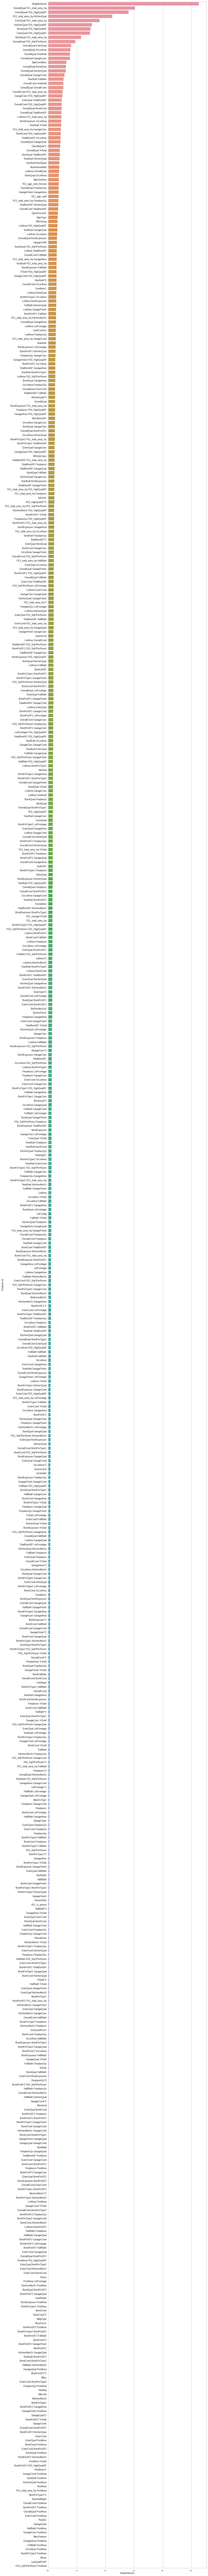

In [48]:
plt.figure(figsize=(12, 200))
sns.barplot(x="Importances", y="Feature Id", data=fe)
plt.xticks(rotation=90)
plt.show()

In [49]:
sub_name = "data/submission_21.csv"
pd.DataFrame(model.predict(X_test), 
            index=range(1461, len(df)+1), 
            columns=['SalePrice']).reset_index().\
            rename(columns={'index': 'id'}).to_csv(sub_name, index=False)

# Score: 0.12207